In [1]:
from pyspark.sql import SparkSession
from pysparkling import *
import h2o

ss = SparkSession.builder.getOrCreate()
hc = H2OContext.getOrCreate()

Connecting to H2O server at http://192.168.0.126:54325 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,25 days
H2O_cluster_name:,sparkling-water-dwoodbridge_local-1614444569693
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.32.0.4-1-3.0
 * H2O name: sparkling-water-dwoodbridge_local-1614444569693
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,192.168.0.126,54323)
  ------------------------

  Open H2O Flow in browser: http://192.168.0.126:54325 (CMD + click in Mac OSX)

    


## Create H2OFrames

In [2]:
adult_train_df = ss.read.parquet("../Data/spark-warehouse/adulttrain")
adult_train_h2o = hc.asH2OFrame(adult_train_df, "adult_train")
adult_train_h2o["label"] = adult_train_h2o["label"].asfactor()

adult_valid_df = ss.read.parquet("../Data/spark-warehouse/adultvalid")
adult_valid_h2o = hc.asH2OFrame(adult_valid_df, "adult_valid")
adult_valid_h2o["label"] = adult_valid_h2o["label"].asfactor()

## Set variables

In [3]:
predictors = adult_valid_h2o.names[:]
response = "label"
predictors.remove(response)

n_folds = 5
fold_assignment = "Modulo"
keep_cross_validation_predictions = True

## ML Algorithms

Added nfolds, fold_assignmen, keep_cross_validation_predictions

Only used training_fame for three algorithms

In [4]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator


model_gbm = H2OGradientBoostingEstimator(ntrees=50,
                                         max_depth=6,
                                         learn_rate=0.1,
                                         nfolds=n_folds,
                                         fold_assignment=fold_assignment,
                                         keep_cross_validation_predictions=
                                         keep_cross_validation_predictions,
                                         distribution="bernoulli")
model_gbm.train(x=predictors,
                y="label",
                training_frame=adult_train_h2o)


model_dl = H2ODeepLearningEstimator(variable_importances=True,
                                    nfolds=n_folds,
                                    fold_assignment=fold_assignment,
                                    keep_cross_validation_predictions=
                                    keep_cross_validation_predictions,
                                    loss="Automatic")

model_dl.train(x=predictors,
               y="label",
               training_frame=adult_train_h2o)

model_xg = H2OXGBoostEstimator(nfolds=n_folds,
                               fold_assignment=fold_assignment,
                               keep_cross_validation_predictions=
                               keep_cross_validation_predictions)
model_xg.train(x=predictors,
               y="label",
               training_frame=adult_train_h2o)


Dropping bad and constant columns: [features.97]


gbm Model Build progress: |███████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%


## Develop a stacked ensemble
http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/estimators/stackedensemble.html

http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [5]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

model_stack = H2OStackedEnsembleEstimator(training_frame=adult_train_h2o,
                                   validation_frame=adult_valid_h2o,
                                   base_models=[model_gbm.model_id, 
                                                model_dl.model_id, 
                                                model_xg.model_id])

In [6]:
model_stack.train(x=predictors, 
                  y="label", 
                  training_frame=adult_train_h2o, 
                  validation_frame=adult_valid_h2o)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [7]:
model_stack

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_model_python_1614444570335_550

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08314918932565156
RMSE: 0.28835601142624295
LogLoss: 0.2704877564166168
Null degrees of freedom: 10104
Residual degrees of freedom: 10101
Null deviance: 11106.800027414
Residual deviance: 5466.557557179825
AIC: 5474.557557179825
AUC: 0.9404776186229475
AUCPR: 0.8527653067145897
Gini: 0.8809552372458951

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.260474448131263: 


,,0,1,Error,Rate
0,0,6853.0,840.0,0.1092,(840.0/7693.0)
1,1,451.0,1961.0,0.187,(451.0/2412.0)
2,Total,7304.0,2801.0,0.1278,(1291.0/10105.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.260474,0.752350,250.0
1,max f2,0.119881,0.829299,316.0
2,max f0point5,0.678711,0.785068,114.0
3,max accuracy,0.398383,0.882039,198.0
4,max precision,0.970564,1.000000,0.0
5,max recall,0.035283,1.000000,394.0
6,max specificity,0.970564,1.000000,0.0
7,max absolute_mcc,0.341546,0.670611,218.0
8,max min_per_class_accuracy,0.203931,0.862342,276.0
9,max mean_per_class_accuracy,0.153430,0.864030,299.0



Gains/Lift Table: Avg response rate: 23.87 %, avg score: 23.88 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010094,0.970217,4.189469,4.189469,1.000000,0.970508,1.000000,0.970508,0.042289,0.042289,318.946932,318.946932,0.042289
1,2,0.020089,0.969893,4.189469,4.189469,1.000000,0.970069,1.000000,0.970290,0.041874,0.084163,318.946932,318.946932,0.084163
2,3,0.030084,0.969278,4.189469,4.189469,1.000000,0.969625,1.000000,0.970069,0.041874,0.126036,318.946932,318.946932,0.126036
3,4,0.040079,0.967627,4.189469,4.189469,1.000000,0.968576,1.000000,0.969696,0.041874,0.167910,318.946932,318.946932,0.167910
4,5,0.050074,0.964242,4.189469,4.189469,1.000000,0.966147,1.000000,0.968988,0.041874,0.209784,318.946932,318.946932,0.209784
5,6,0.100049,0.852055,3.849334,4.019570,0.918812,0.914886,0.959446,0.941964,0.192371,0.402156,284.933419,301.956997,0.396826
6,7,0.150025,0.708978,2.978256,3.672694,0.710891,0.788491,0.876649,0.890840,0.148839,0.550995,197.825641,267.269441,0.526687
7,8,0.200000,0.494859,2.339466,3.339552,0.558416,0.609340,0.797130,0.820500,0.116915,0.667910,133.946604,233.955224,0.614615
8,9,0.300049,0.222597,1.794303,2.824299,0.428289,0.326537,0.674142,0.655791,0.179519,0.847430,79.430288,182.429924,0.719001
9,10,0.400000,0.099761,0.908410,2.345564,0.216832,0.150839,0.559871,0.529616,0.090796,0.938226,-9.159032,134.556385,0.706976




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.09306710683292375
RMSE: 0.3050690197855622
LogLoss: 0.29962106173579445
Null degrees of freedom: 9827
Residual degrees of freedom: 9824
Null deviance: 10872.215747616709
Residual deviance: 5889.351589478776
AIC: 5897.351589478776
AUC: 0.9250775106585627
AUCPR: 0.8256741766955238
Gini: 0.8501550213171254

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23037401497007065: 


,,0,1,Error,Rate
0,0,6453.0,999.0,0.1341,(999.0/7452.0)
1,1,468.0,1908.0,0.197,(468.0/2376.0)
2,Total,6921.0,2907.0,0.1493,(1467.0/9828.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.230374,0.722317,263.0
1,max f2,0.114753,0.807435,320.0
2,max f0point5,0.723810,0.768618,96.0
3,max accuracy,0.537949,0.869353,153.0
4,max precision,0.970443,1.000000,0.0
5,max recall,0.033642,1.000000,399.0
6,max specificity,0.970443,1.000000,0.0
7,max absolute_mcc,0.367733,0.629276,207.0
8,max min_per_class_accuracy,0.181011,0.838567,283.0
9,max mean_per_class_accuracy,0.145571,0.844084,302.0



Gains/Lift Table: Avg response rate: 24.18 %, avg score: 23.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010073,0.970260,4.136364,4.136364,1.000000,0.970551,1.000000,0.970551,0.041667,0.041667,313.636364,313.636364,0.041667
1,2,0.020045,0.969964,4.136364,4.136364,1.000000,0.970116,1.000000,0.970335,0.041246,0.082912,313.636364,313.636364,0.082912
2,3,0.030016,0.969337,4.136364,4.136364,1.000000,0.969694,1.000000,0.970122,0.041246,0.124158,313.636364,313.636364,0.124158
3,4,0.040090,0.967692,4.136364,4.136364,1.000000,0.968695,1.000000,0.969763,0.041667,0.165825,313.636364,313.636364,0.165825
4,5,0.050061,0.964319,4.136364,4.136364,1.000000,0.965905,1.000000,0.968995,0.041246,0.207071,313.636364,313.636364,0.207071
5,6,0.100020,0.853684,3.597204,3.867058,0.869654,0.915025,0.934893,0.942037,0.179714,0.386785,259.720422,286.705817,0.378196
6,7,0.150081,0.712625,2.942535,3.558675,0.711382,0.787528,0.860339,0.890499,0.147306,0.534091,194.253511,255.867488,0.506447
7,8,0.200041,0.473738,2.106091,3.195898,0.509165,0.597866,0.772635,0.817415,0.105219,0.639310,110.609146,219.589846,0.579326
8,9,0.300061,0.220784,1.678951,2.690249,0.405900,0.325061,0.650390,0.653297,0.167929,0.807239,67.895126,169.024939,0.668887
9,10,0.399980,0.103209,1.031985,2.276000,0.249491,0.151767,0.550242,0.528010,0.103114,0.910354,3.198482,127.599963,0.673102


In [8]:
model_stack.base_models

['GBM_model_python_1614444570335_1',
 'DeepLearning_model_python_1614444570335_251',
 'XGBoost_model_python_1614444570335_294']

In [9]:
model_stack.stacking_strategy()

'cross_validation'

In [10]:
model_stack.model_performance()


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08314918932565156
RMSE: 0.28835601142624295
LogLoss: 0.2704877564166168
Null degrees of freedom: 10104
Residual degrees of freedom: 10101
Null deviance: 11106.800027414
Residual deviance: 5466.557557179825
AIC: 5474.557557179825
AUC: 0.9404776186229475
AUCPR: 0.8527653067145897
Gini: 0.8809552372458951

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.260474448131263: 


,,0,1,Error,Rate
0,0,6853.0,840.0,0.1092,(840.0/7693.0)
1,1,451.0,1961.0,0.187,(451.0/2412.0)
2,Total,7304.0,2801.0,0.1278,(1291.0/10105.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.260474,0.752350,250.0
1,max f2,0.119881,0.829299,316.0
2,max f0point5,0.678711,0.785068,114.0
3,max accuracy,0.398383,0.882039,198.0
4,max precision,0.970564,1.000000,0.0
5,max recall,0.035283,1.000000,394.0
6,max specificity,0.970564,1.000000,0.0
7,max absolute_mcc,0.341546,0.670611,218.0
8,max min_per_class_accuracy,0.203931,0.862342,276.0
9,max mean_per_class_accuracy,0.153430,0.864030,299.0



Gains/Lift Table: Avg response rate: 23.87 %, avg score: 23.88 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010094,0.970217,4.189469,4.189469,1.000000,0.970508,1.000000,0.970508,0.042289,0.042289,318.946932,318.946932,0.042289
1,2,0.020089,0.969893,4.189469,4.189469,1.000000,0.970069,1.000000,0.970290,0.041874,0.084163,318.946932,318.946932,0.084163
2,3,0.030084,0.969278,4.189469,4.189469,1.000000,0.969625,1.000000,0.970069,0.041874,0.126036,318.946932,318.946932,0.126036
3,4,0.040079,0.967627,4.189469,4.189469,1.000000,0.968576,1.000000,0.969696,0.041874,0.167910,318.946932,318.946932,0.167910
4,5,0.050074,0.964242,4.189469,4.189469,1.000000,0.966147,1.000000,0.968988,0.041874,0.209784,318.946932,318.946932,0.209784
5,6,0.100049,0.852055,3.849334,4.019570,0.918812,0.914886,0.959446,0.941964,0.192371,0.402156,284.933419,301.956997,0.396826
6,7,0.150025,0.708978,2.978256,3.672694,0.710891,0.788491,0.876649,0.890840,0.148839,0.550995,197.825641,267.269441,0.526687
7,8,0.200000,0.494859,2.339466,3.339552,0.558416,0.609340,0.797130,0.820500,0.116915,0.667910,133.946604,233.955224,0.614615
8,9,0.300049,0.222597,1.794303,2.824299,0.428289,0.326537,0.674142,0.655791,0.179519,0.847430,79.430288,182.429924,0.719001
9,10,0.400000,0.099761,0.908410,2.345564,0.216832,0.150839,0.559871,0.529616,0.090796,0.938226,-9.159032,134.556385,0.706976


## Model Explainability 
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html#explanation-plotting-functions

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_model_python_1614444570335_550


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.260474448131263: 


,,0,1,Error,Rate
0,0,6853.0,840.0,0.1092,(840.0/7693.0)
1,1,451.0,1961.0,0.187,(451.0/2412.0)
2,Total,7304.0,2801.0,0.1278,(1291.0/10105.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

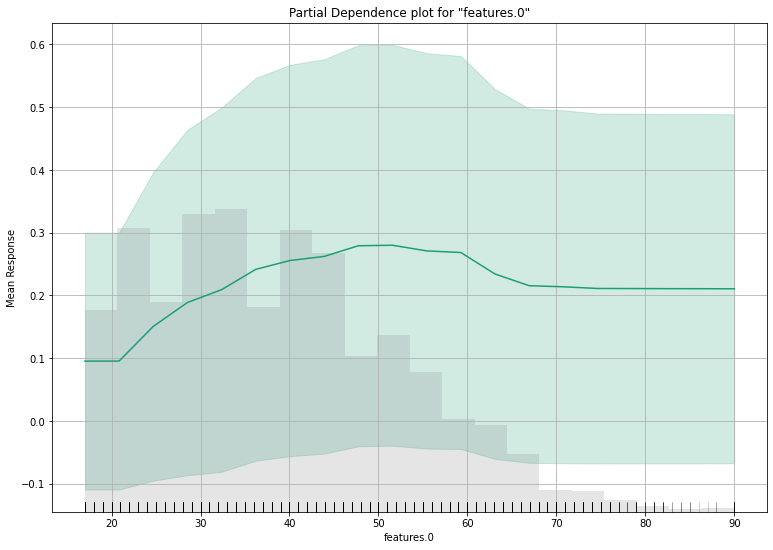

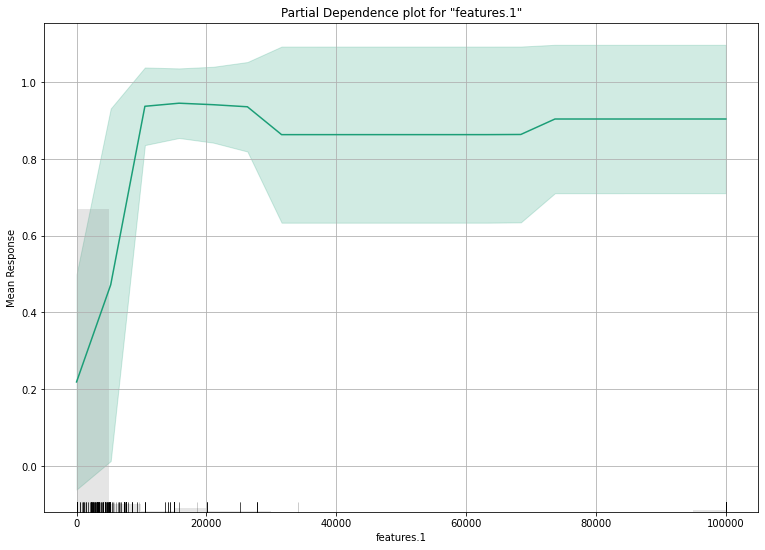

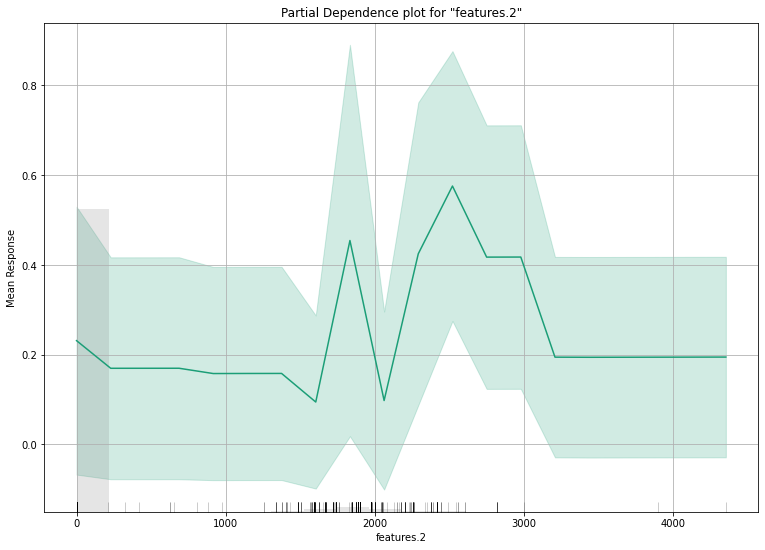

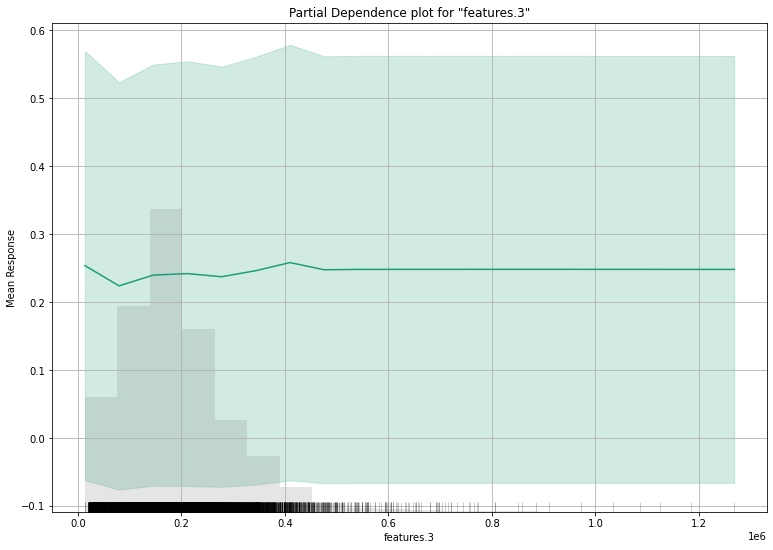

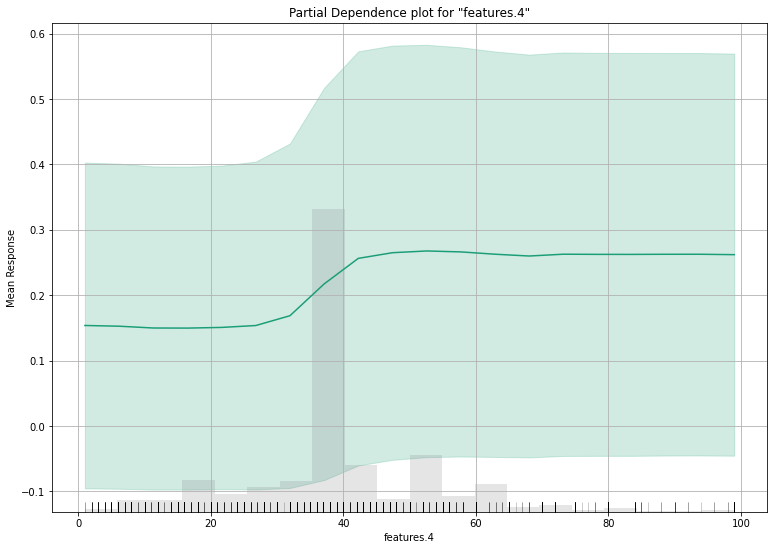

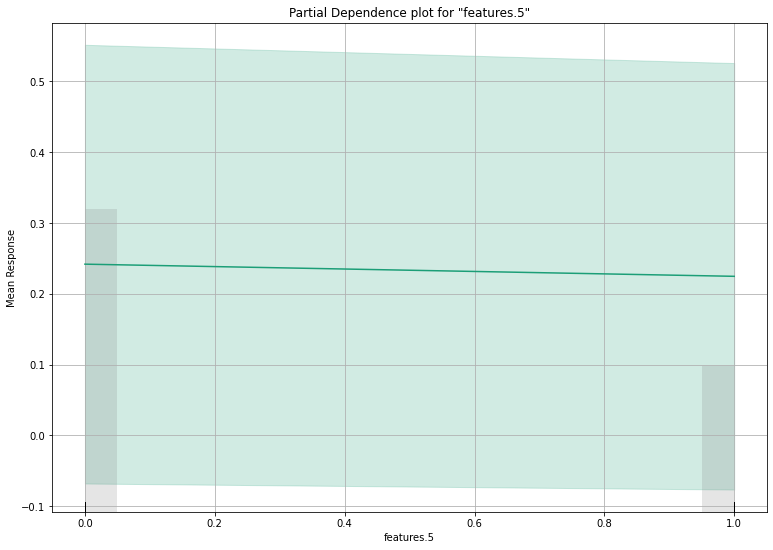

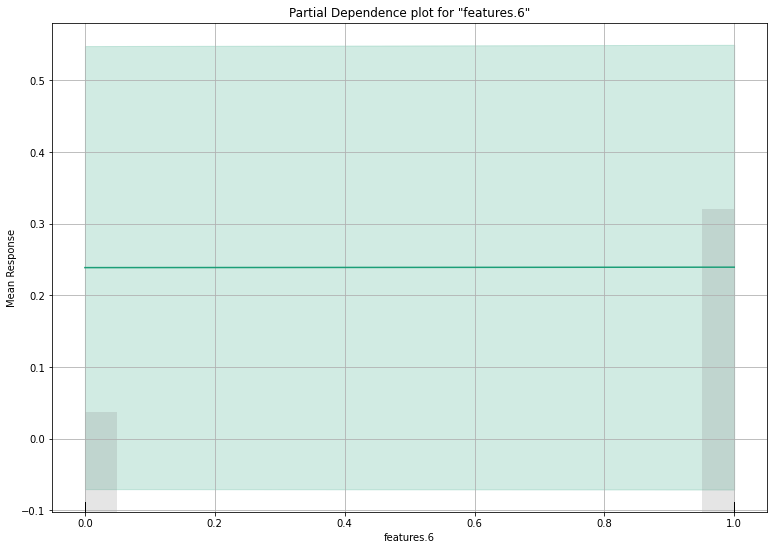

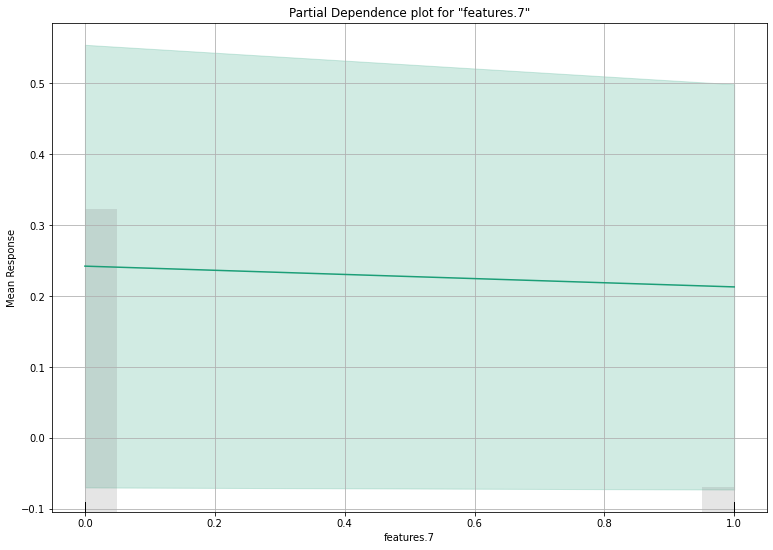

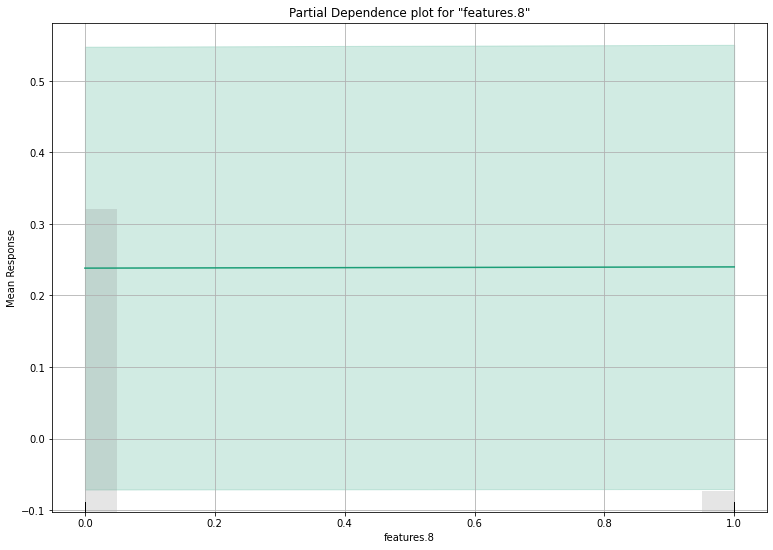

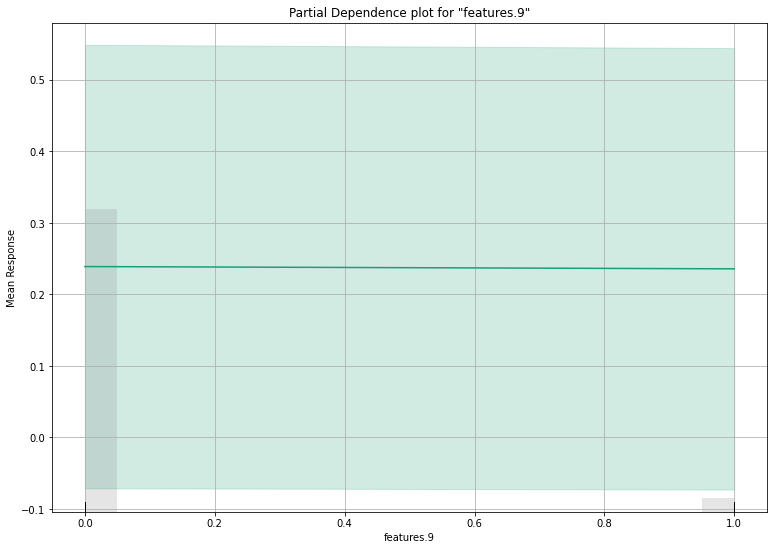

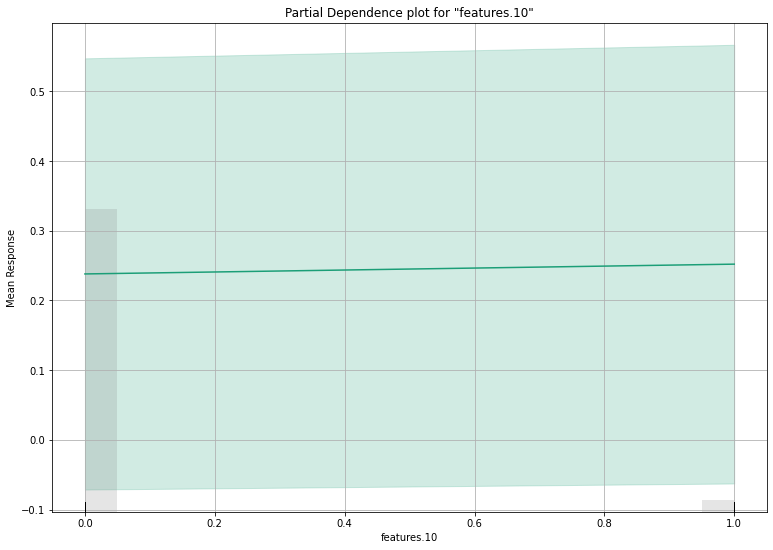

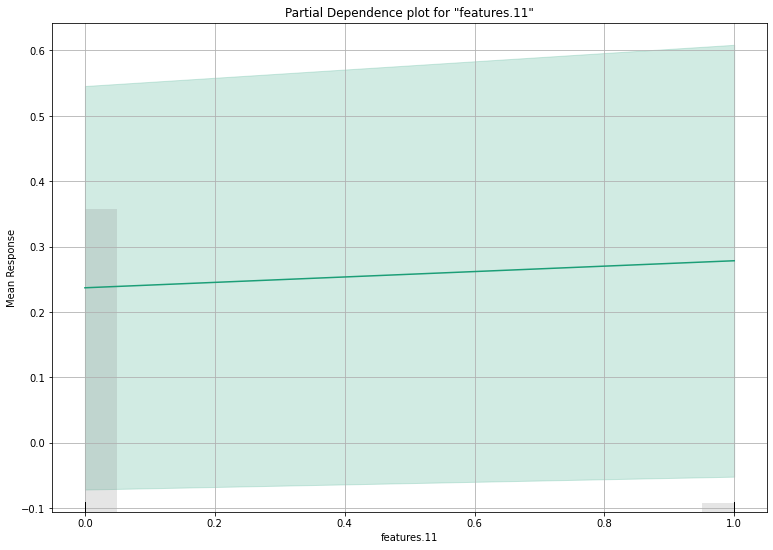

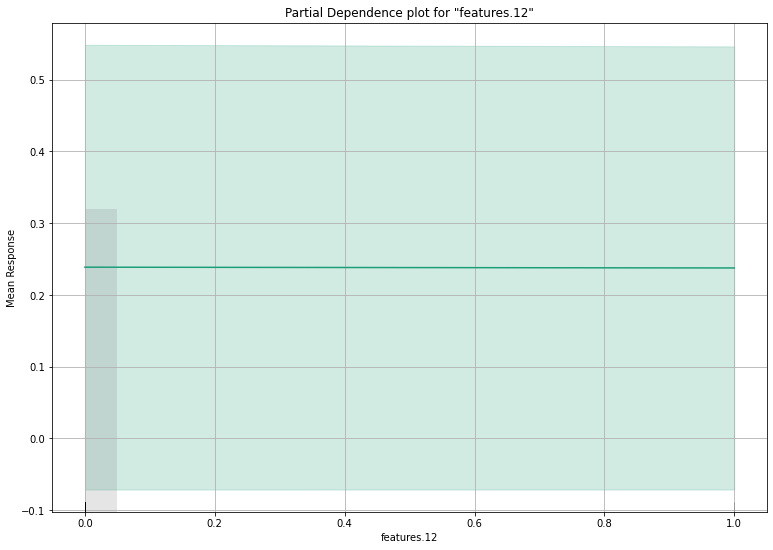

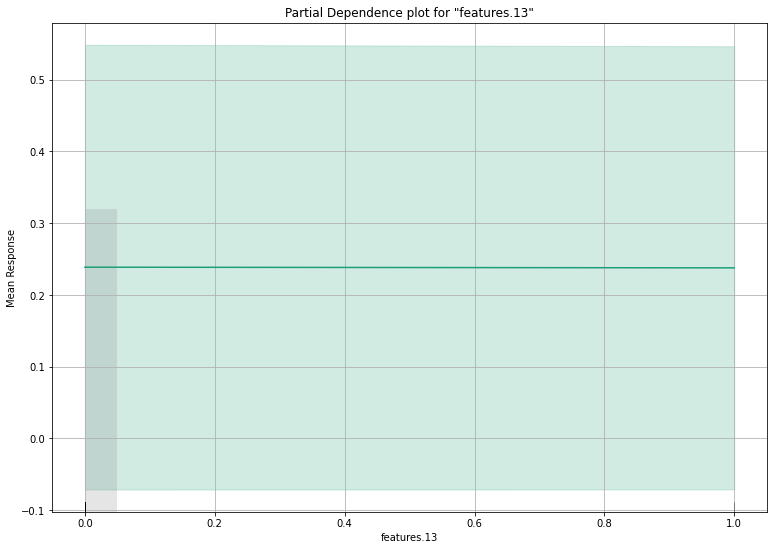

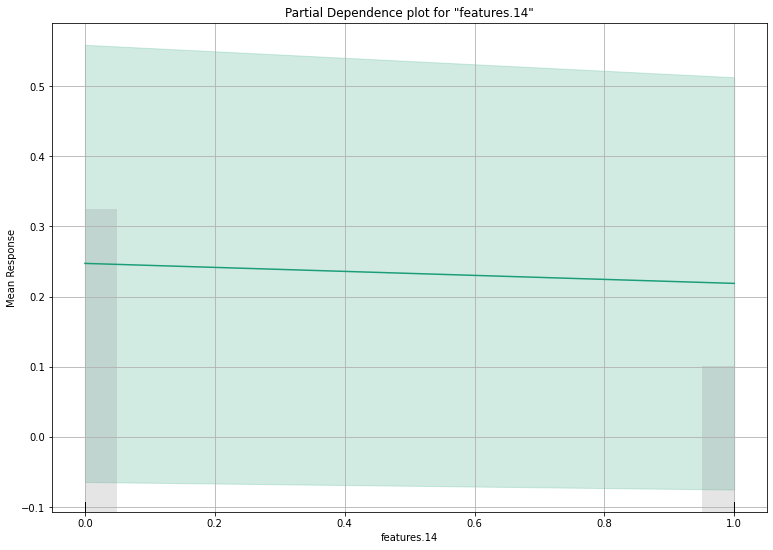

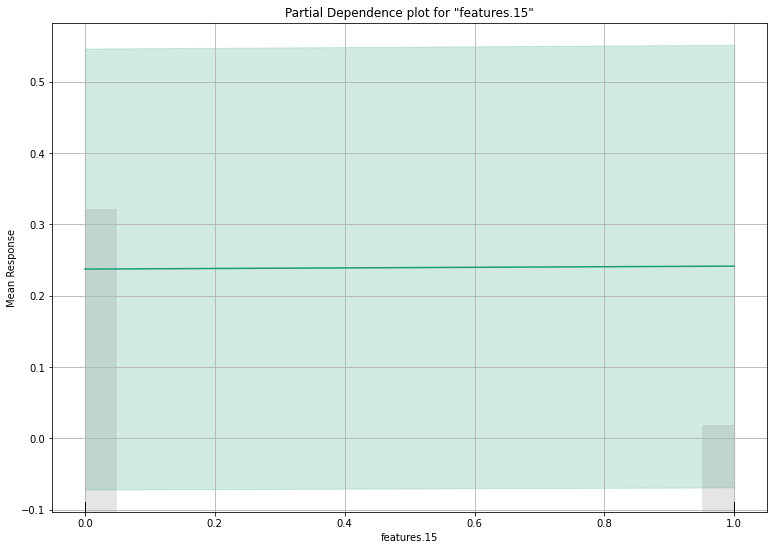

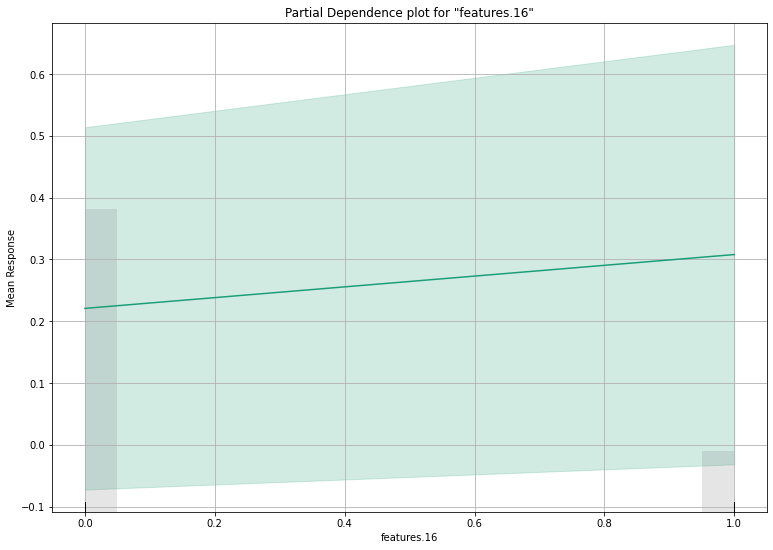

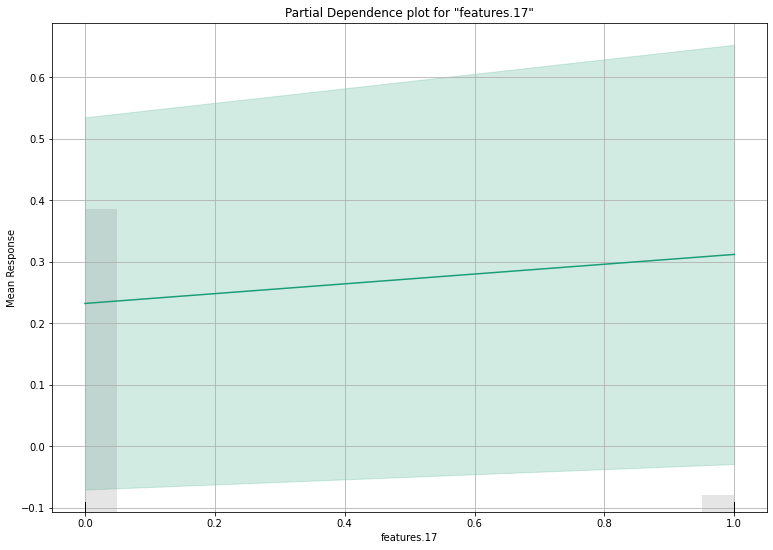

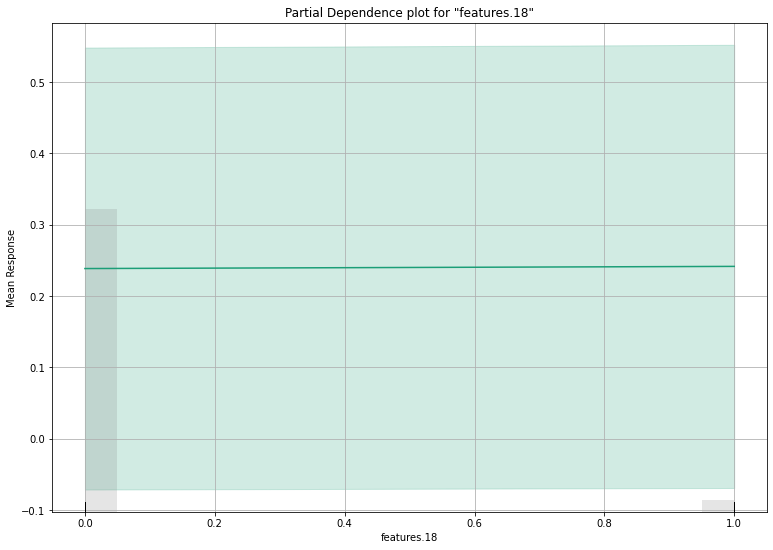

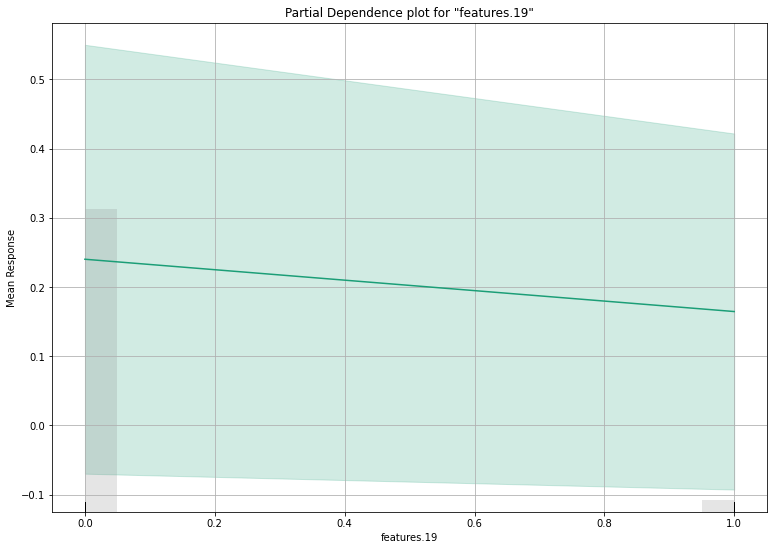

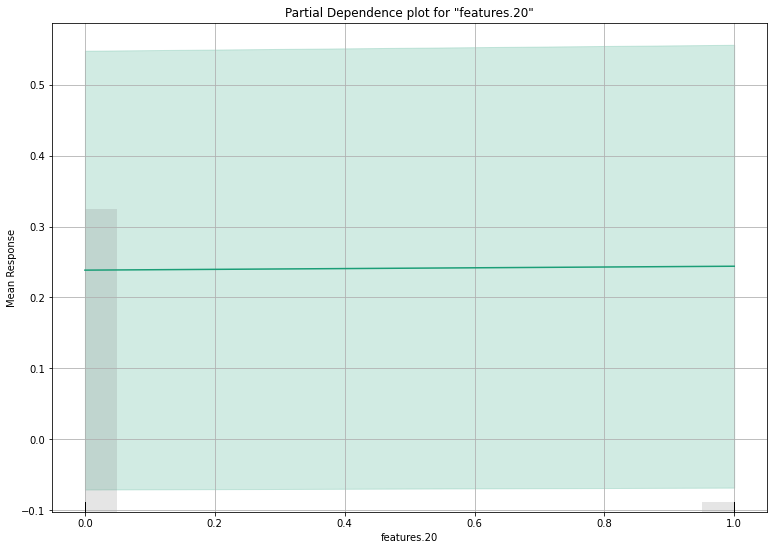

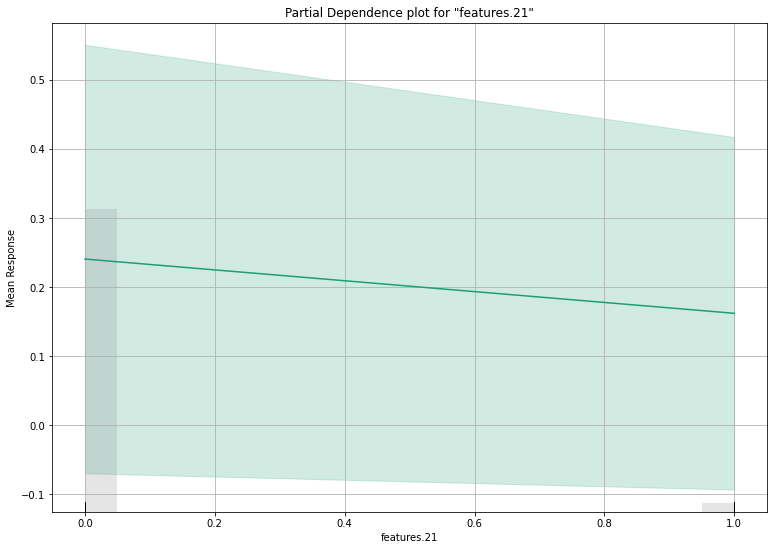

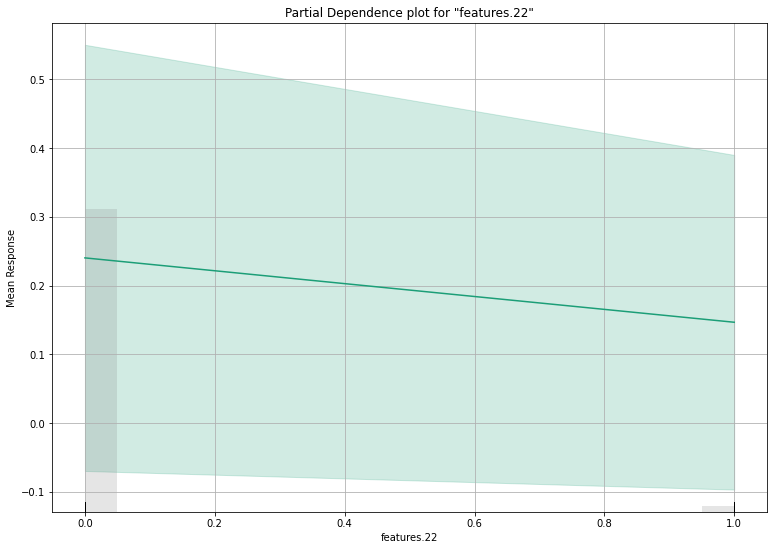

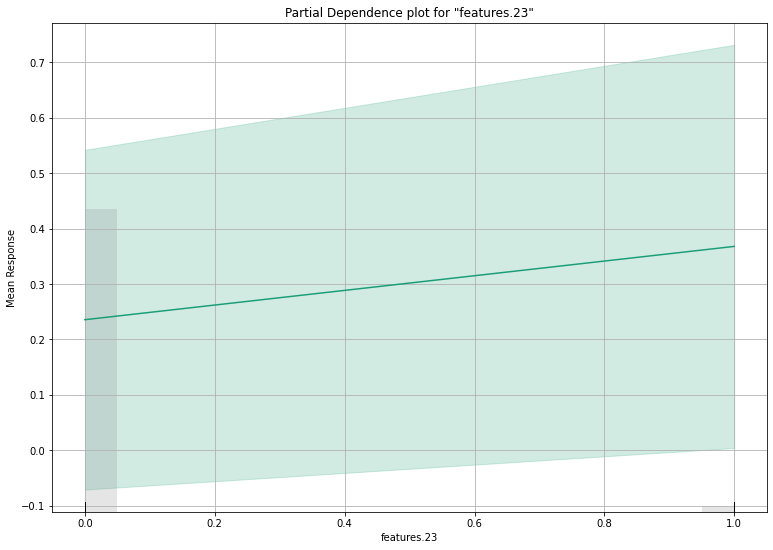

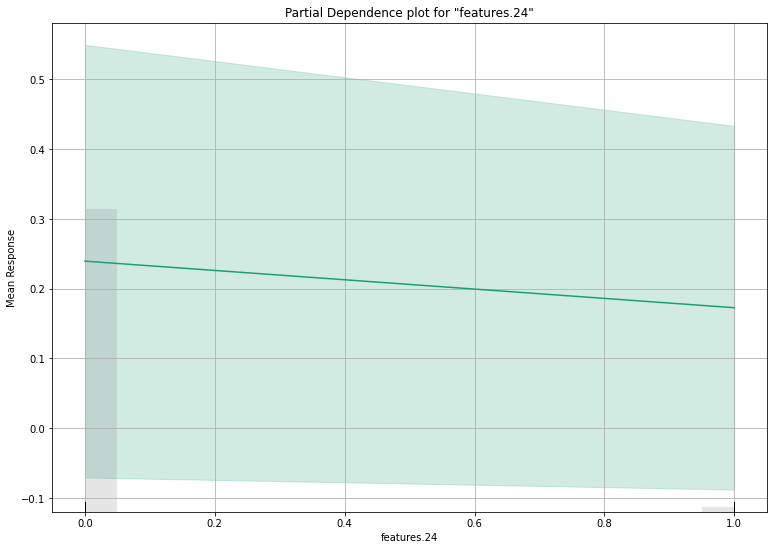

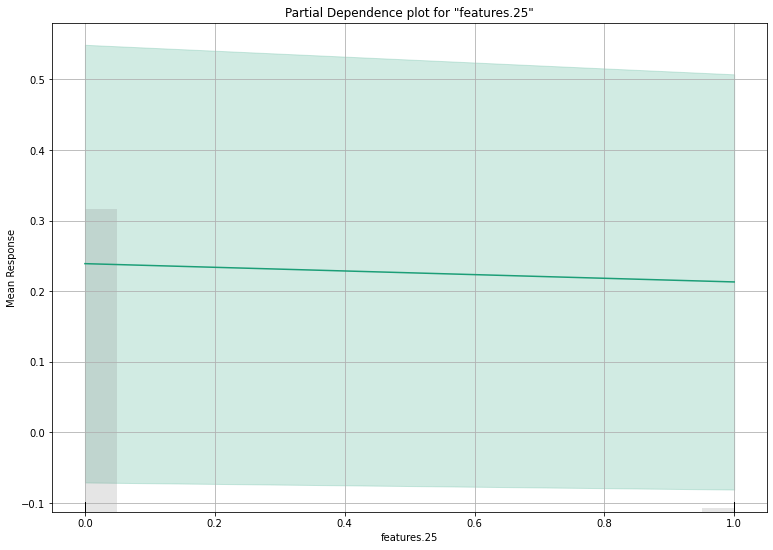

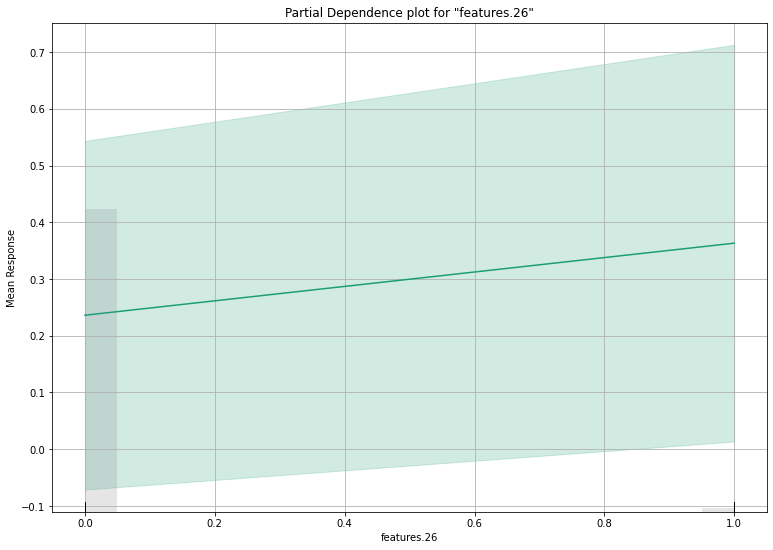

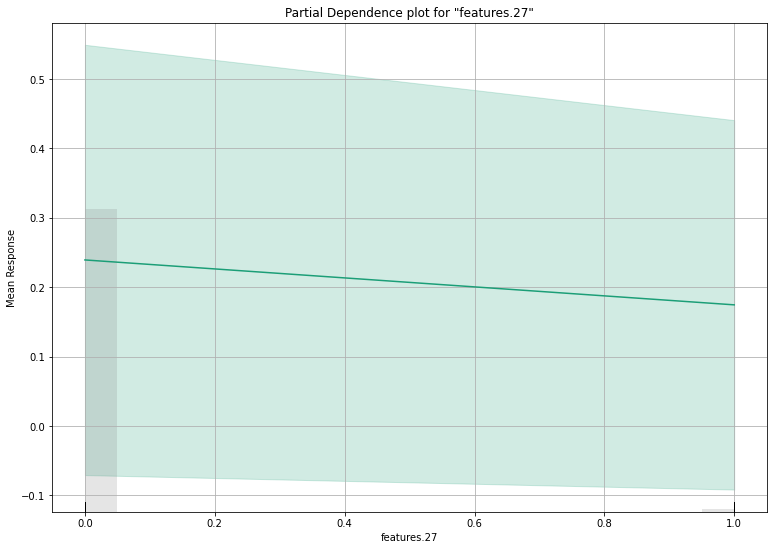

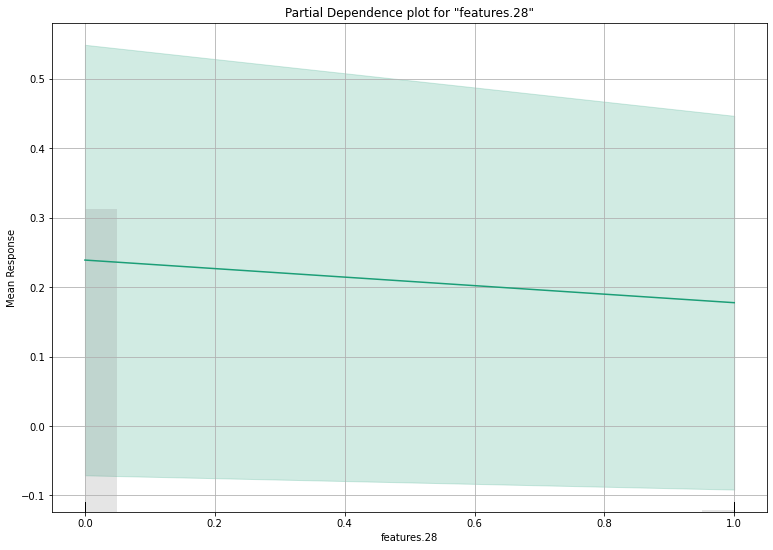

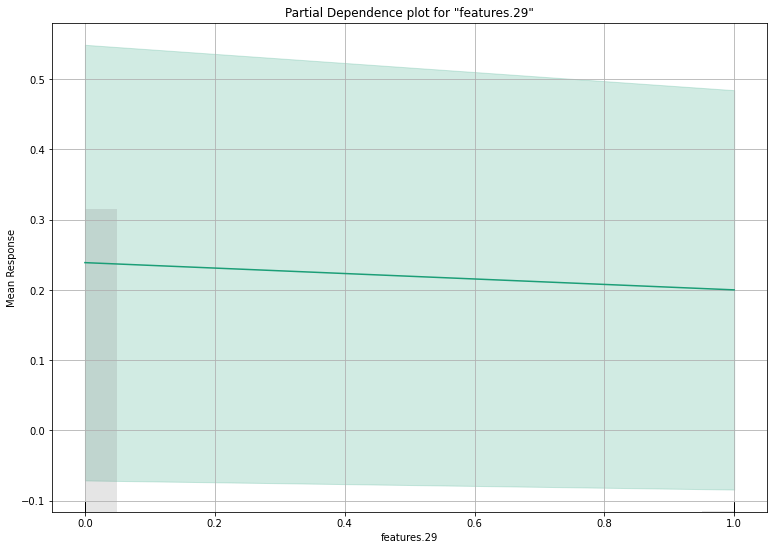

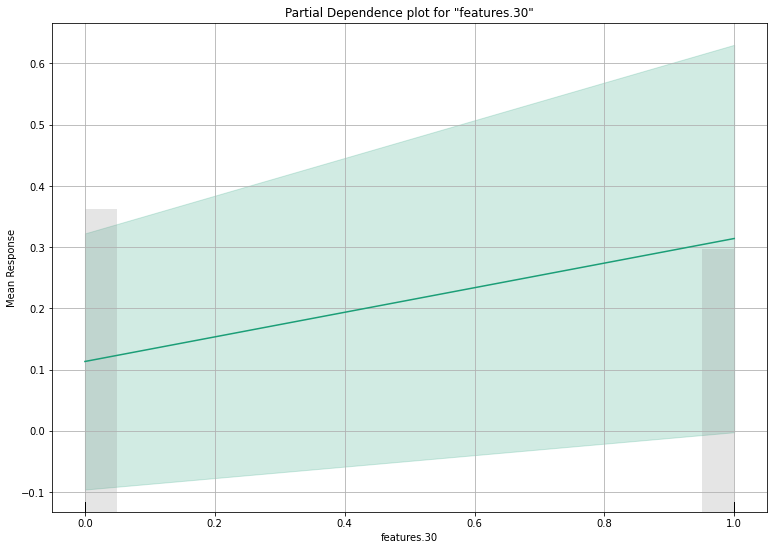

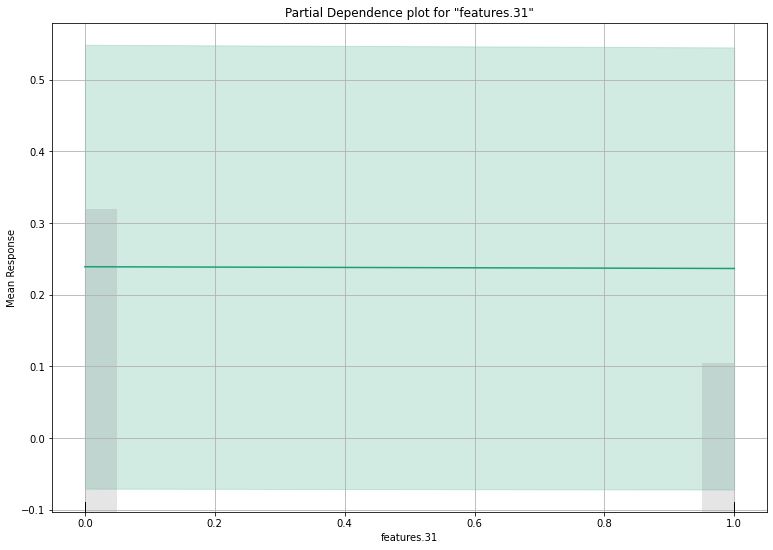

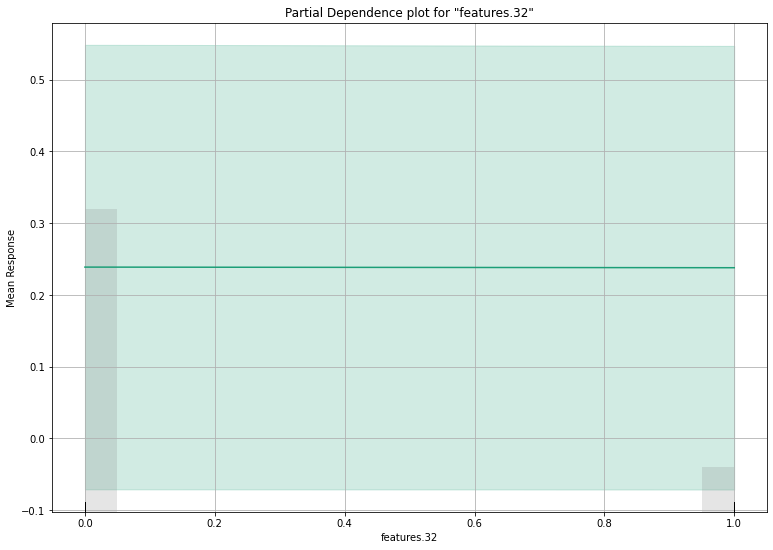

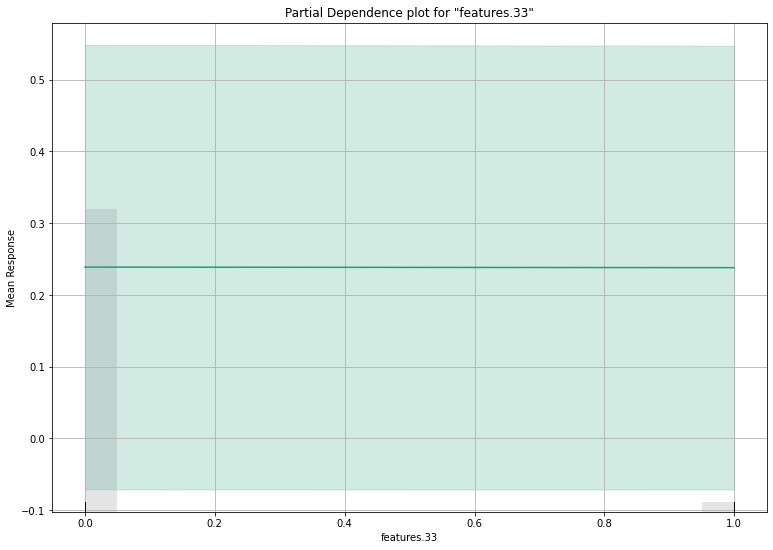

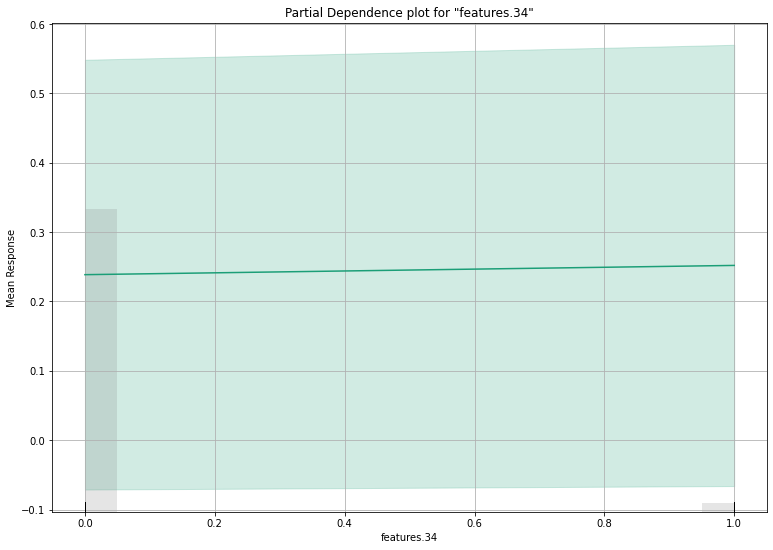

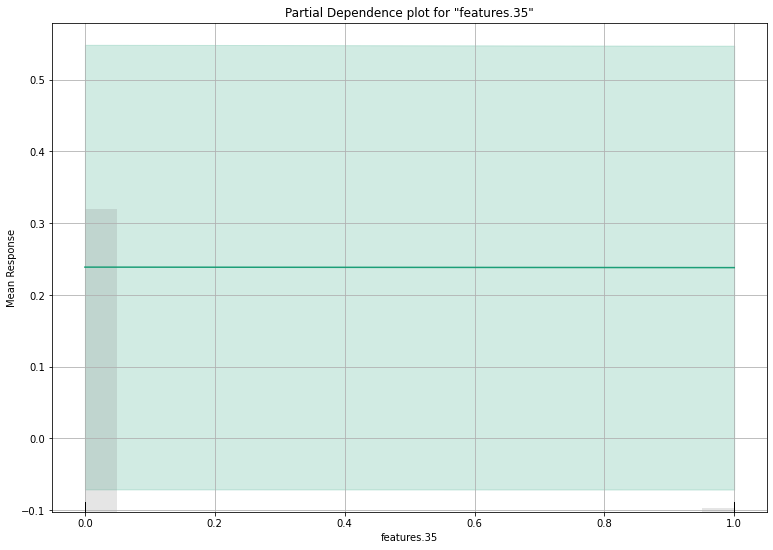

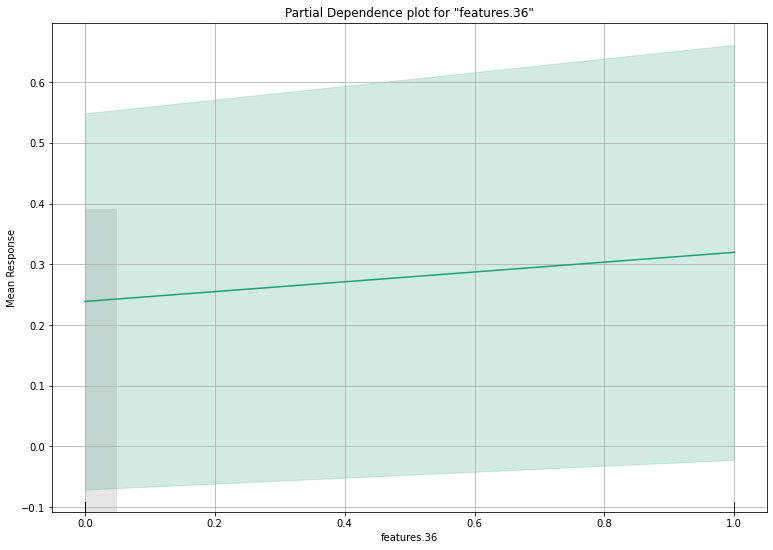

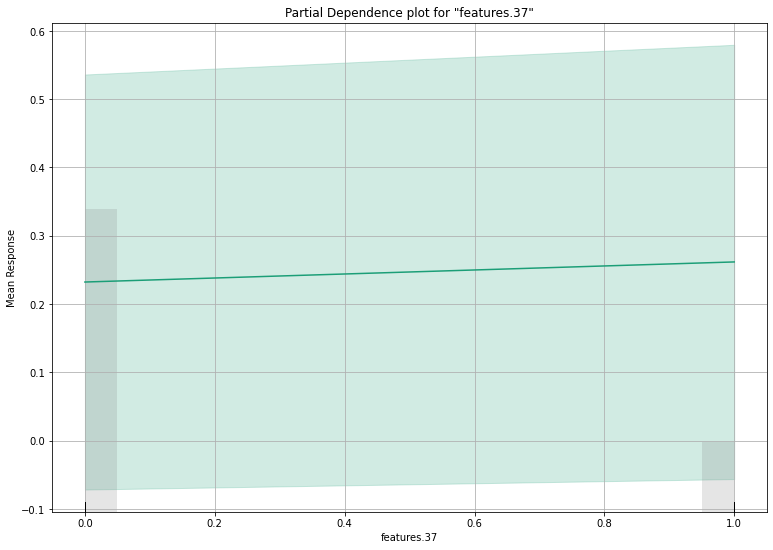

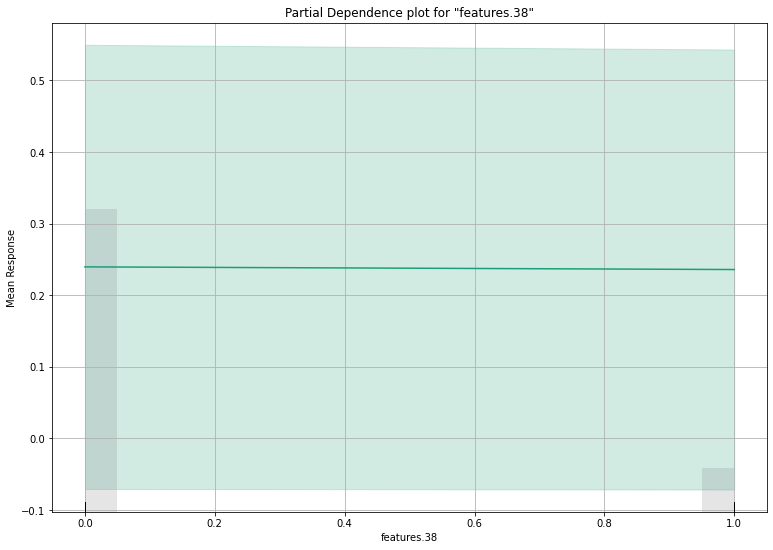

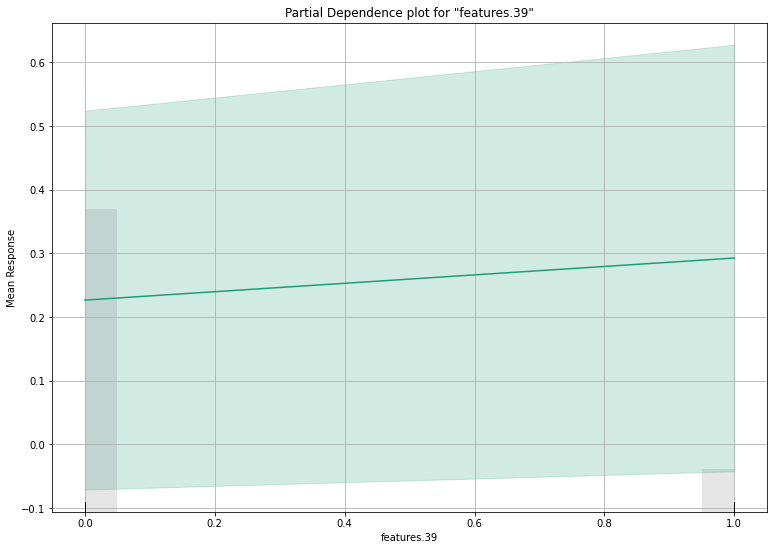

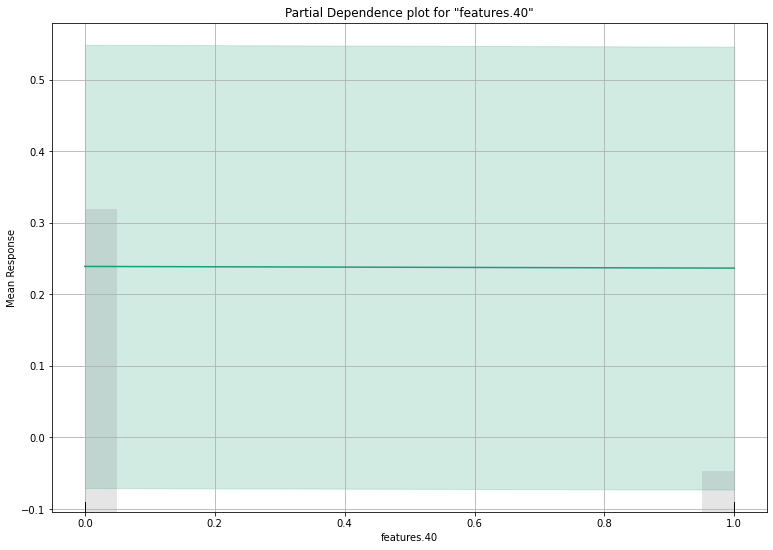

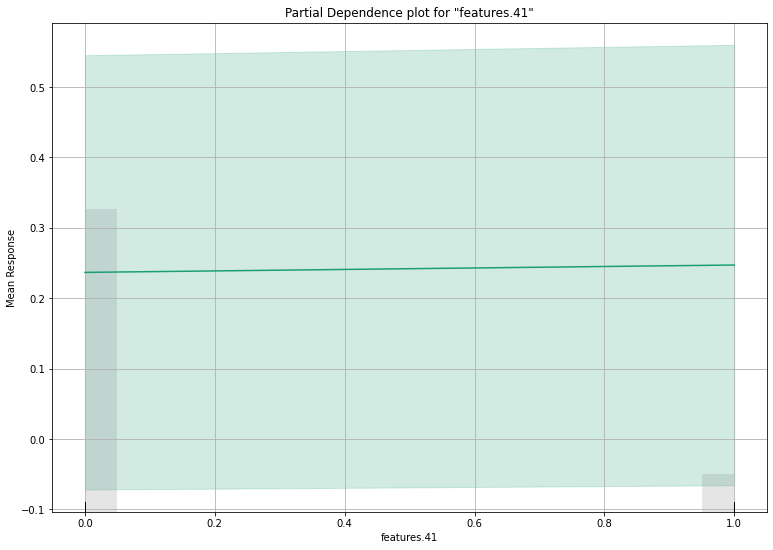

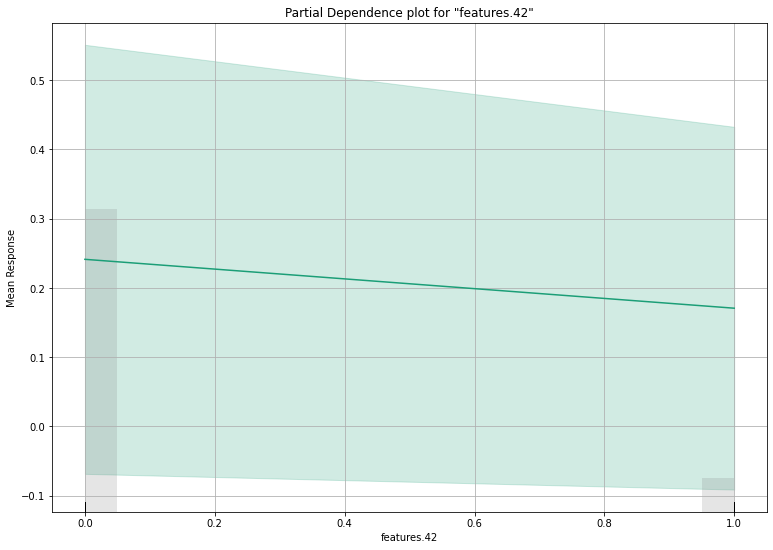

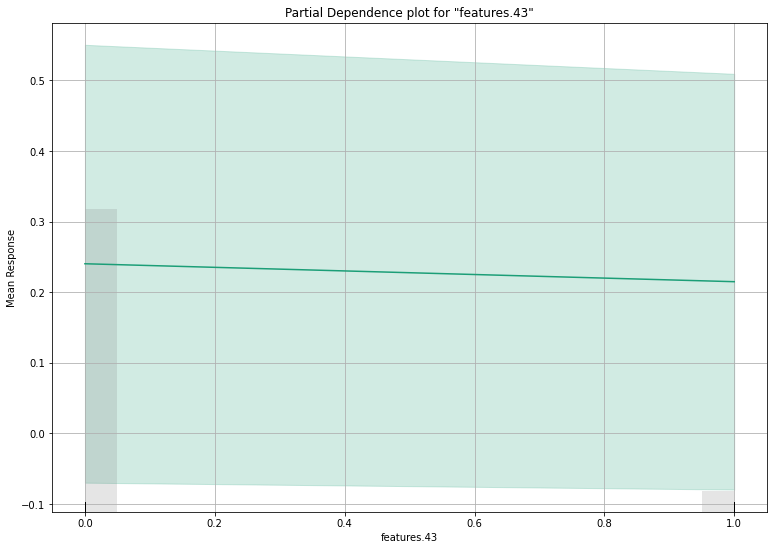

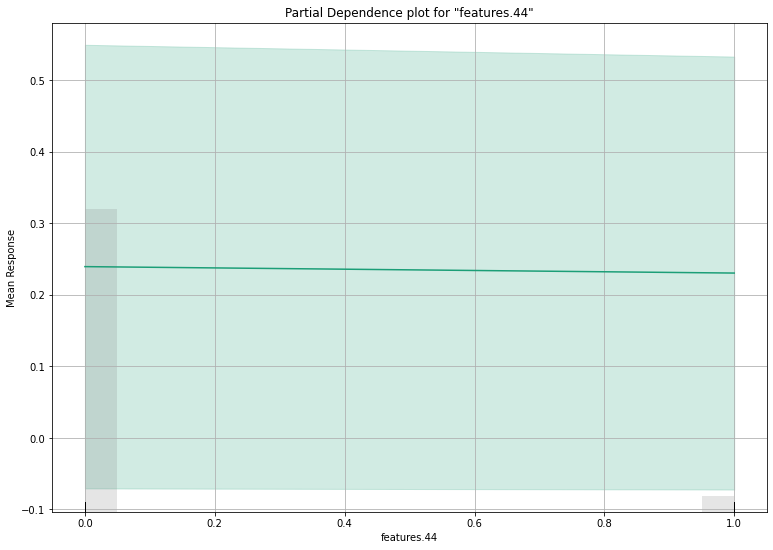

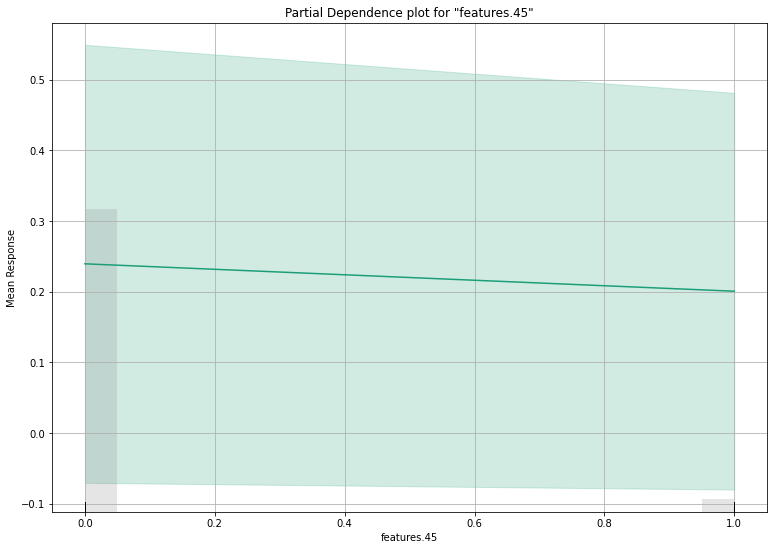

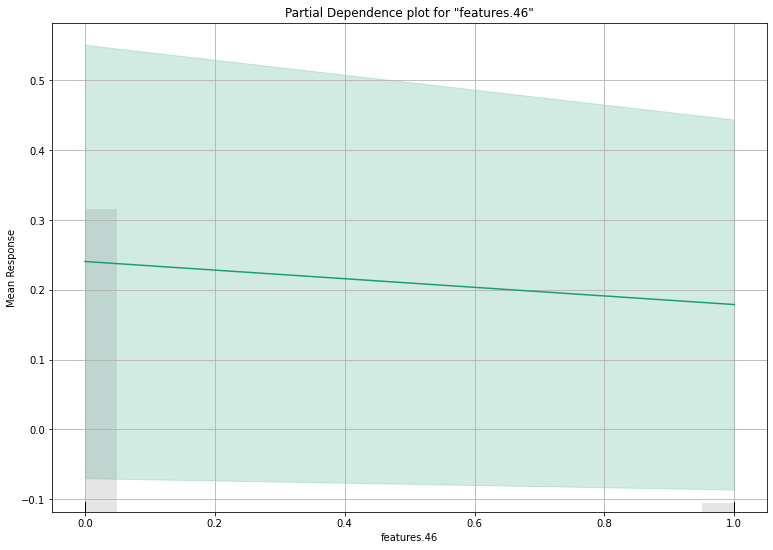

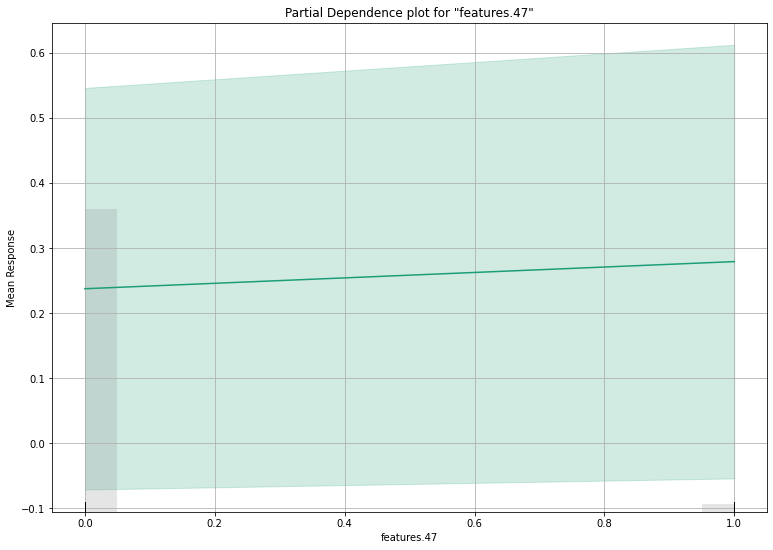

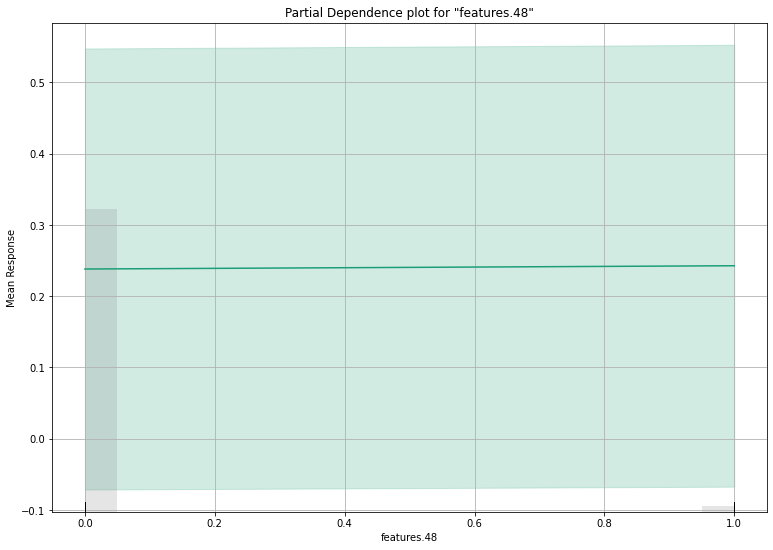

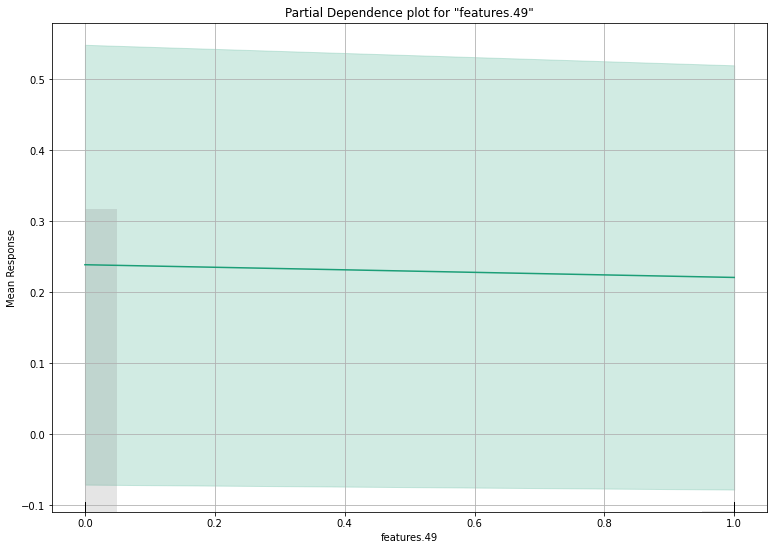

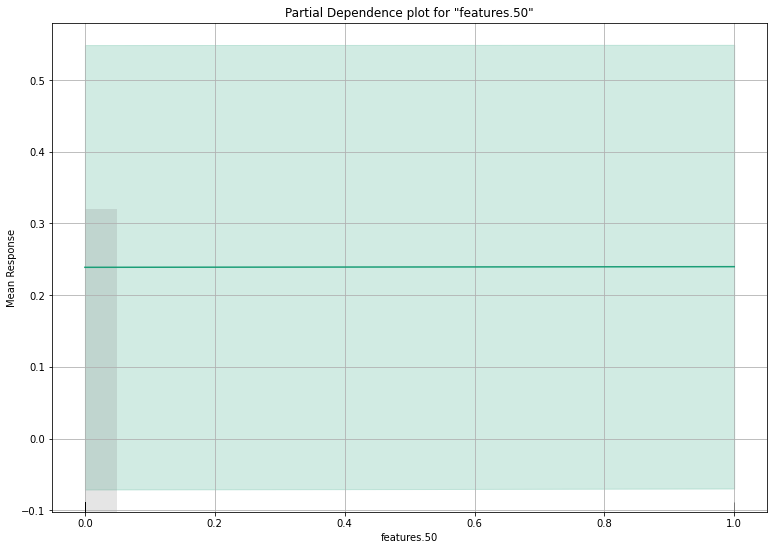

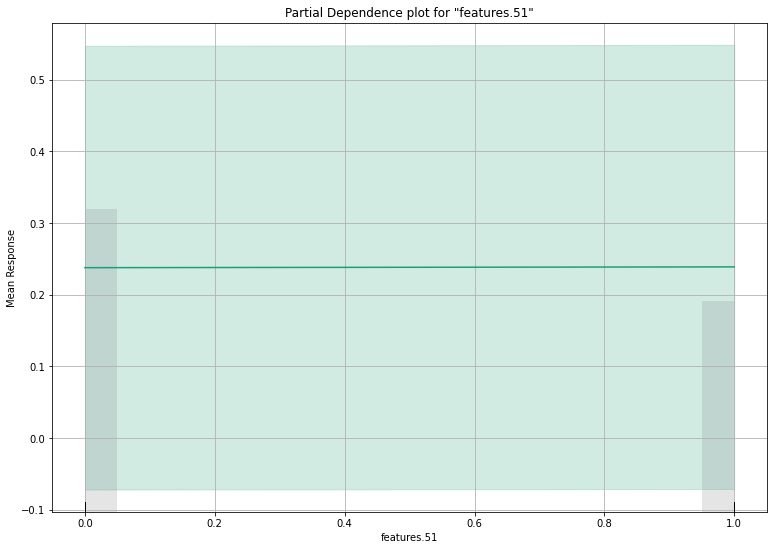

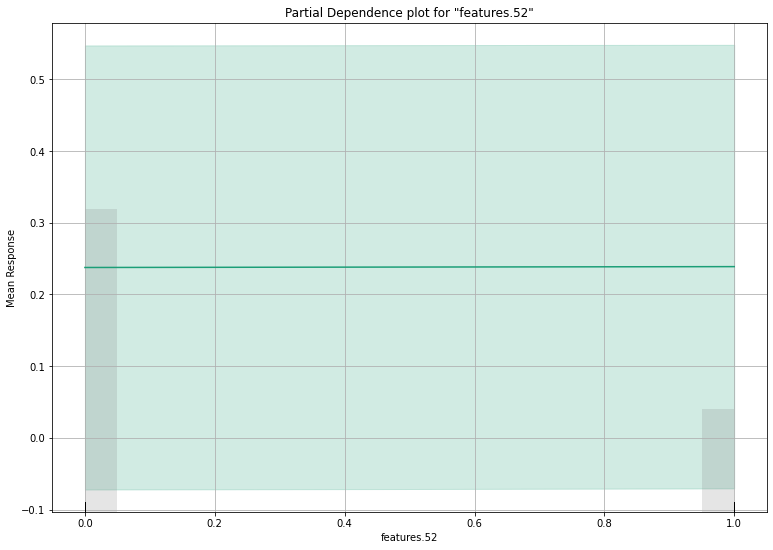

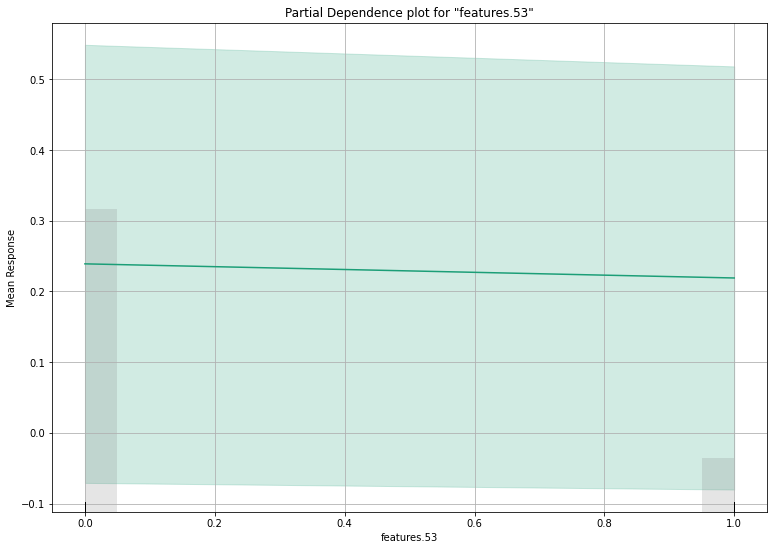

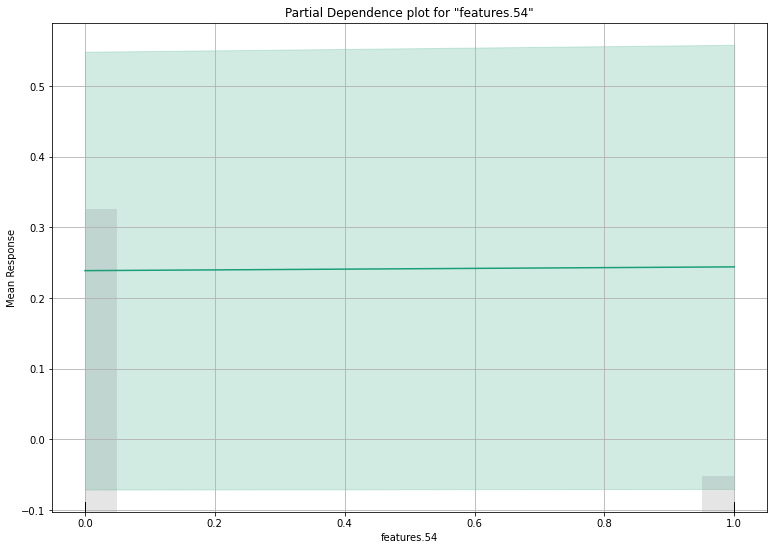

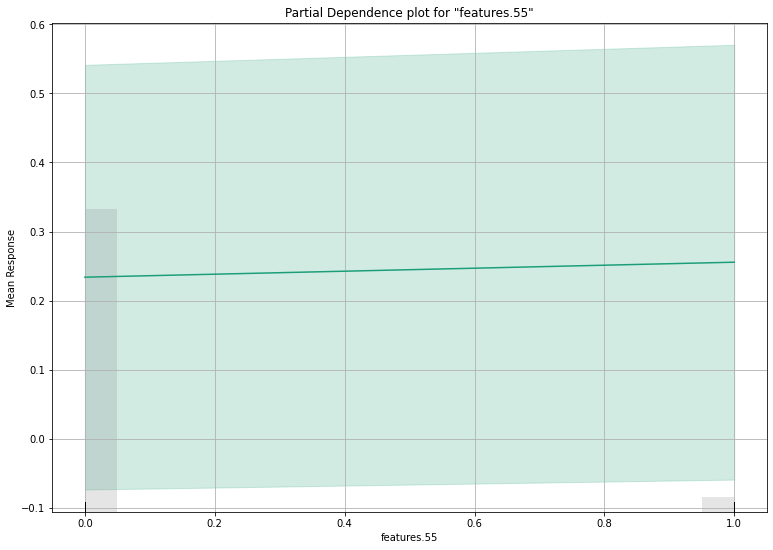

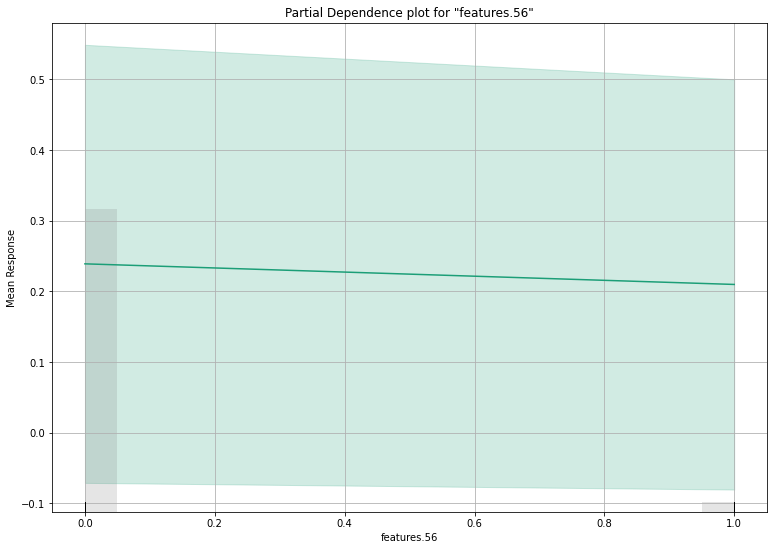

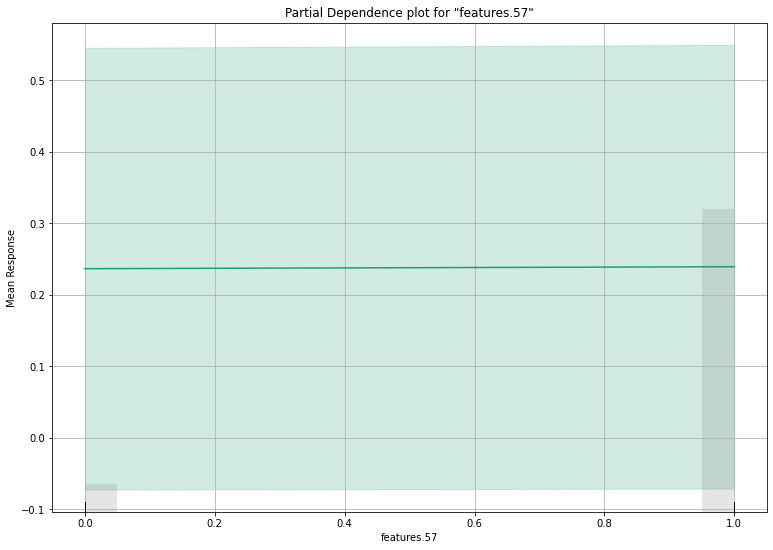

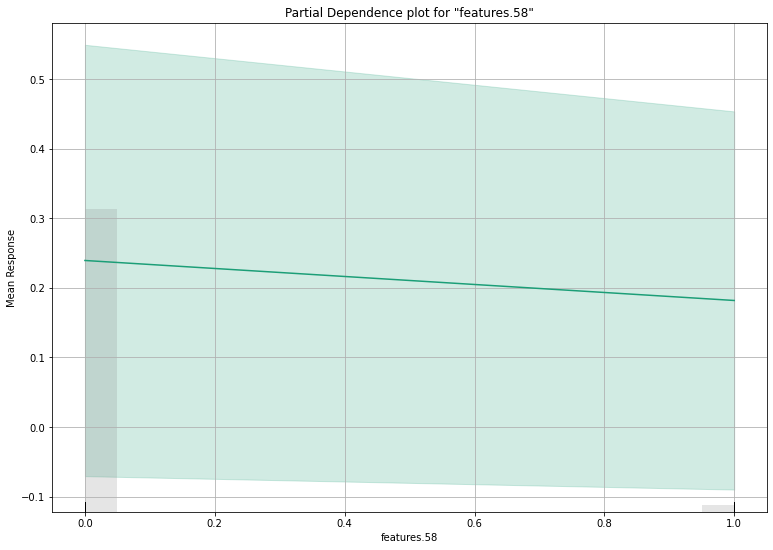

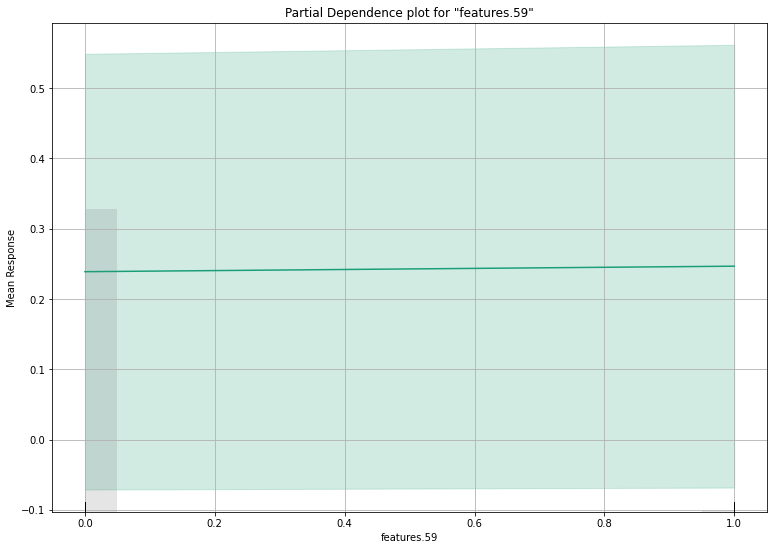

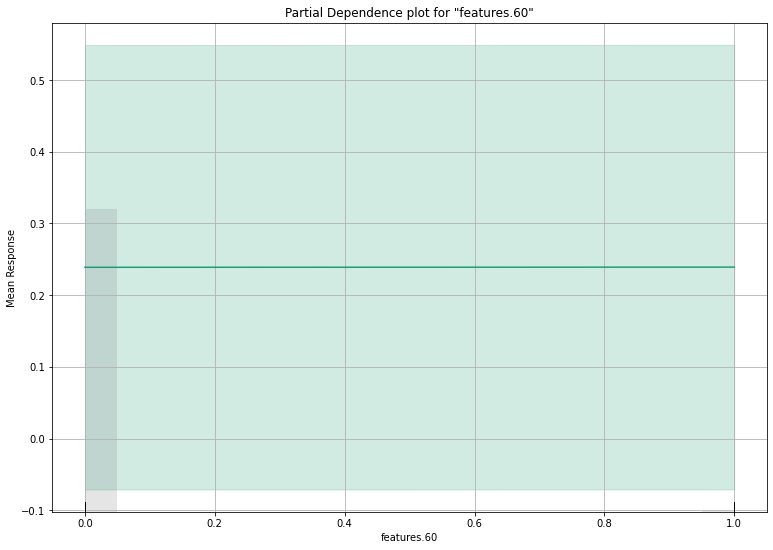

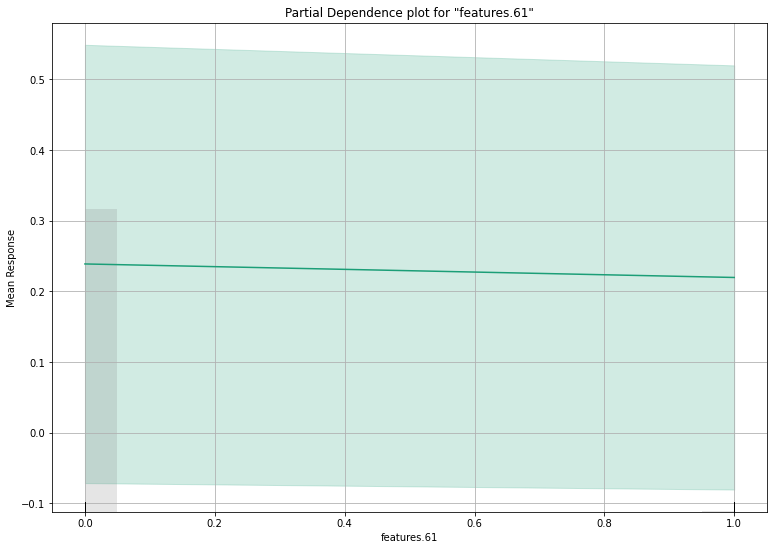

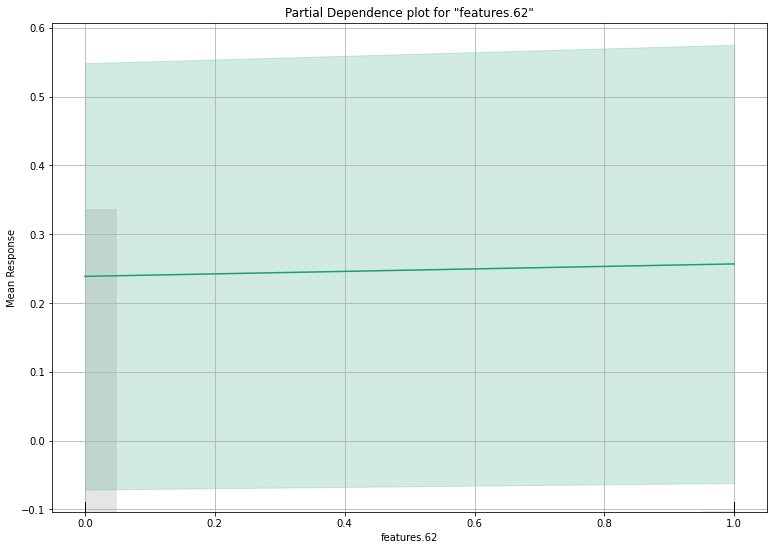

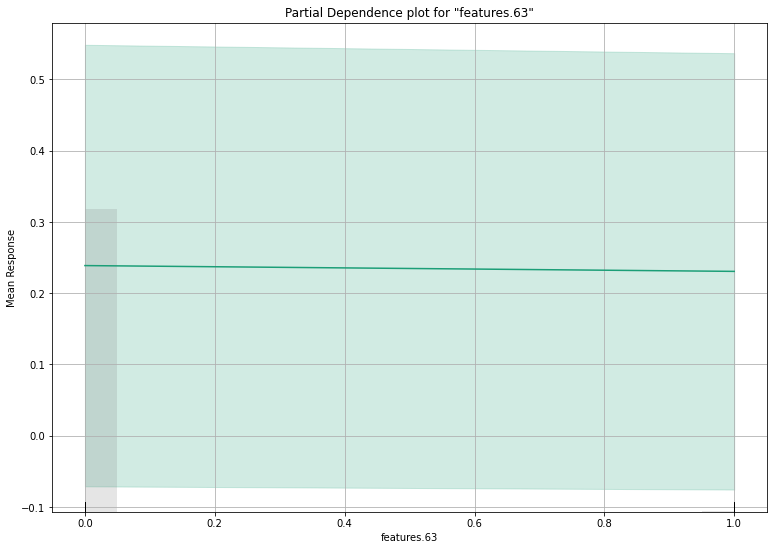

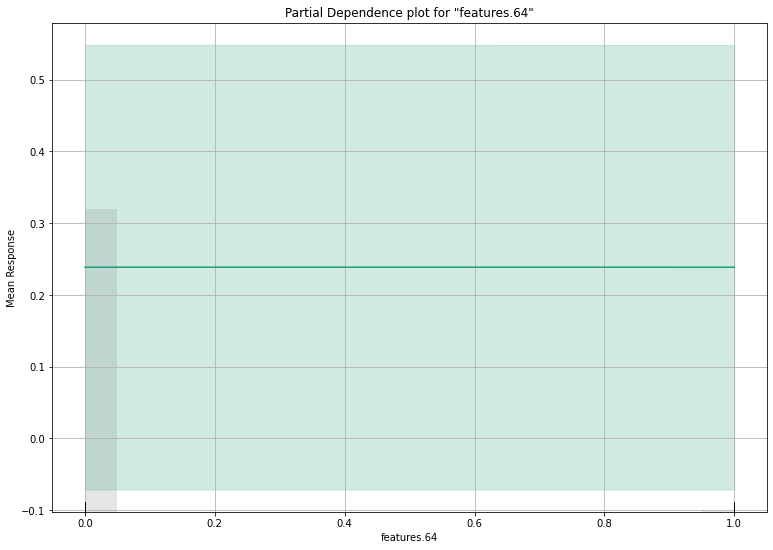

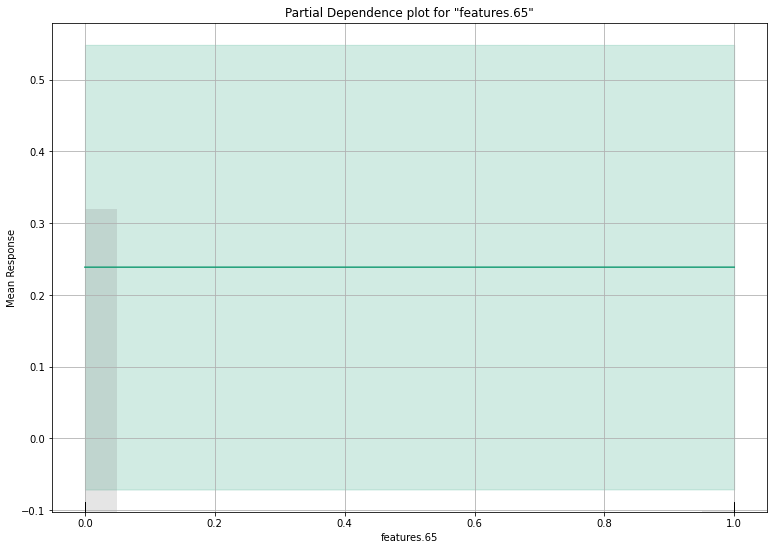

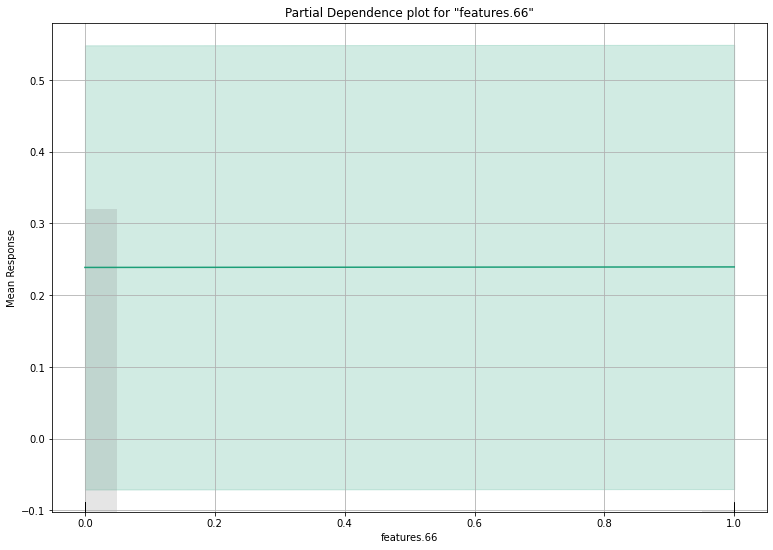

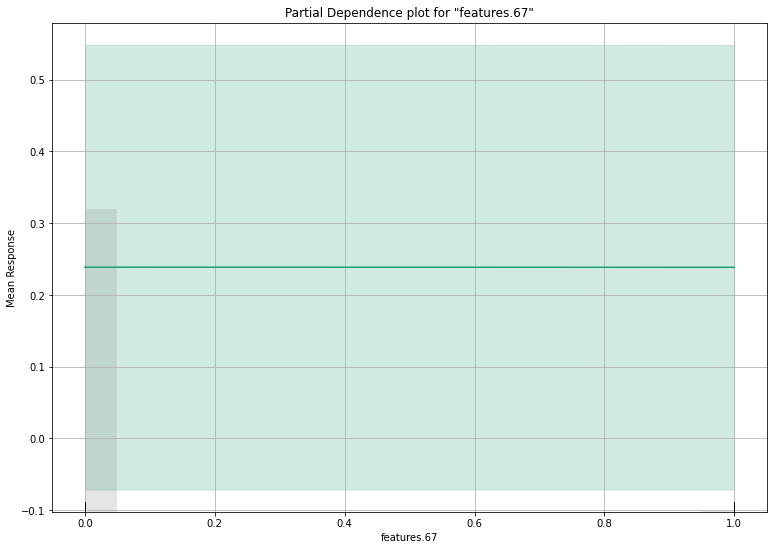

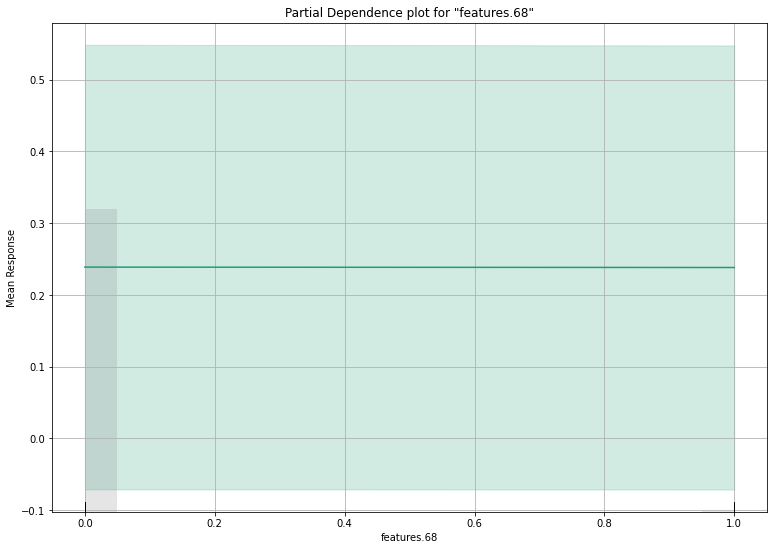

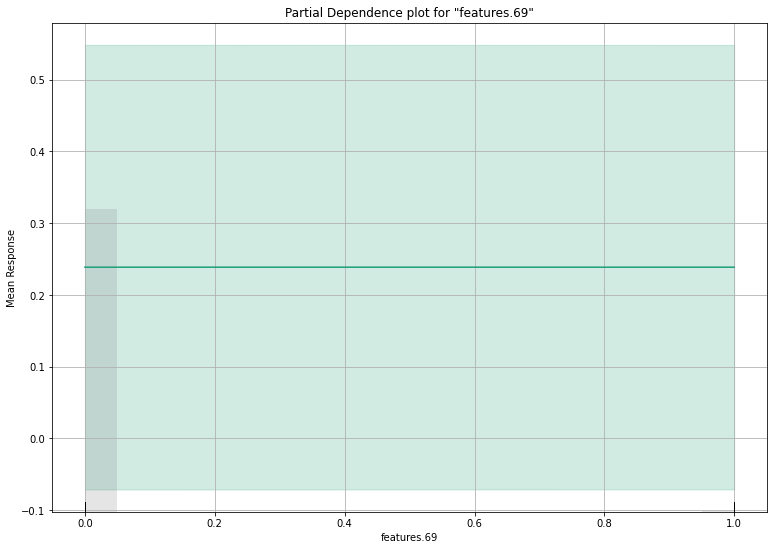

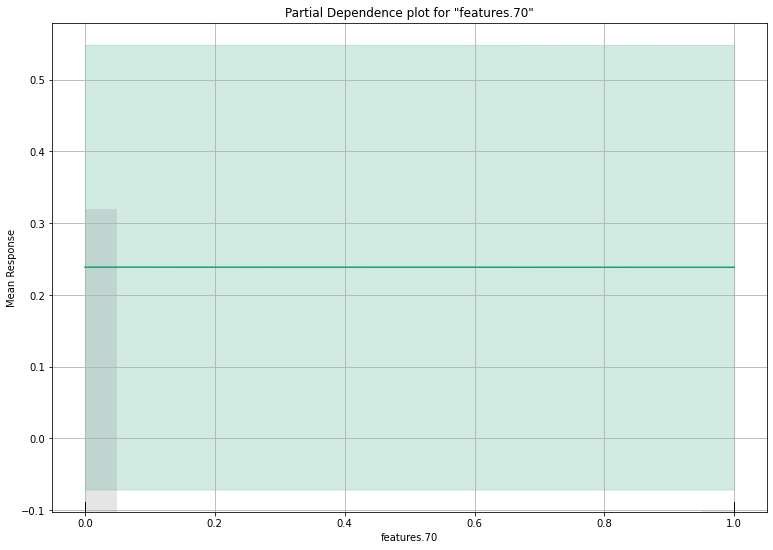

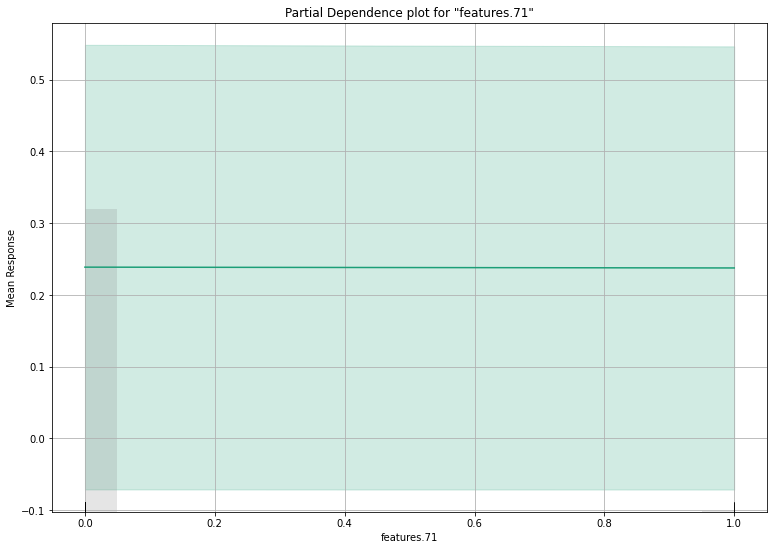

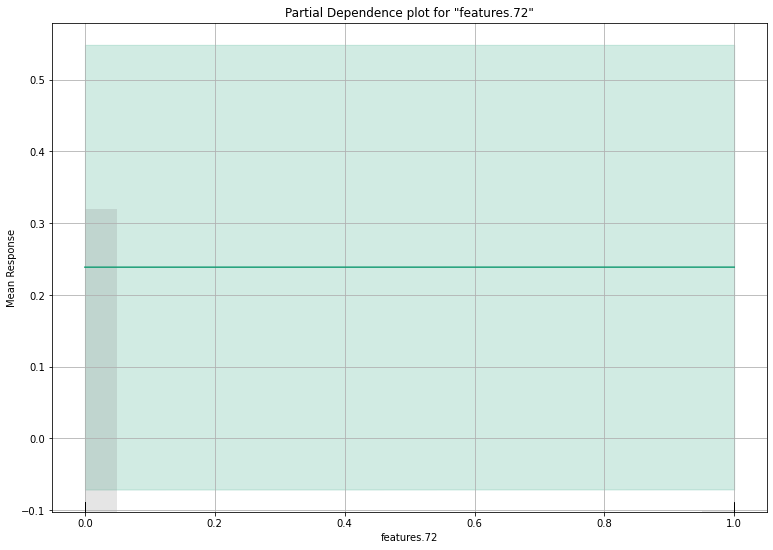

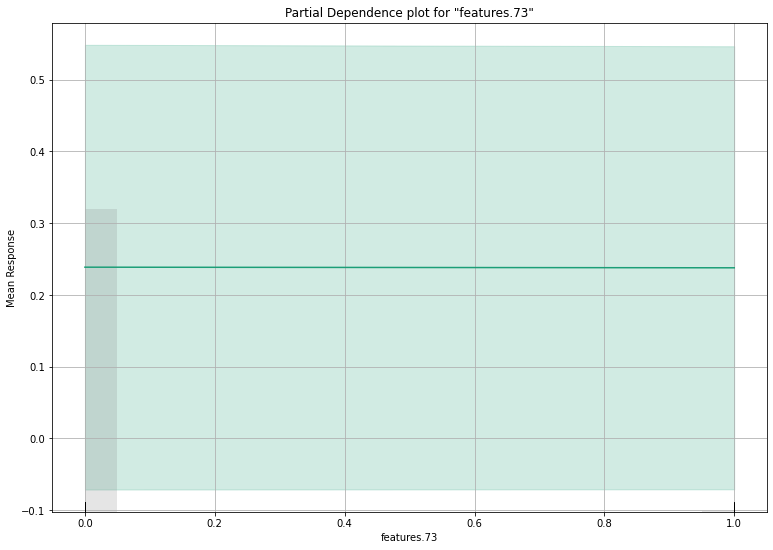

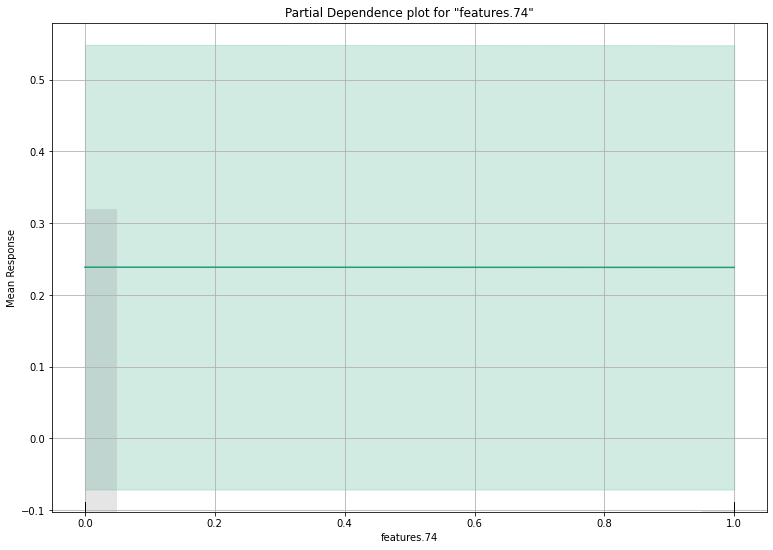

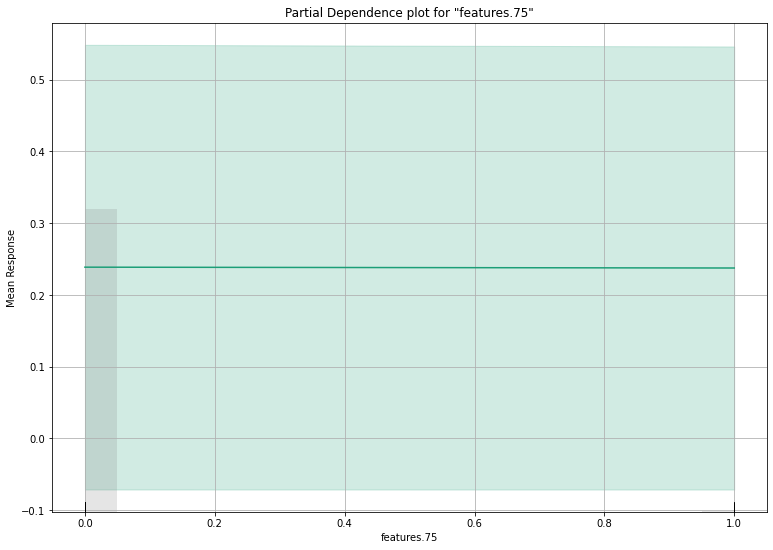

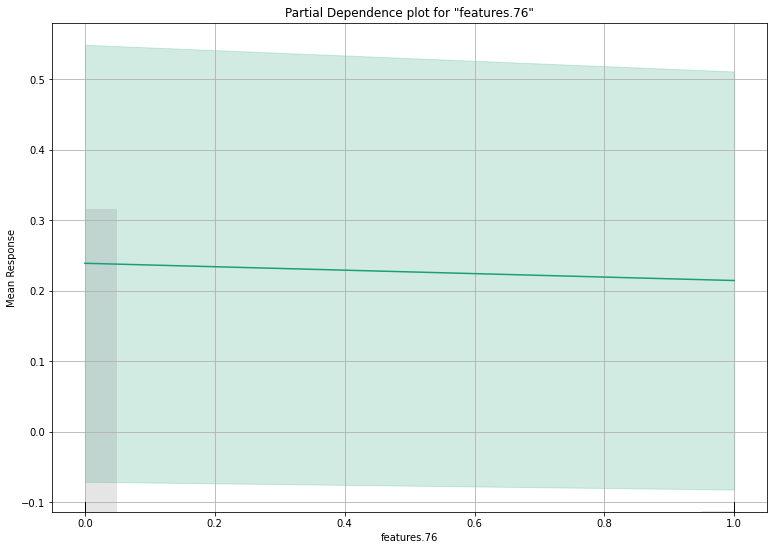

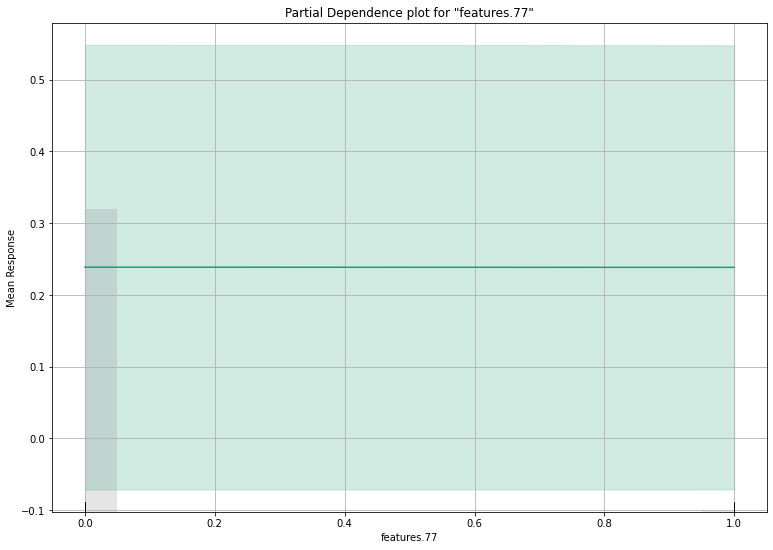

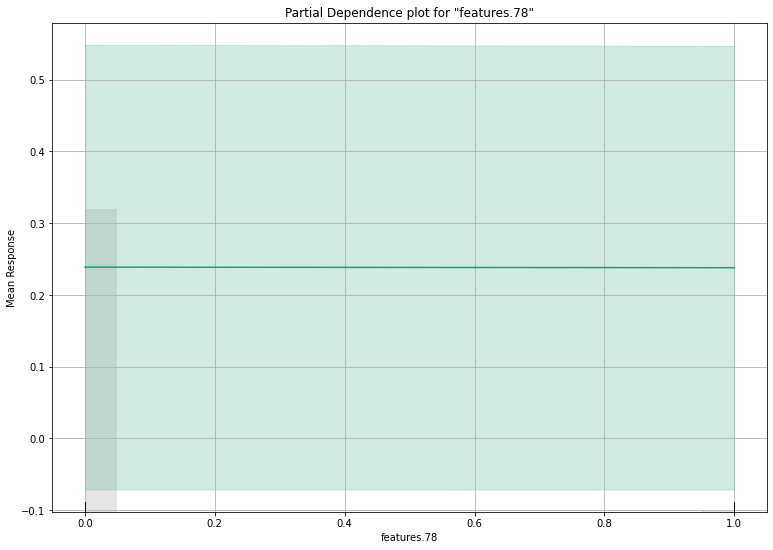

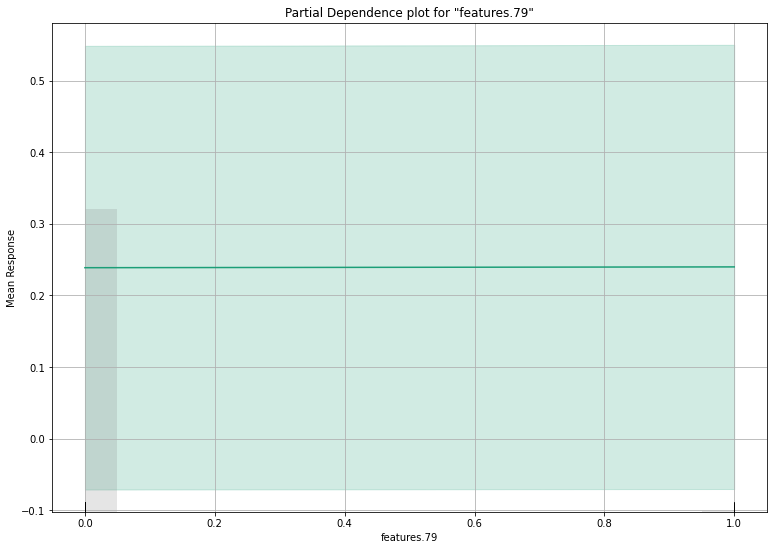

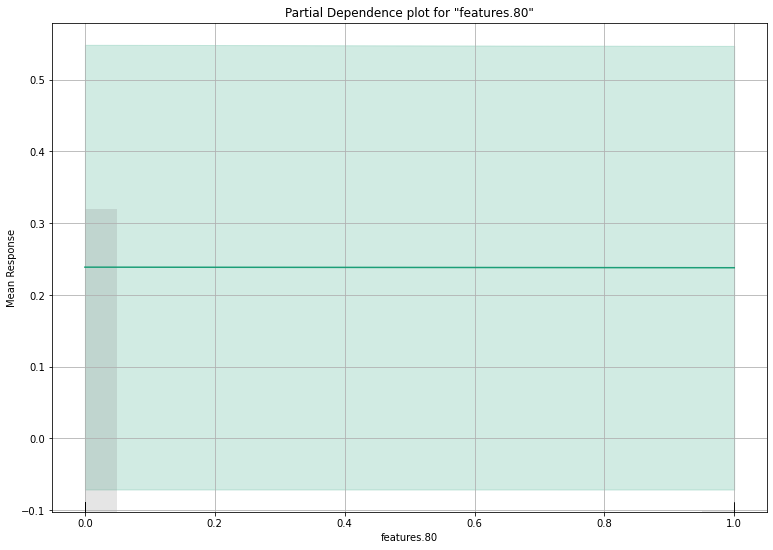

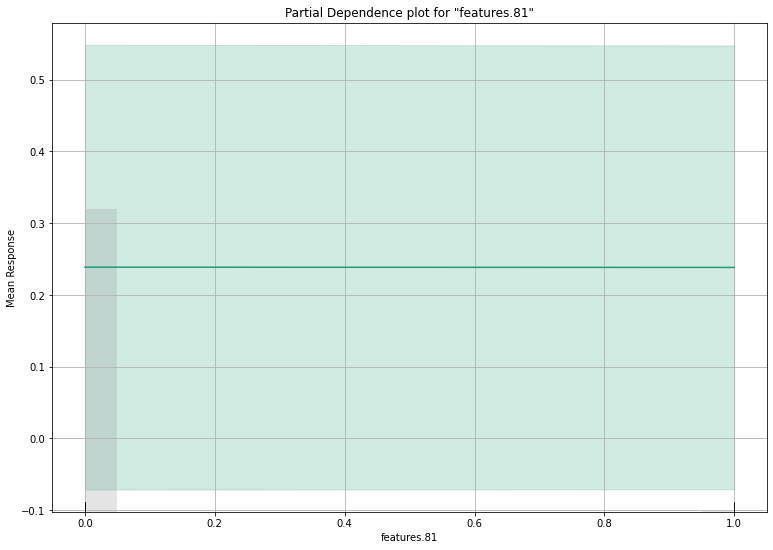

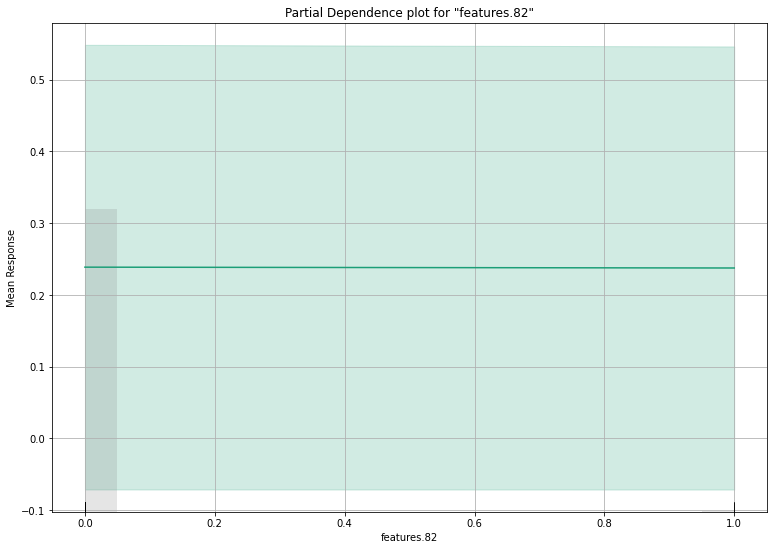

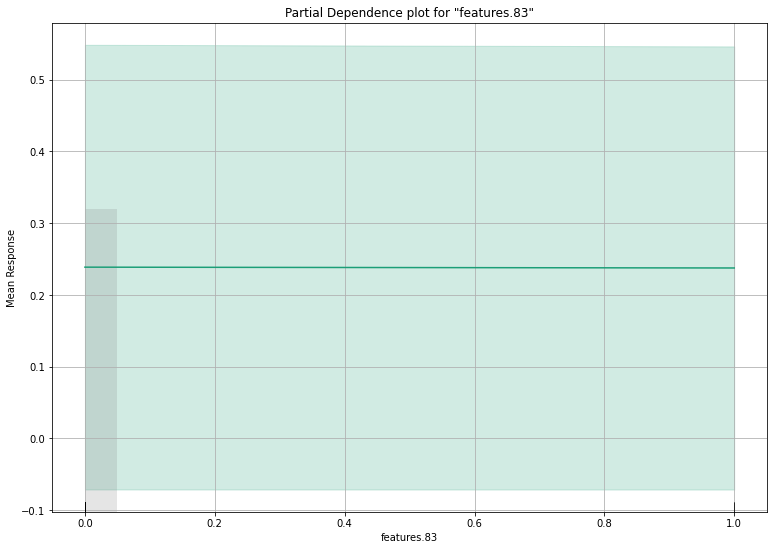

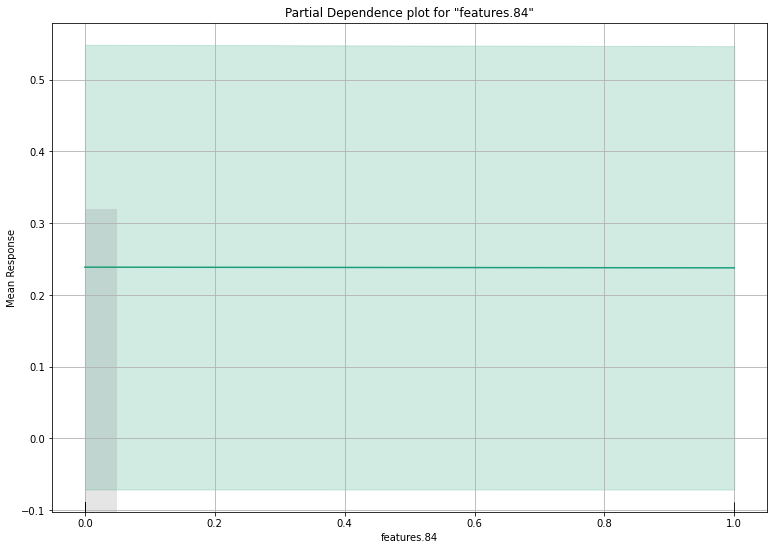

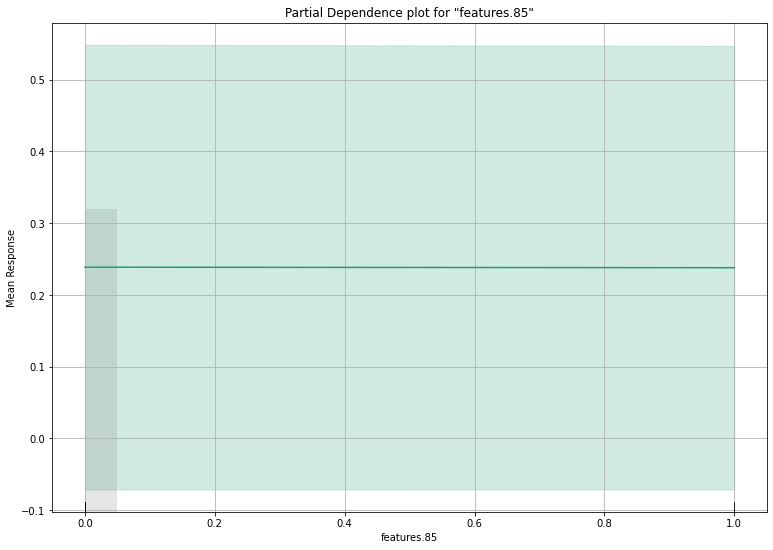

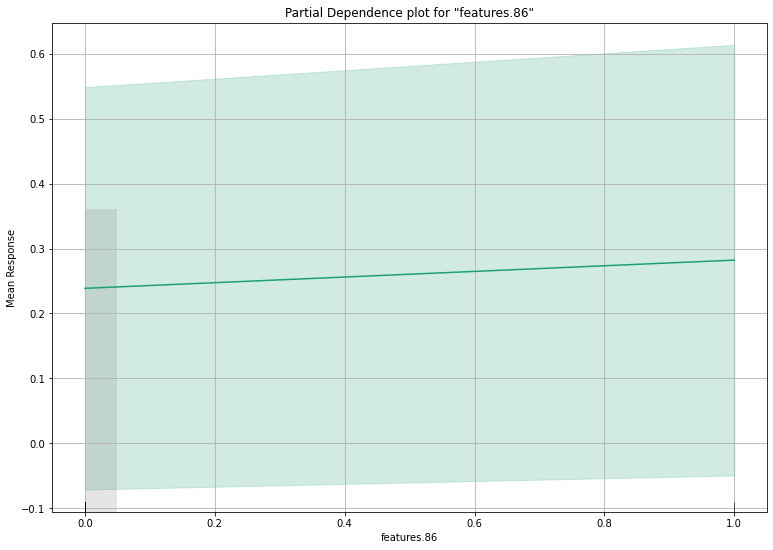

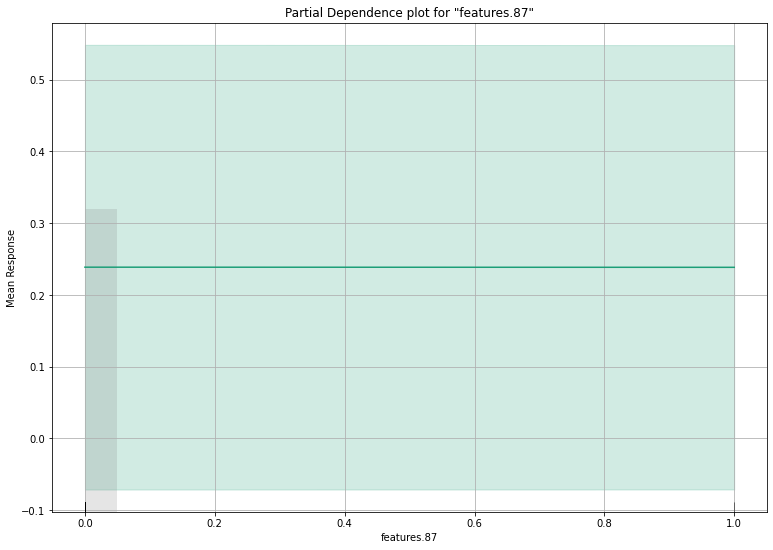

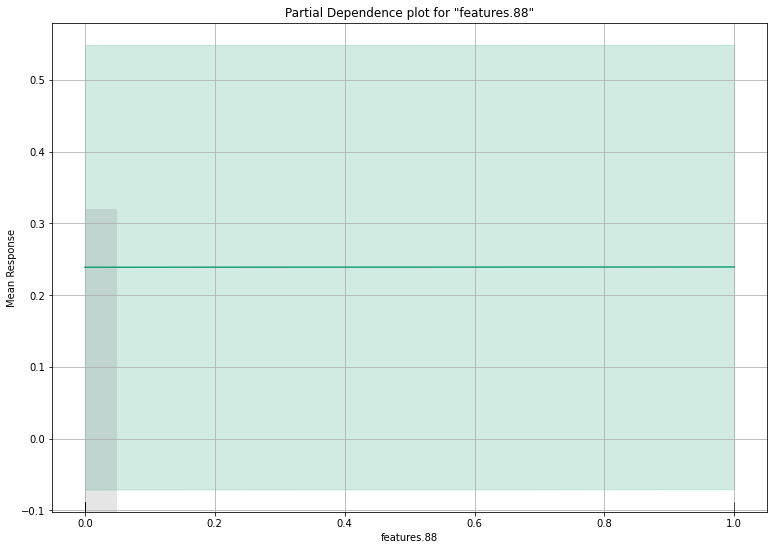

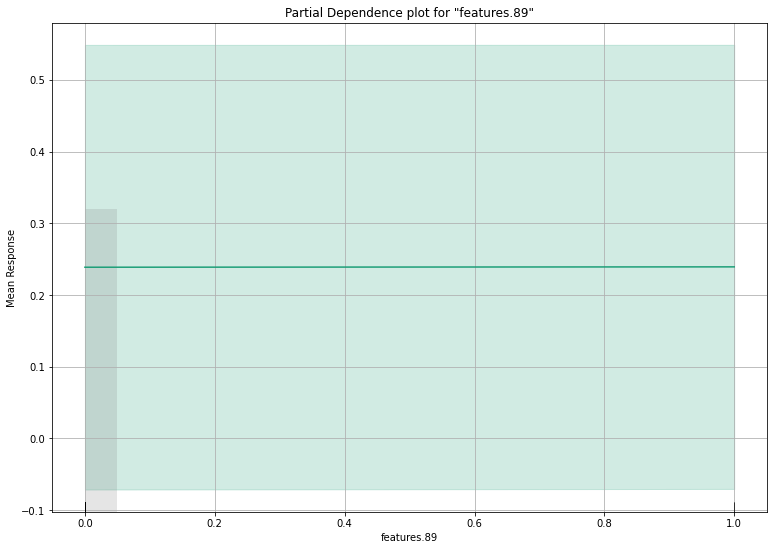

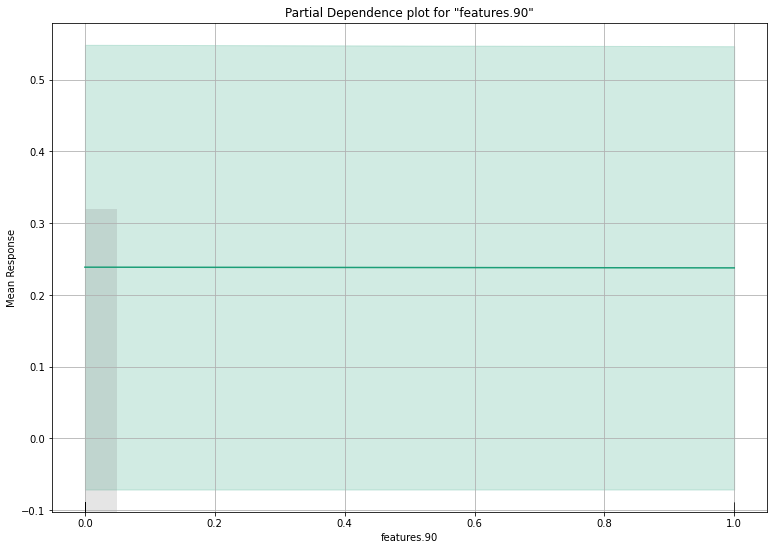

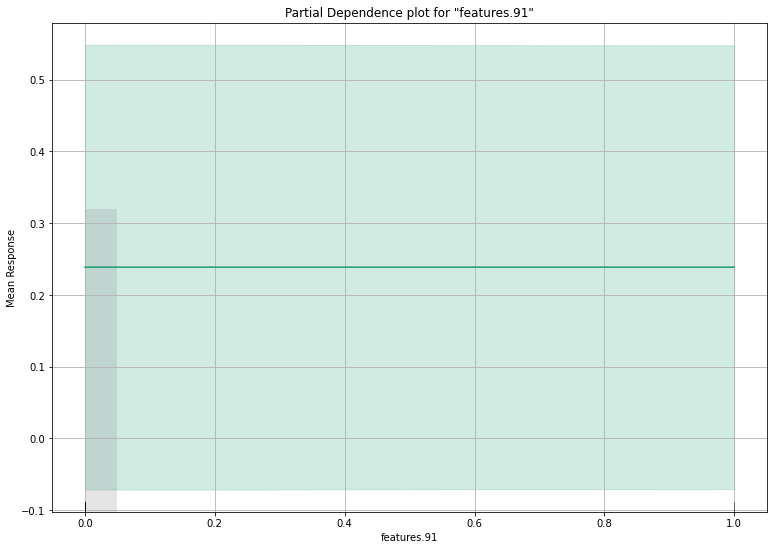

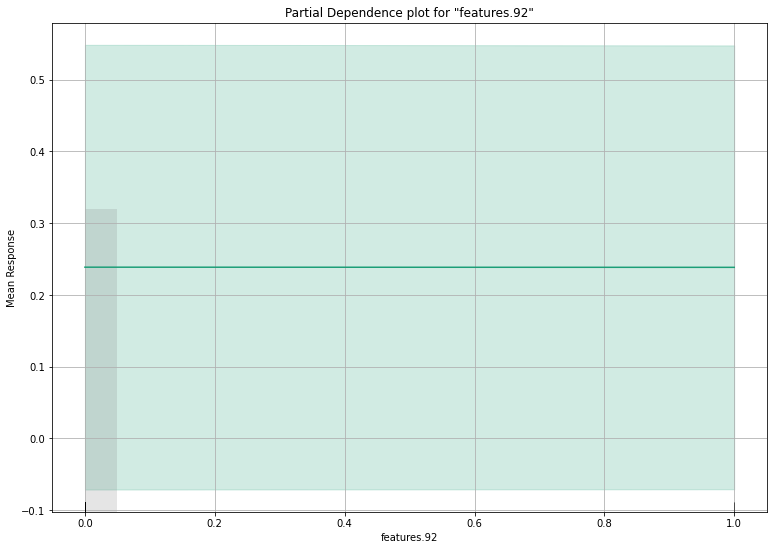

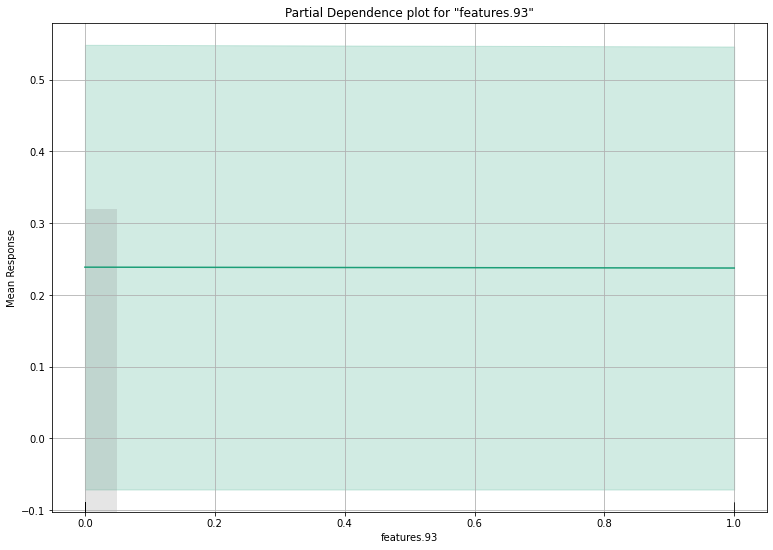

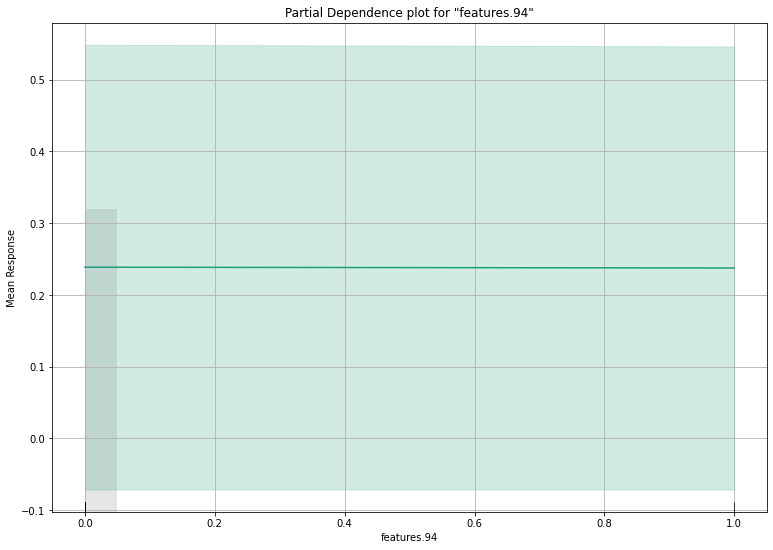

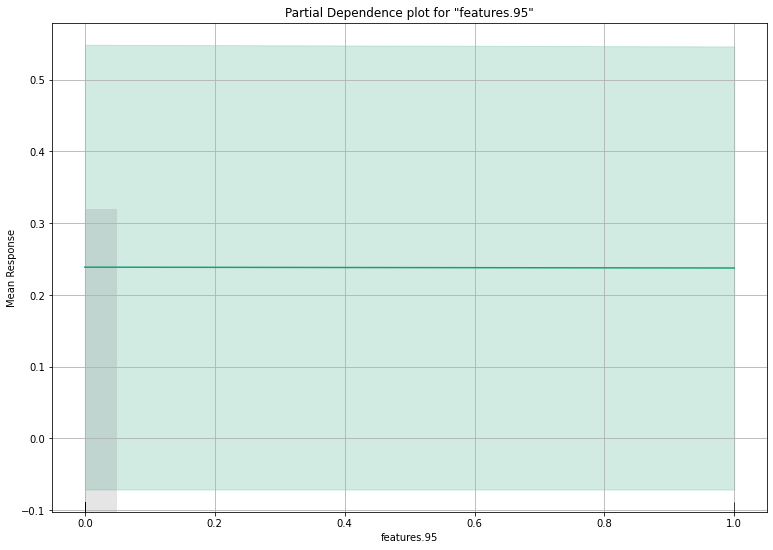

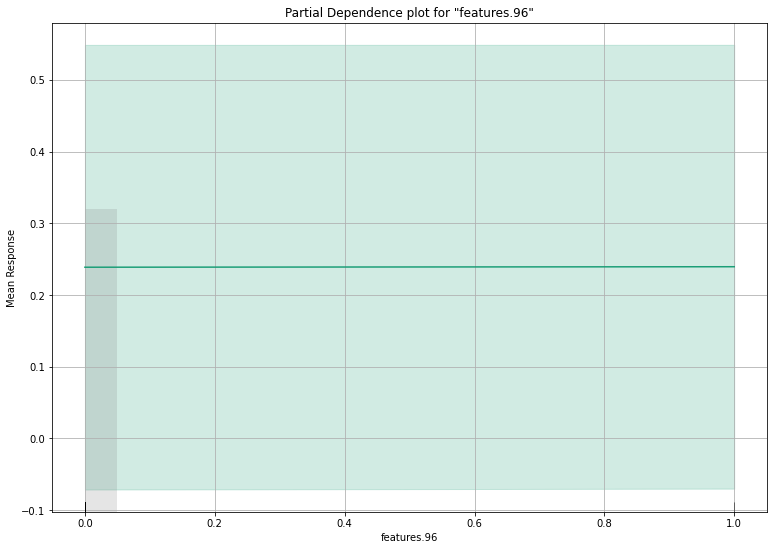

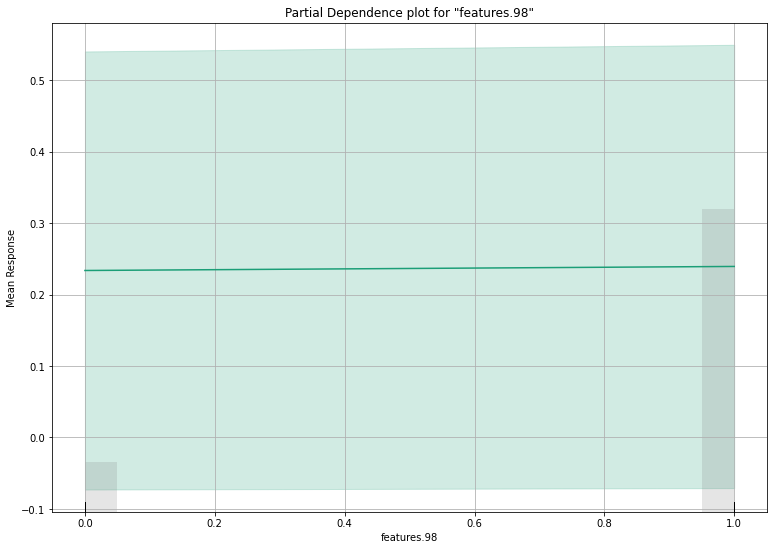

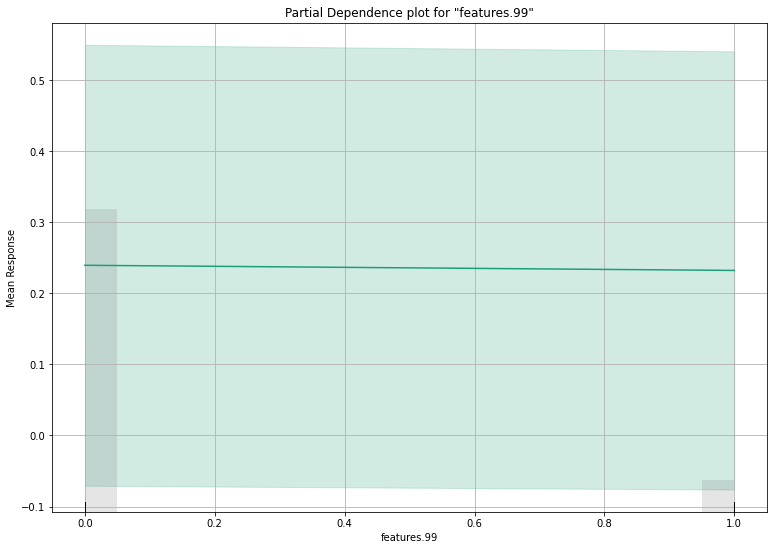

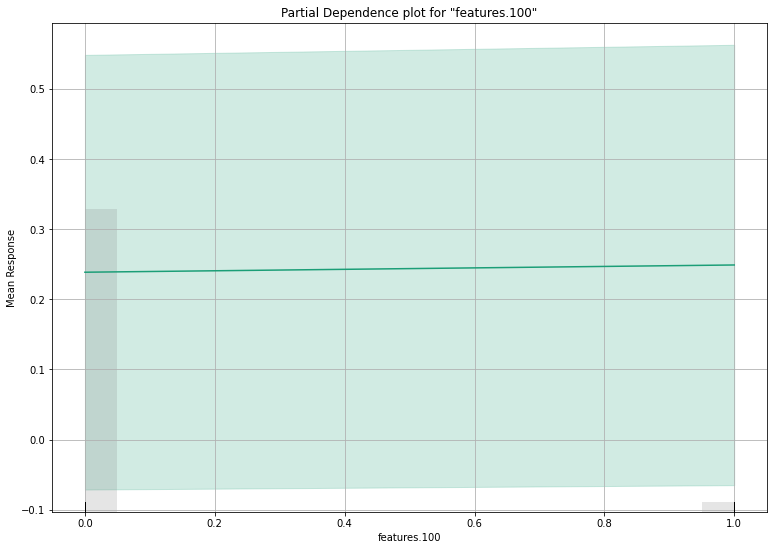

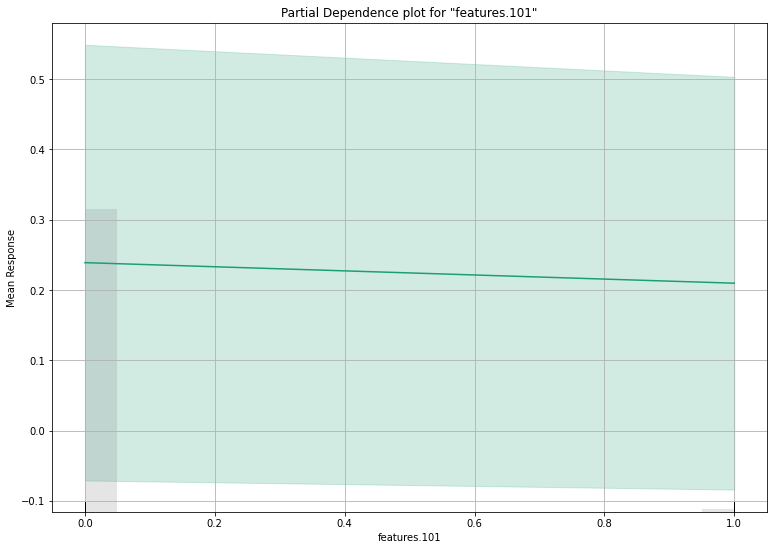

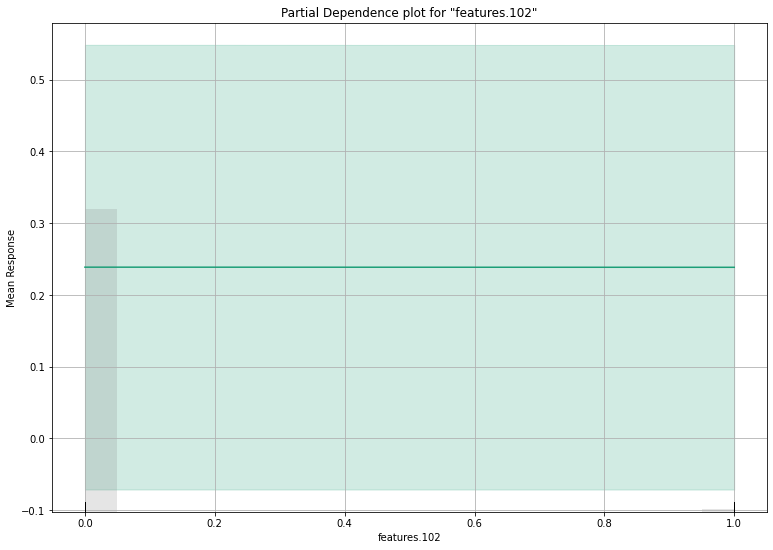

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_model_python_1614444570335_550


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.260474448131263: 


,,0,1,Error,Rate
0,0,6853.0,840.0,0.1092,(840.0/7693.0)
1,1,451.0,1961.0,0.187,(451.0/2412.0)
2,Total,7304.0,2801.0,0.1278,(1291.0/10105.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

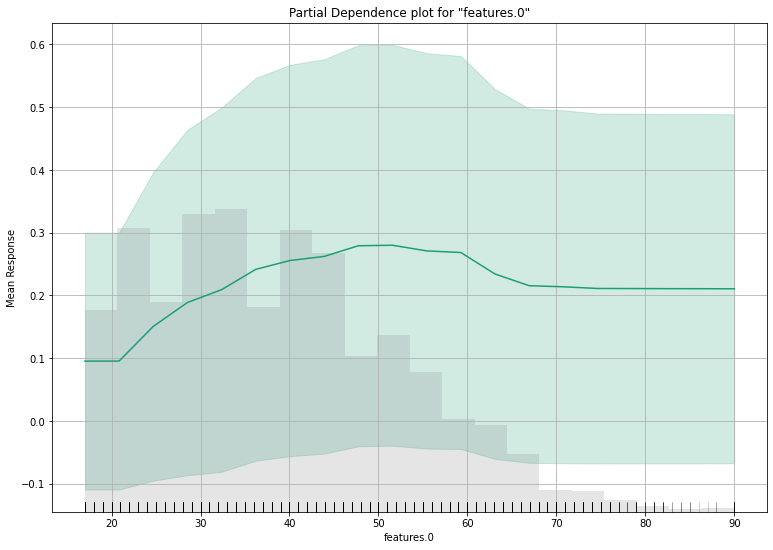

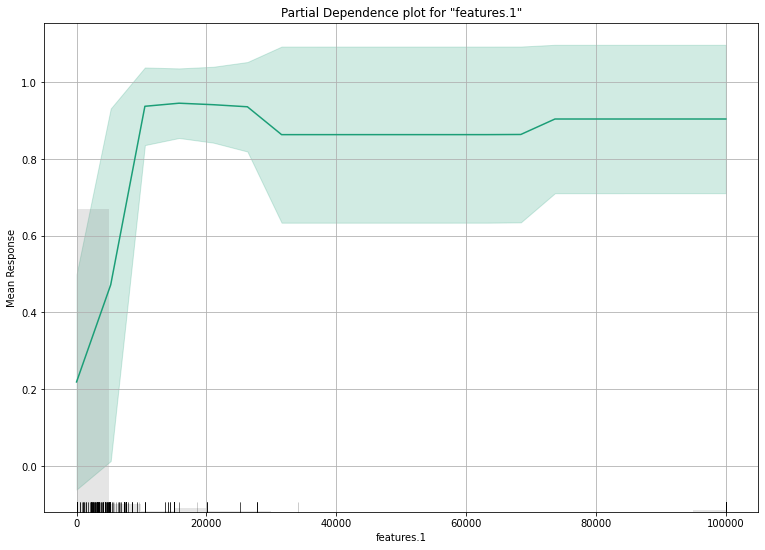

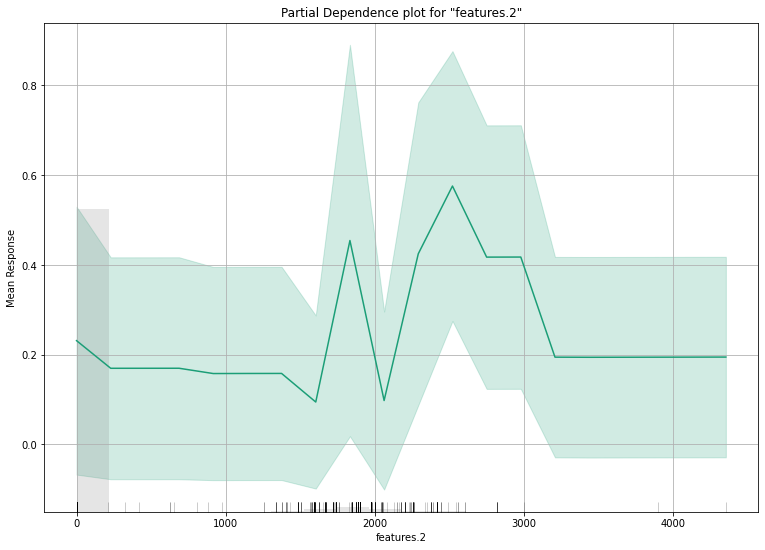

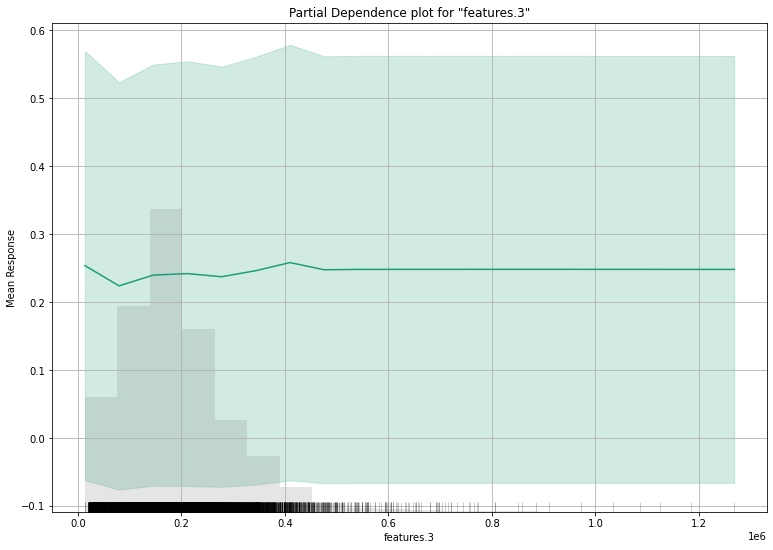

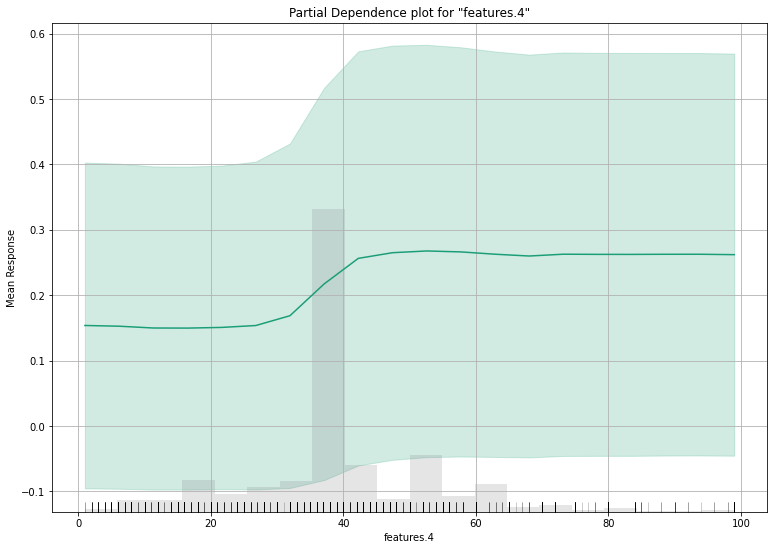

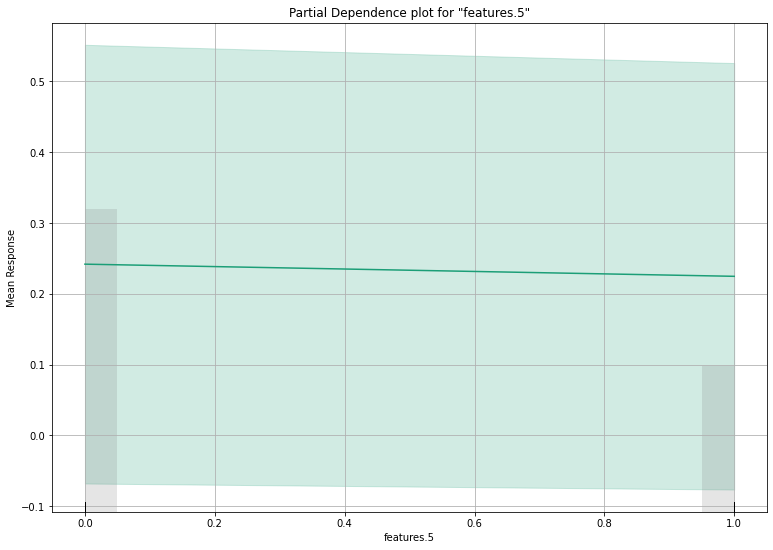

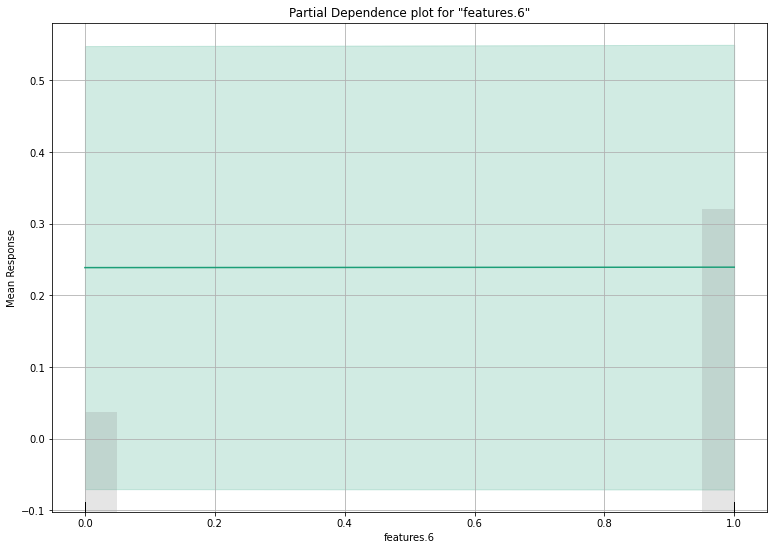

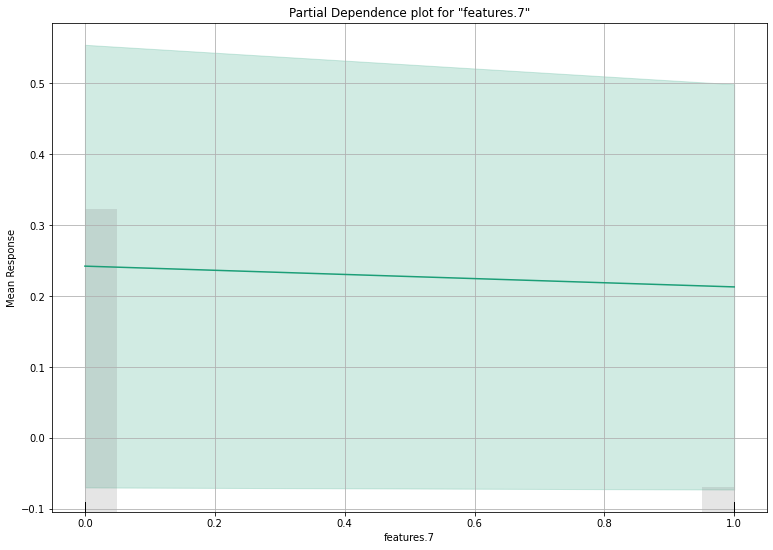

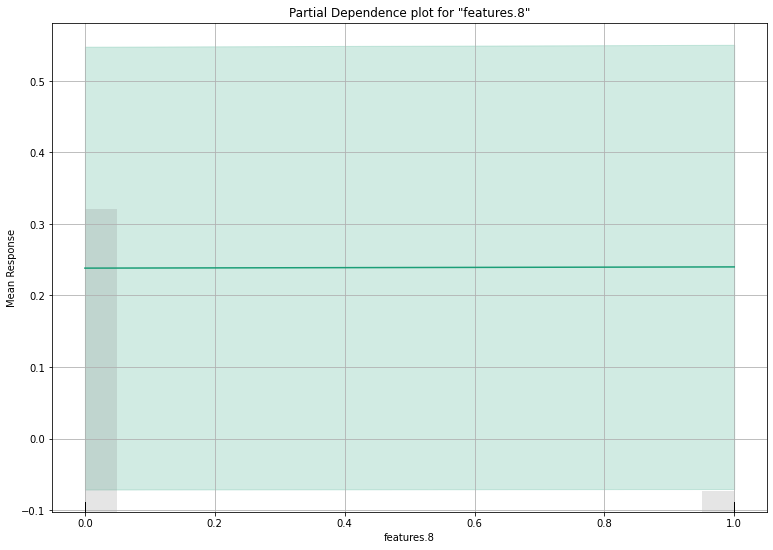

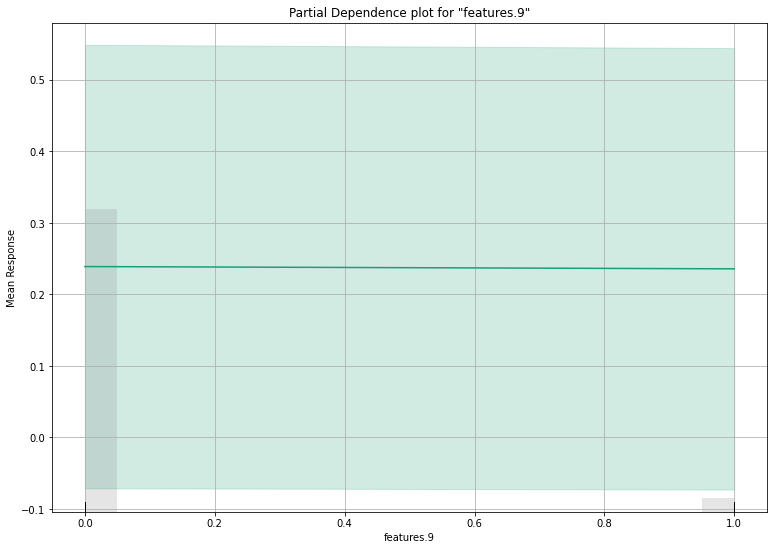

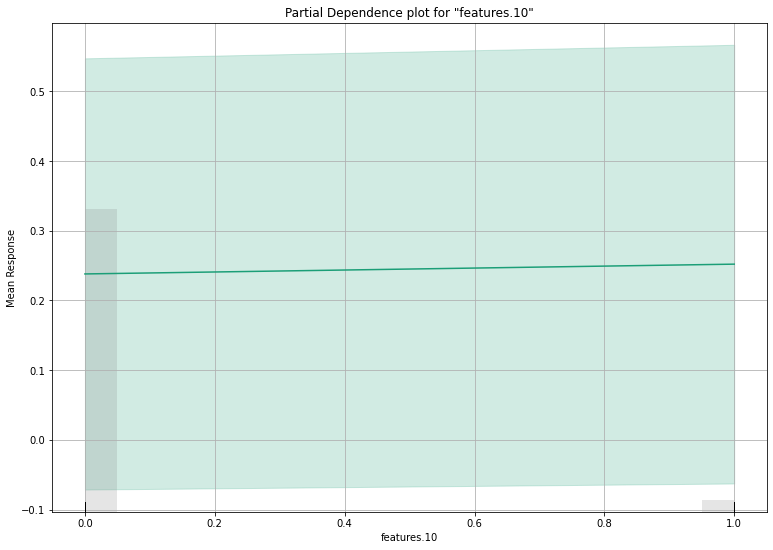

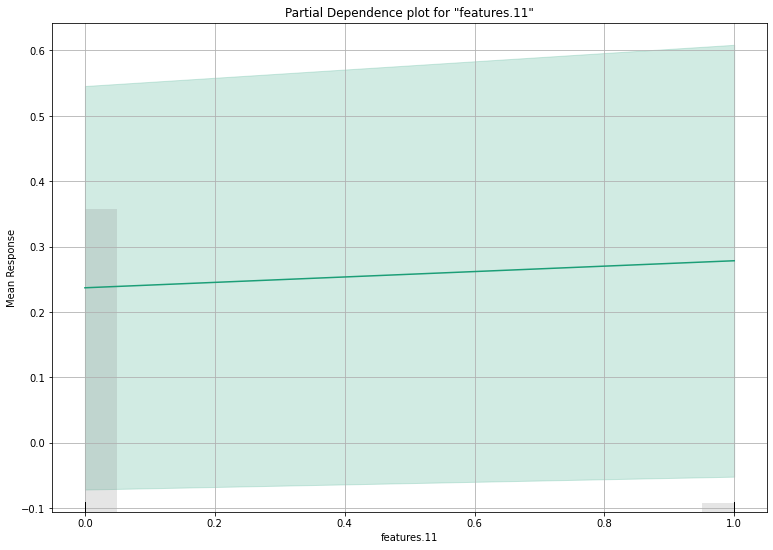

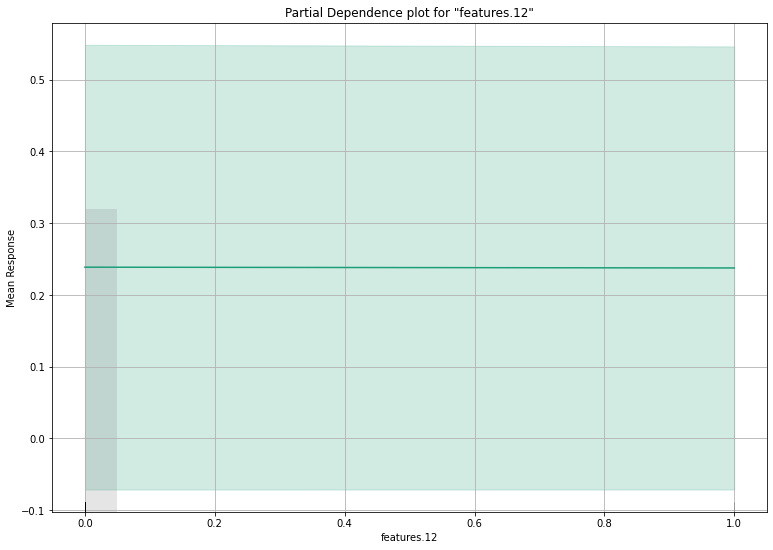

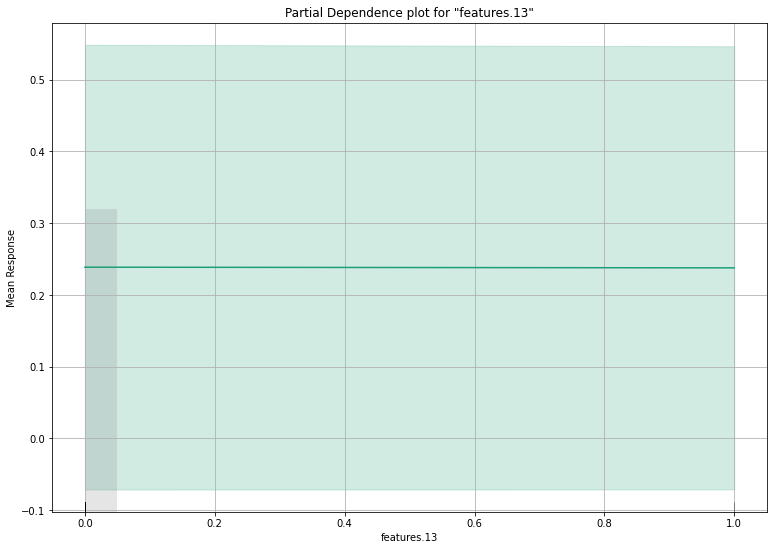

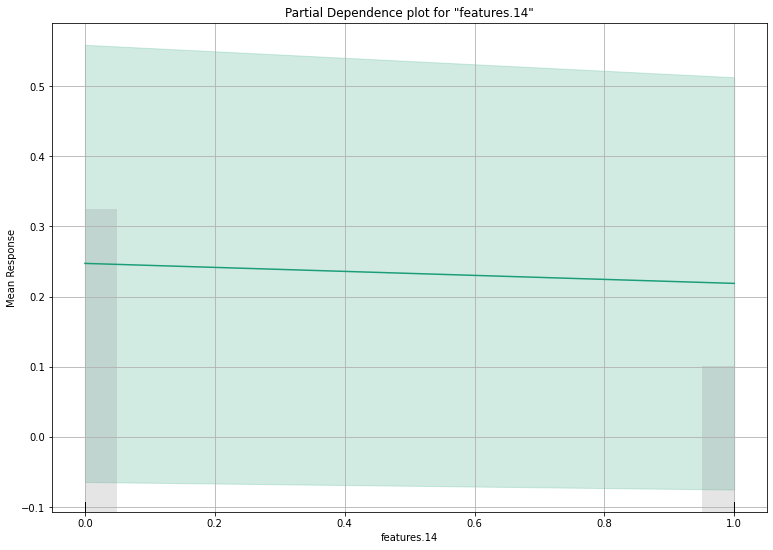

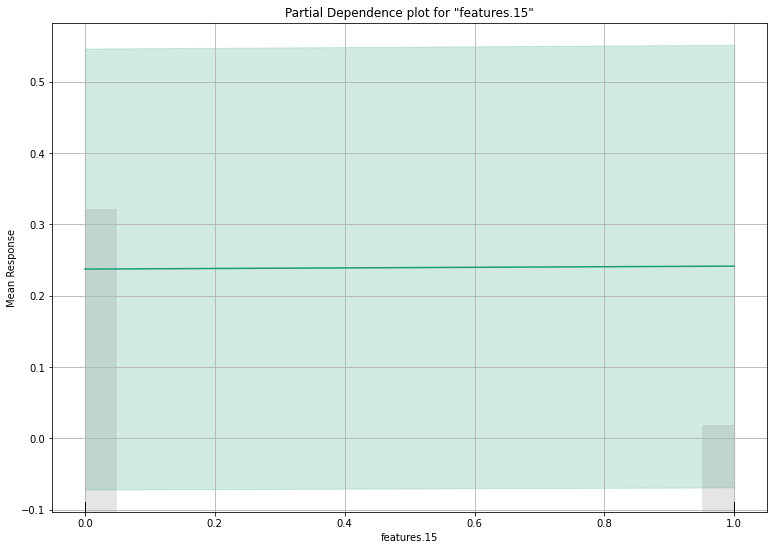

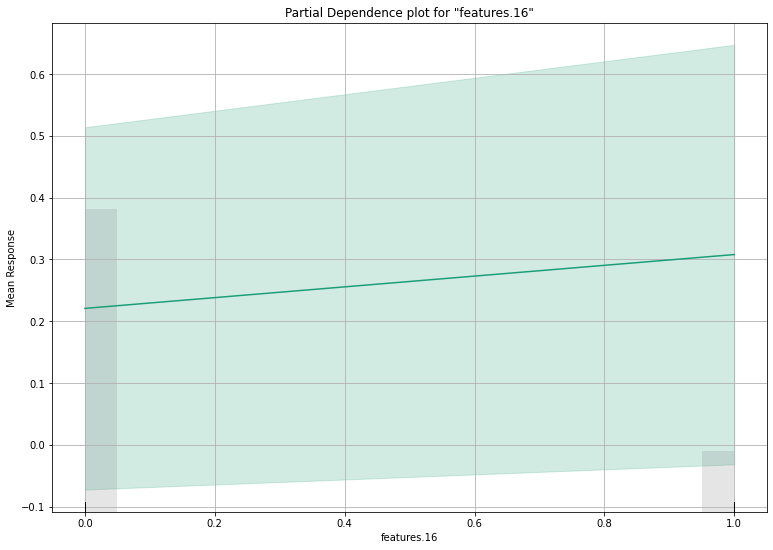

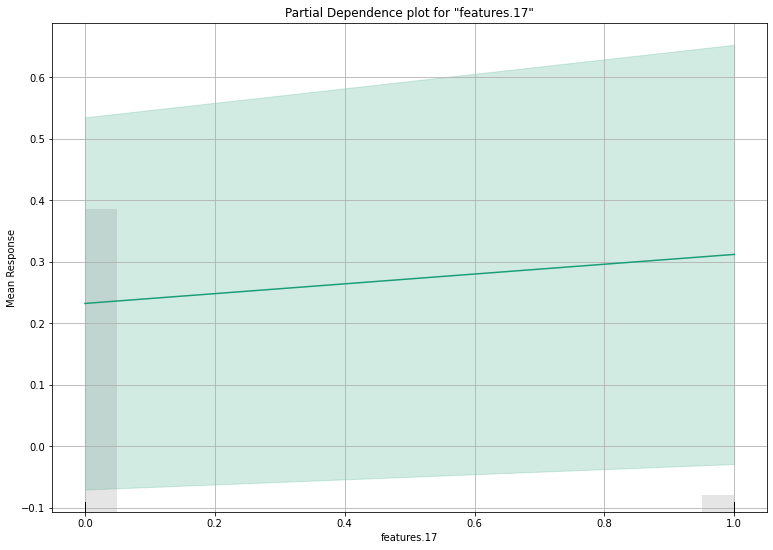

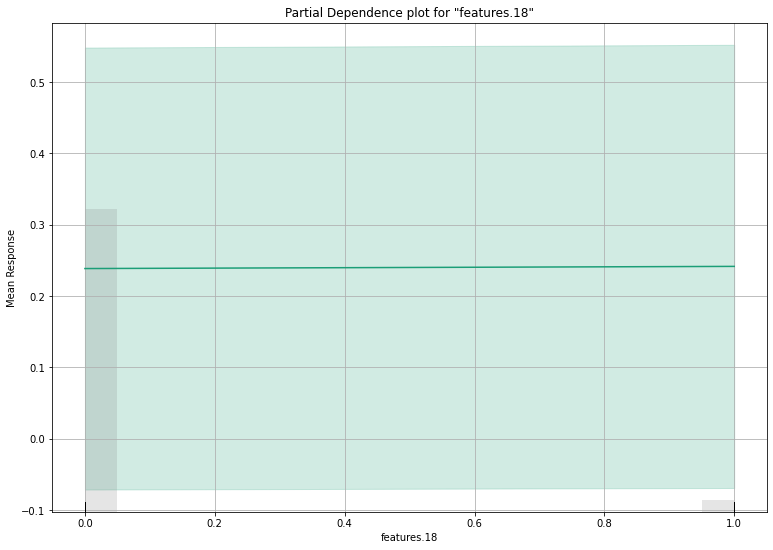

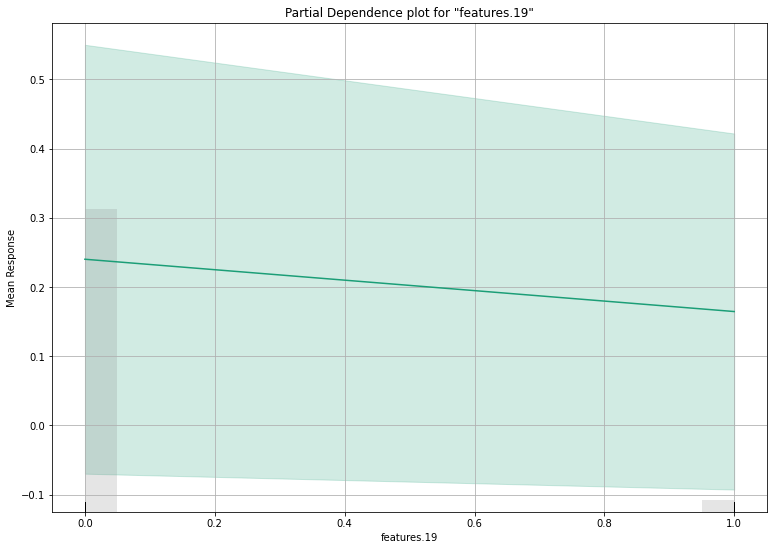

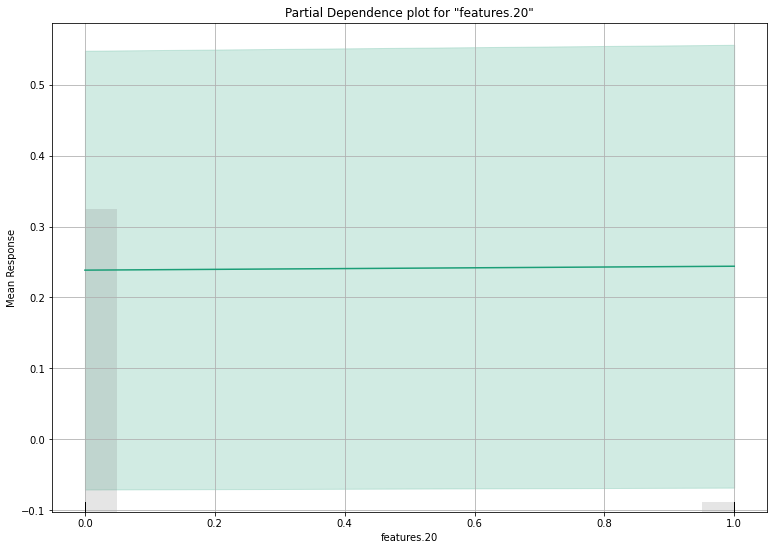

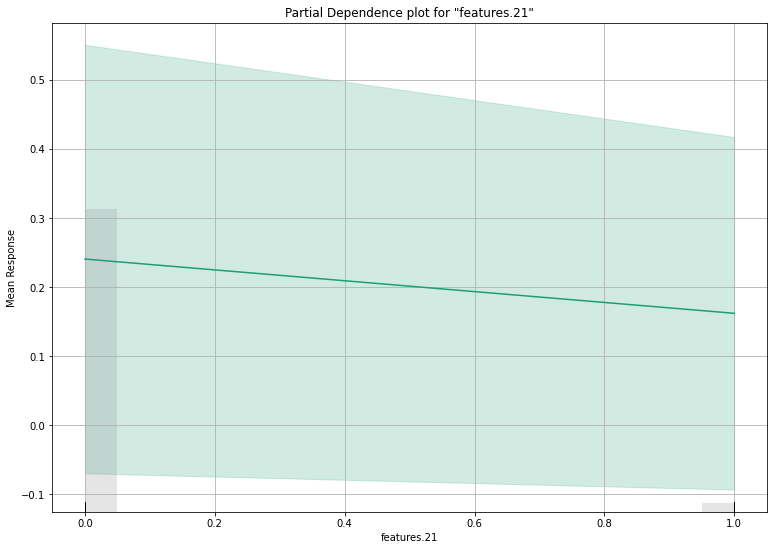

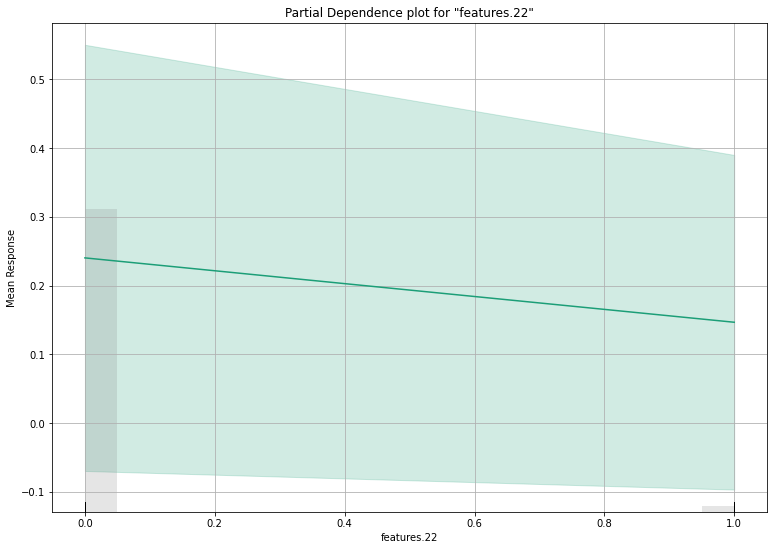

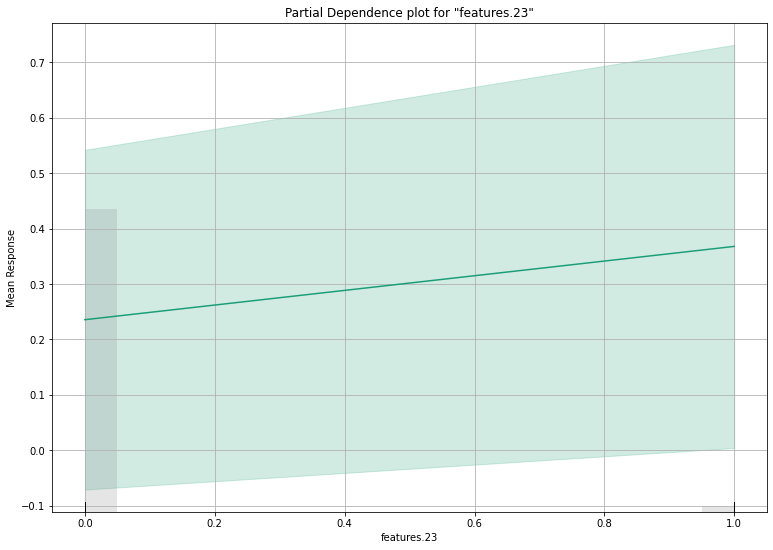

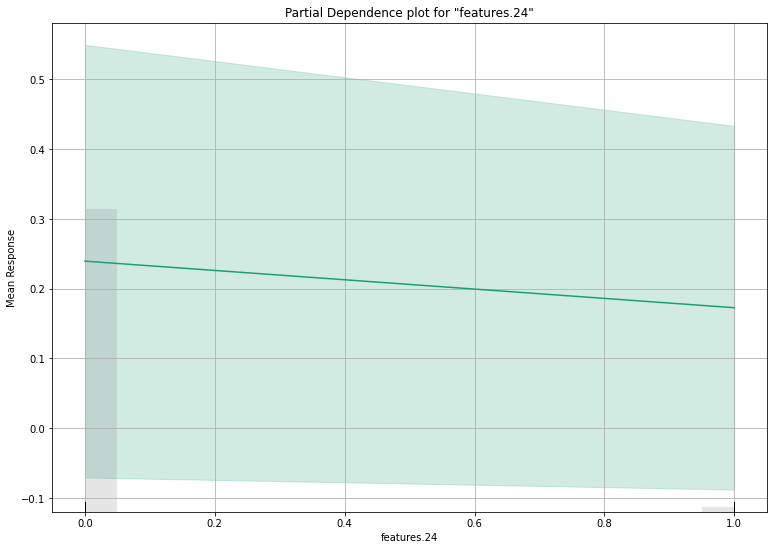

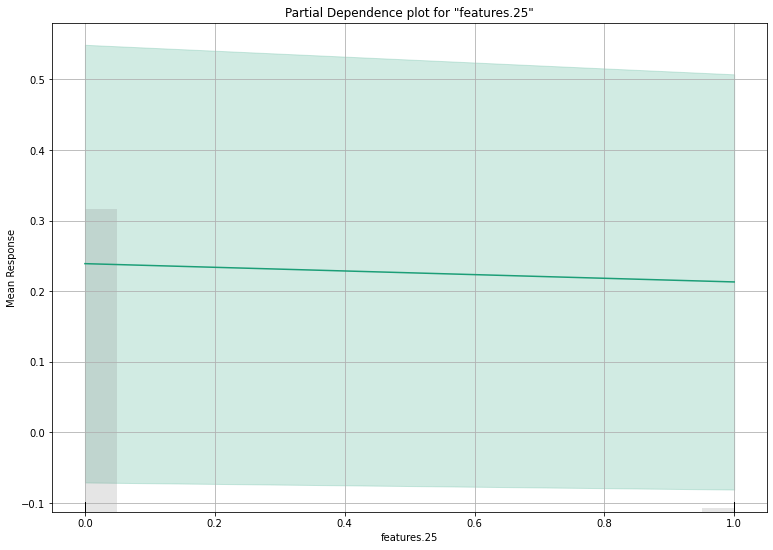

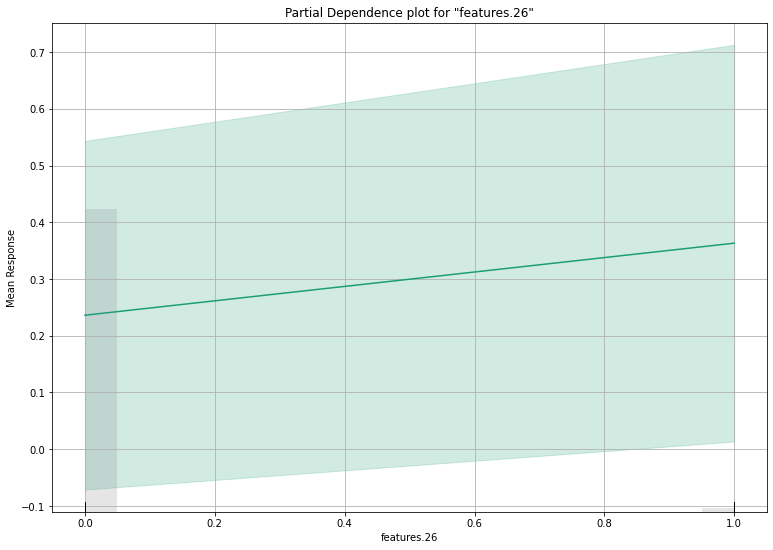

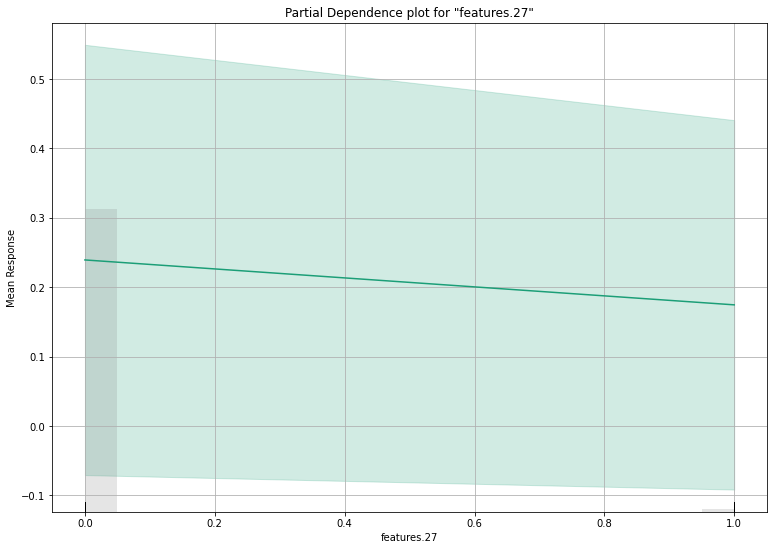

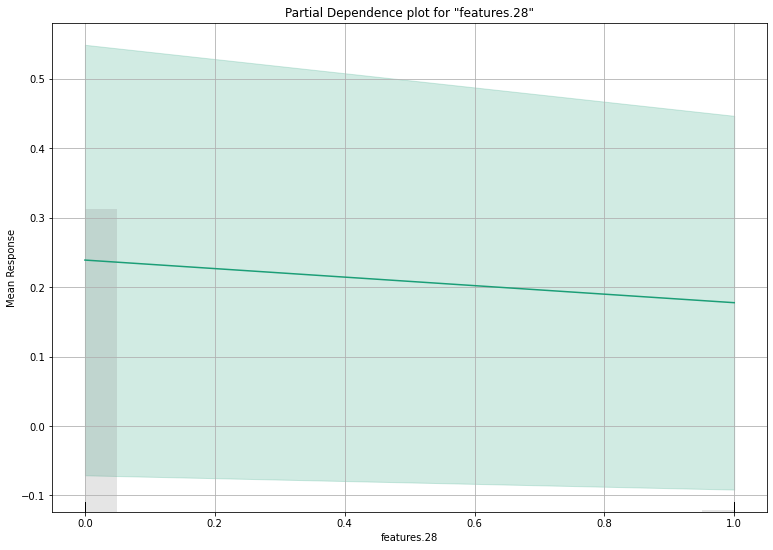

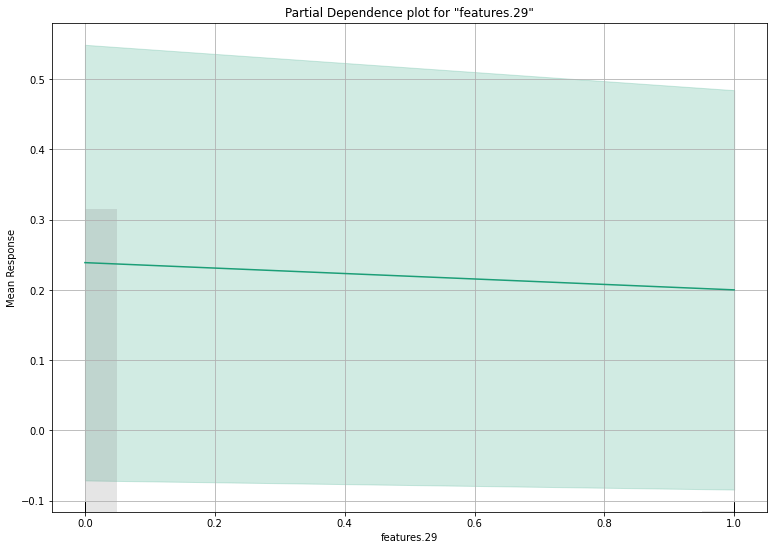

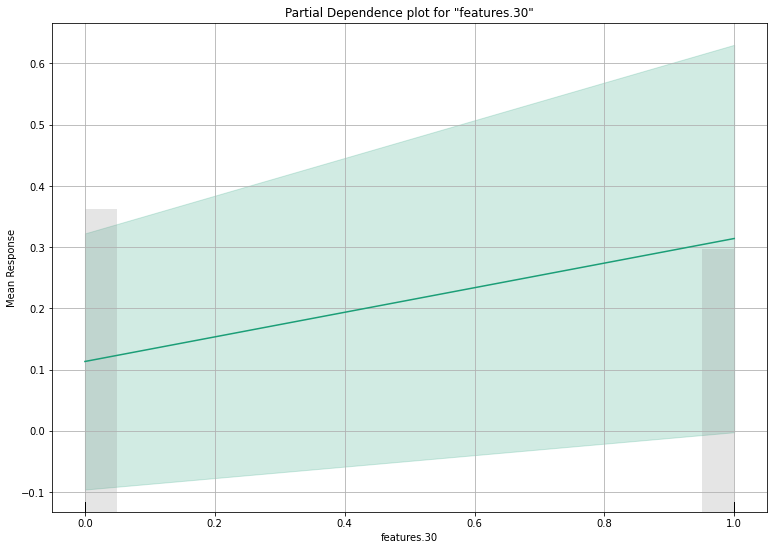

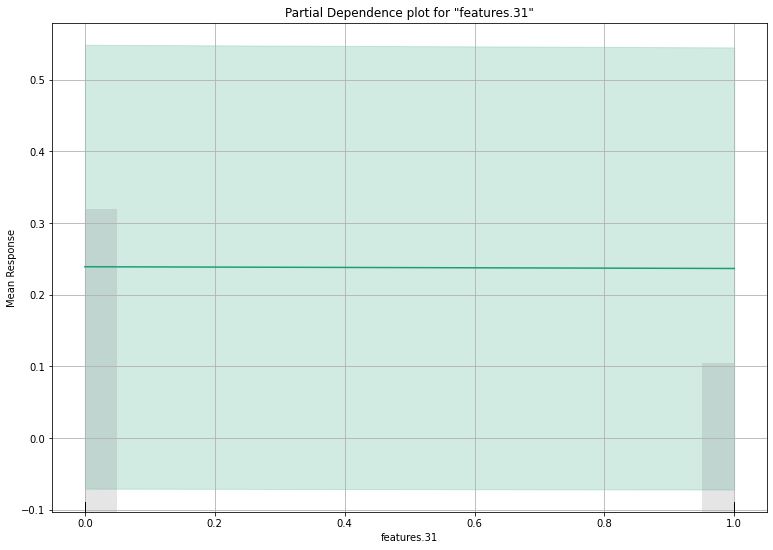

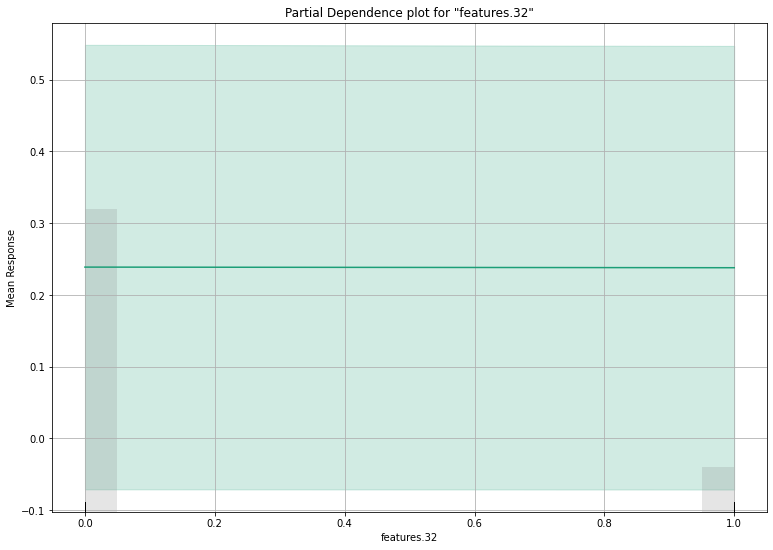

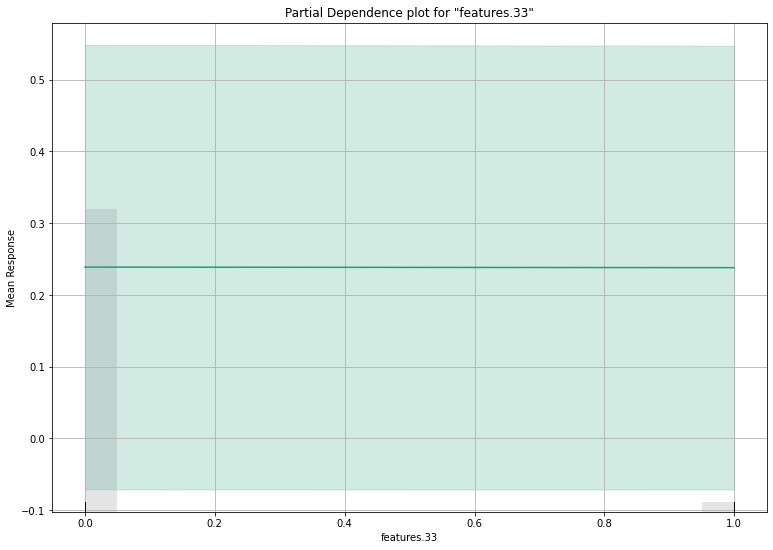

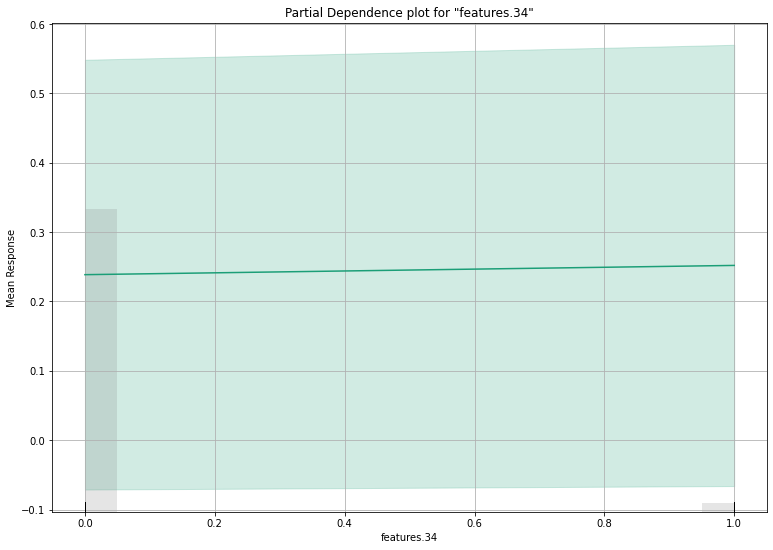

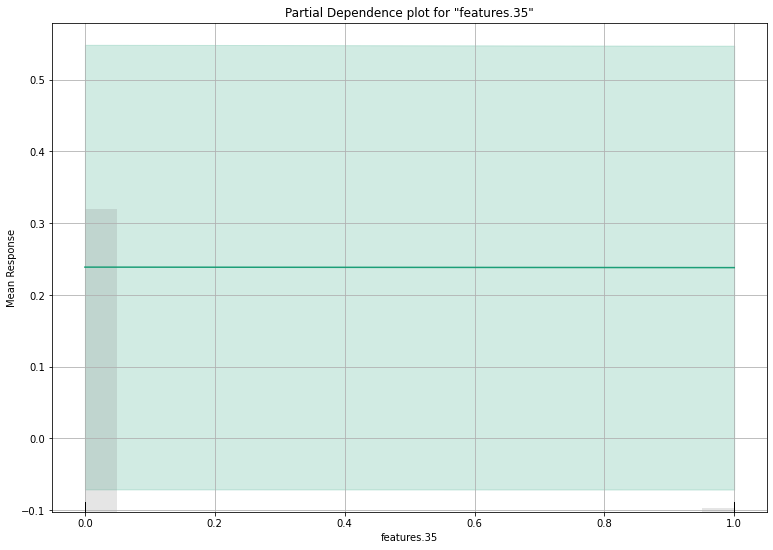

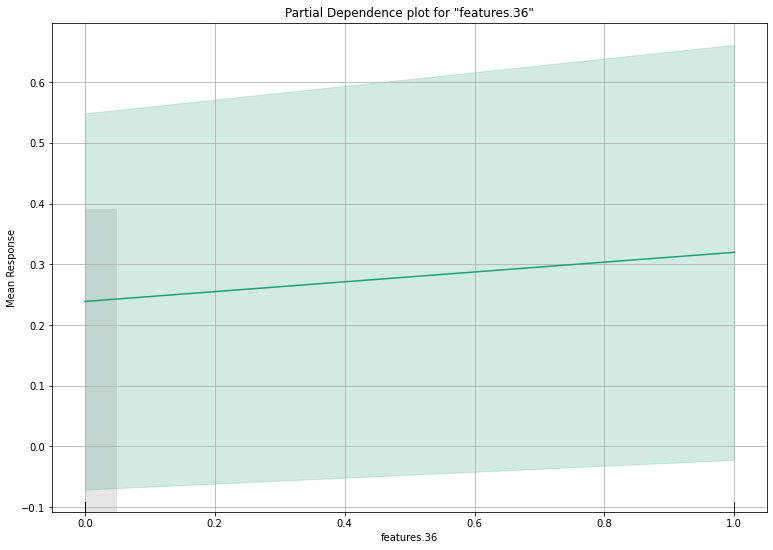

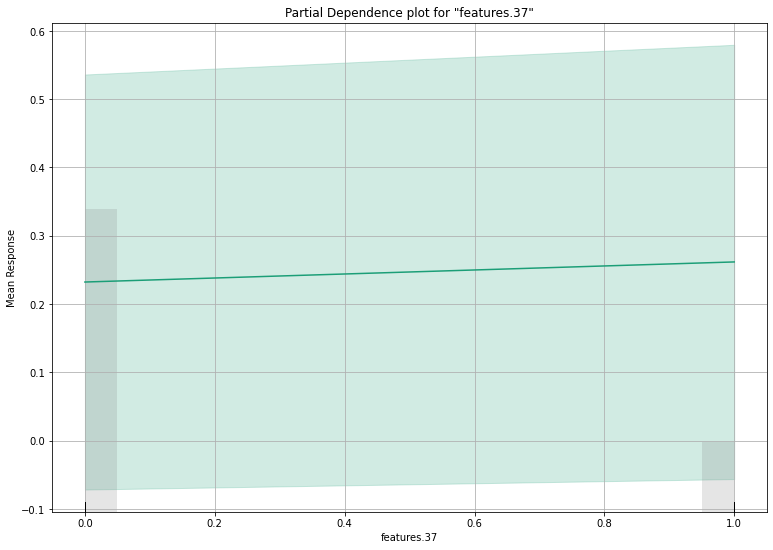

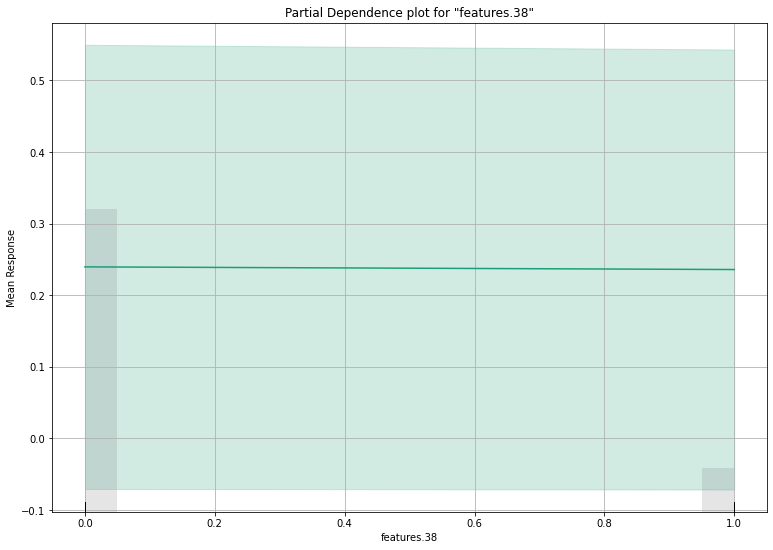

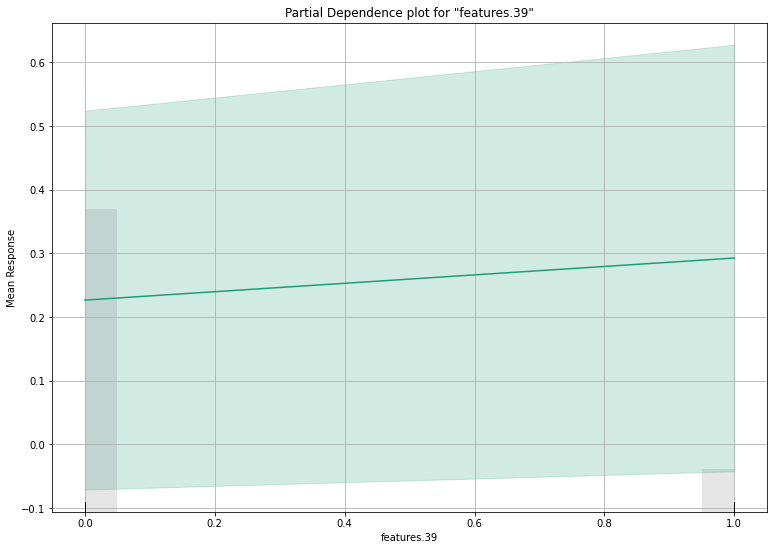

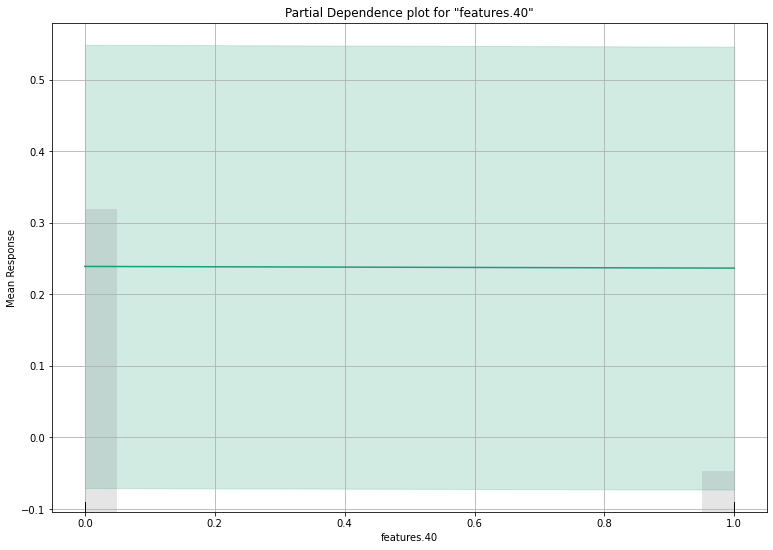

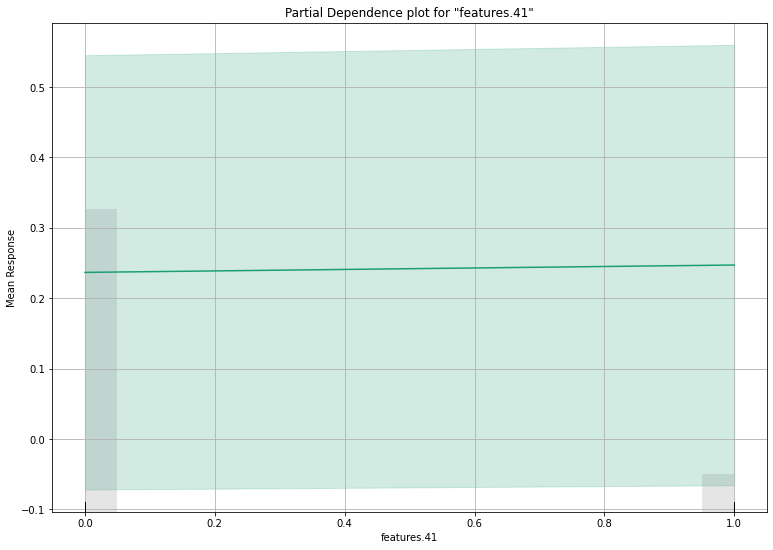

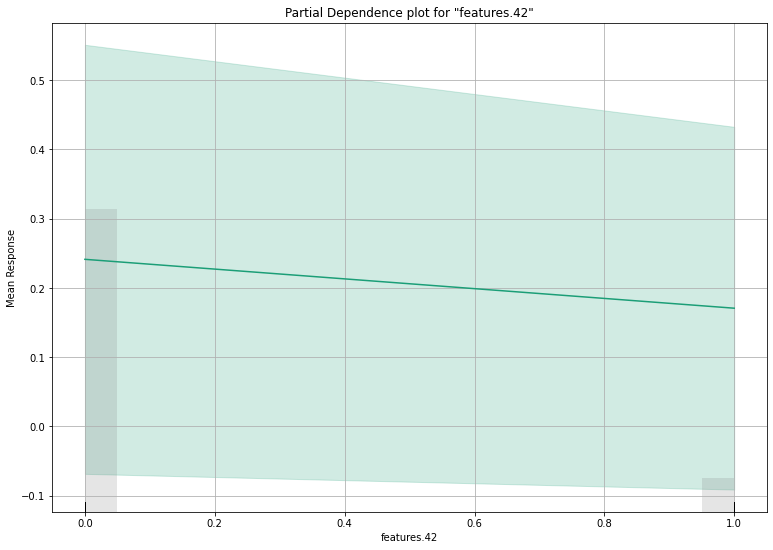

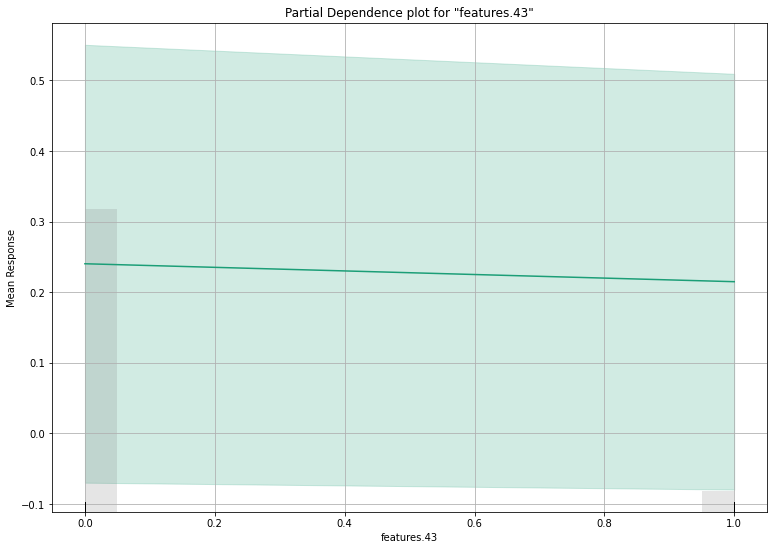

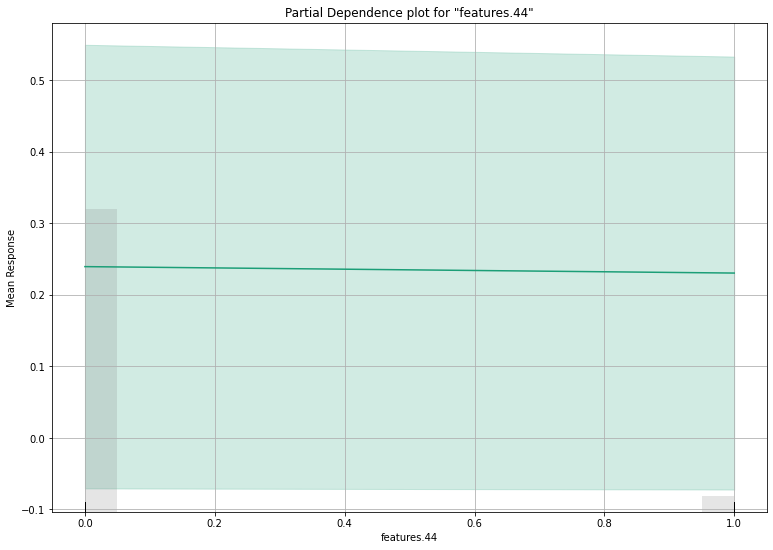

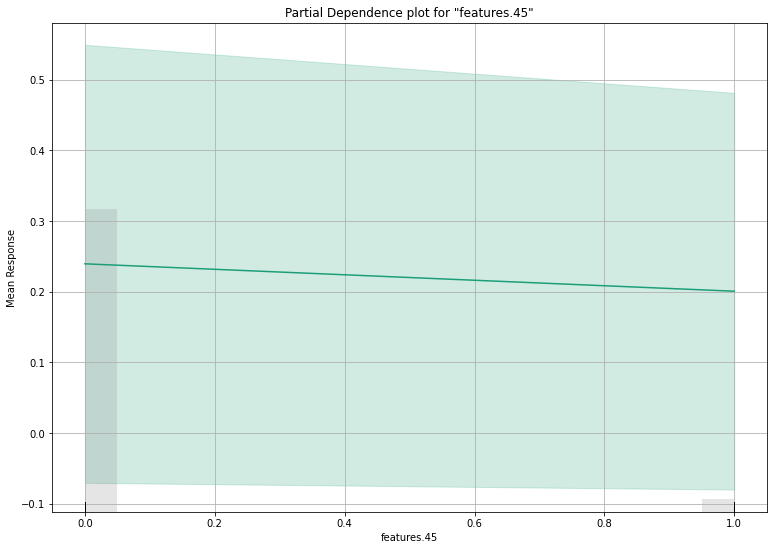

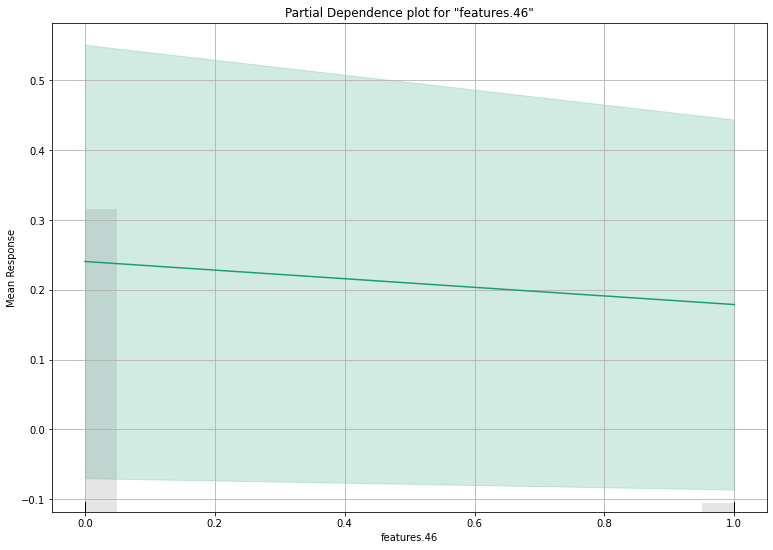

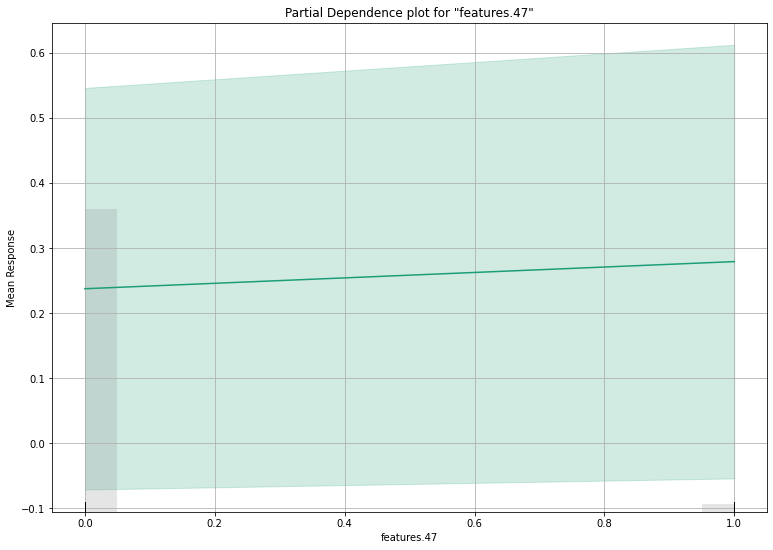

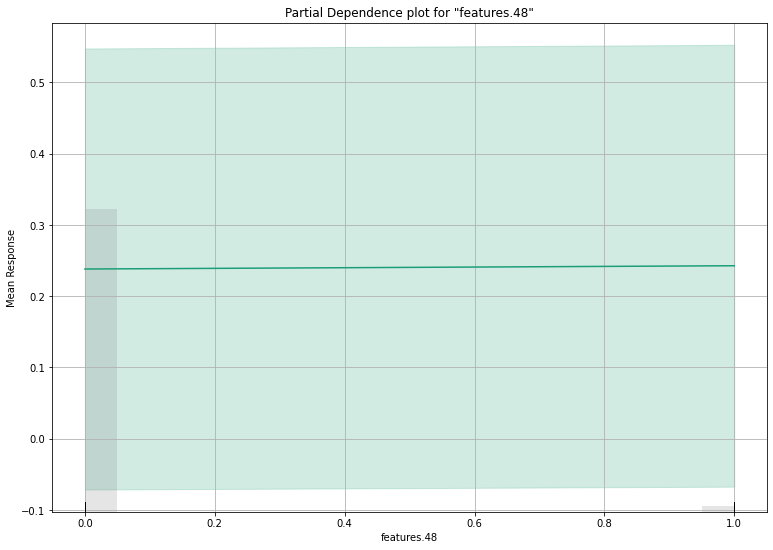

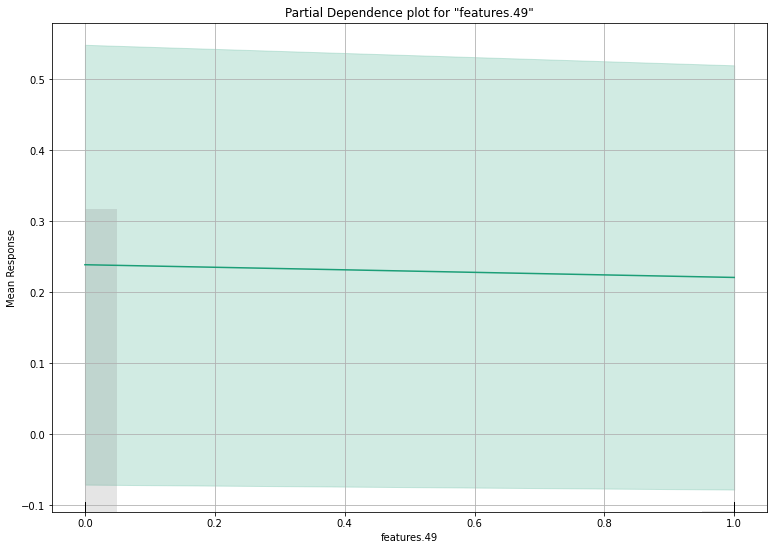

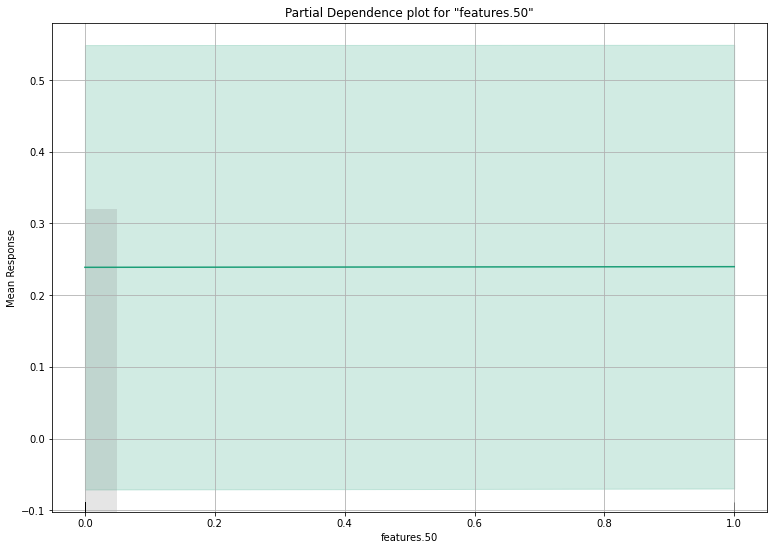

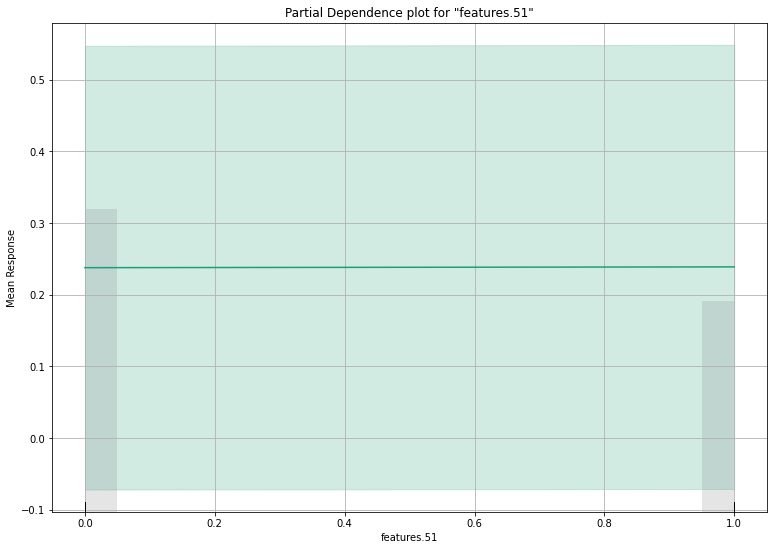

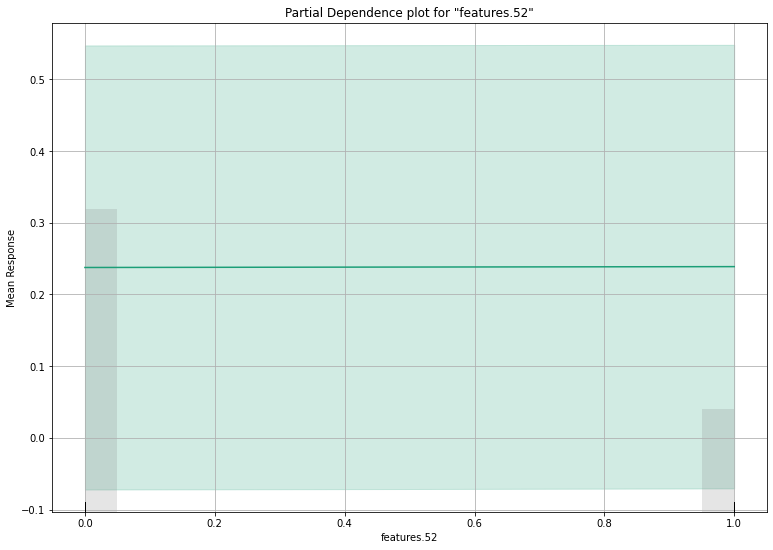

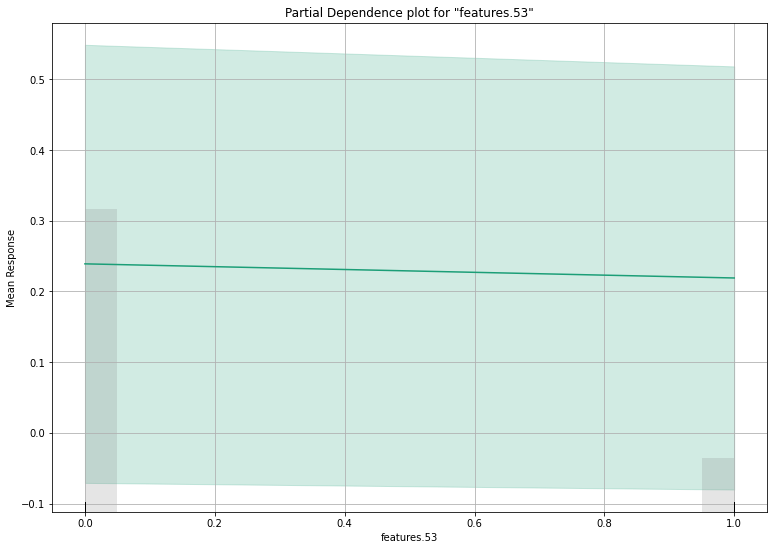

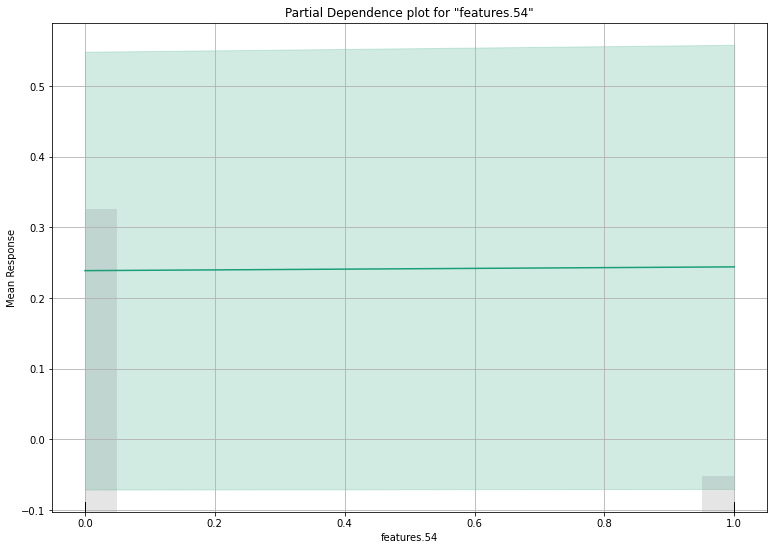

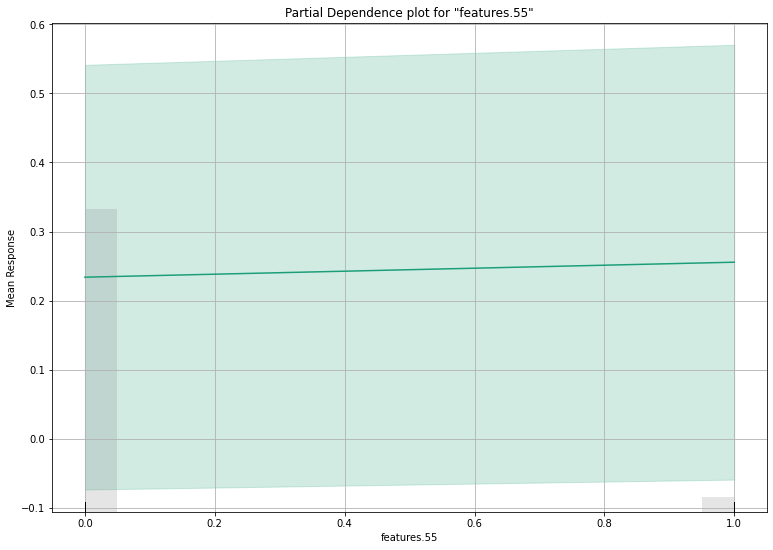

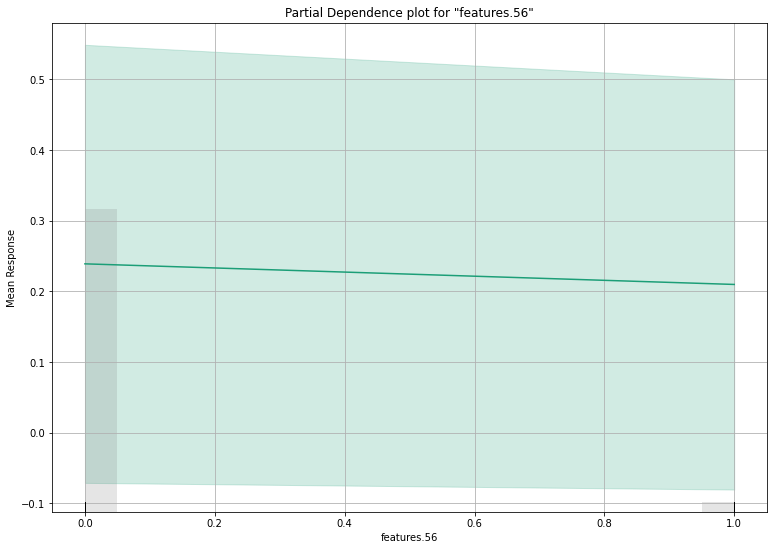

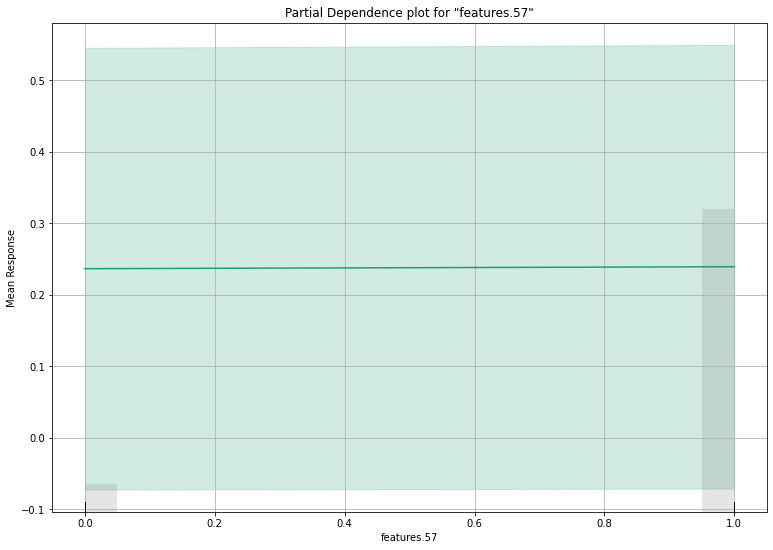

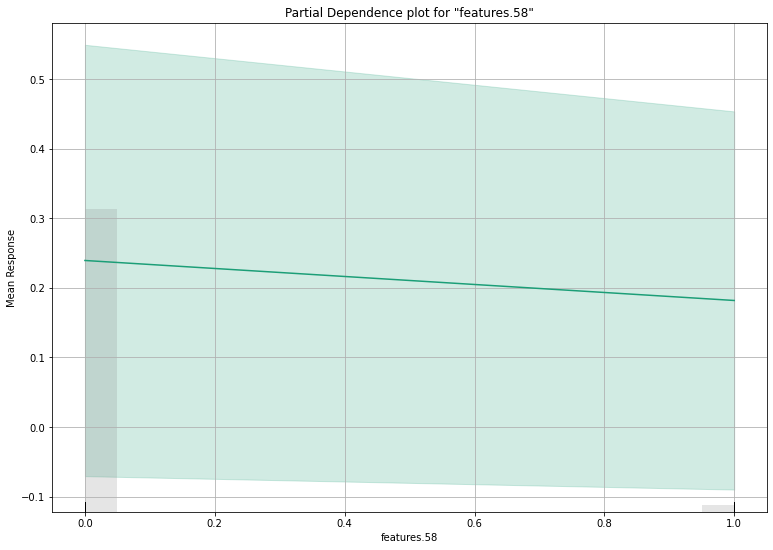

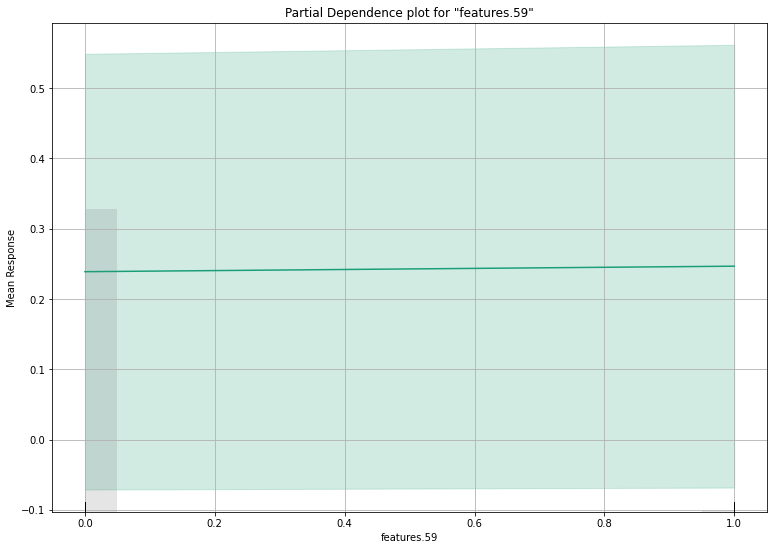

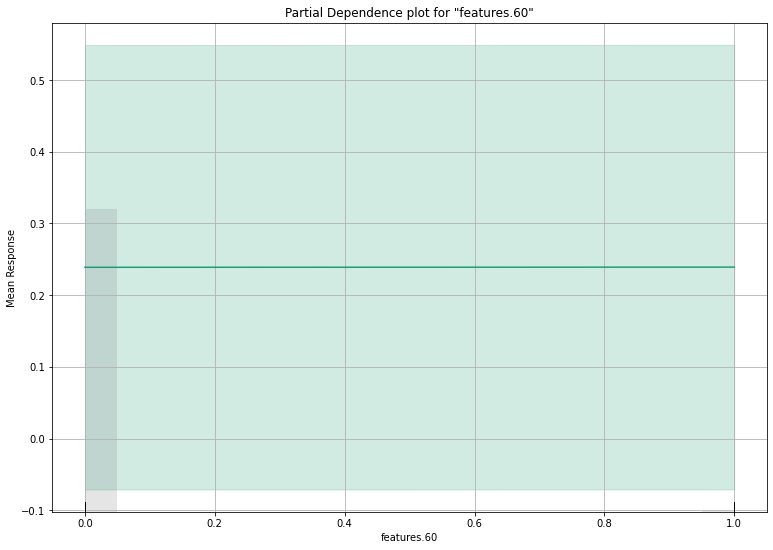

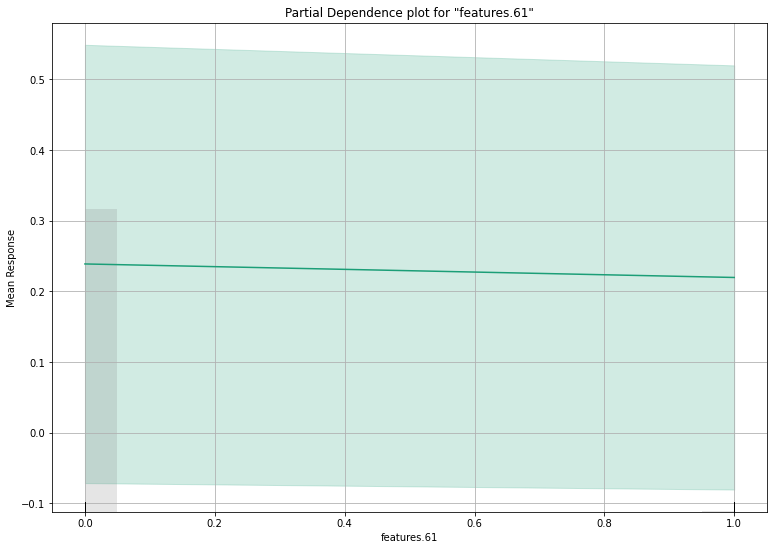

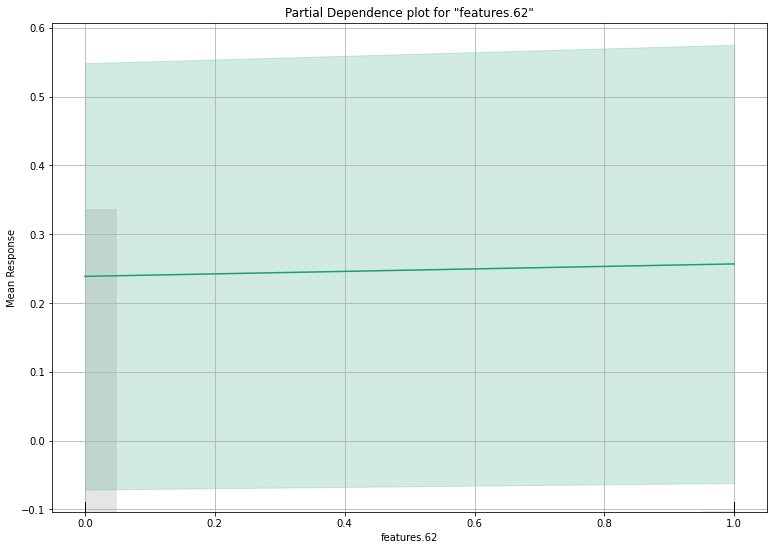

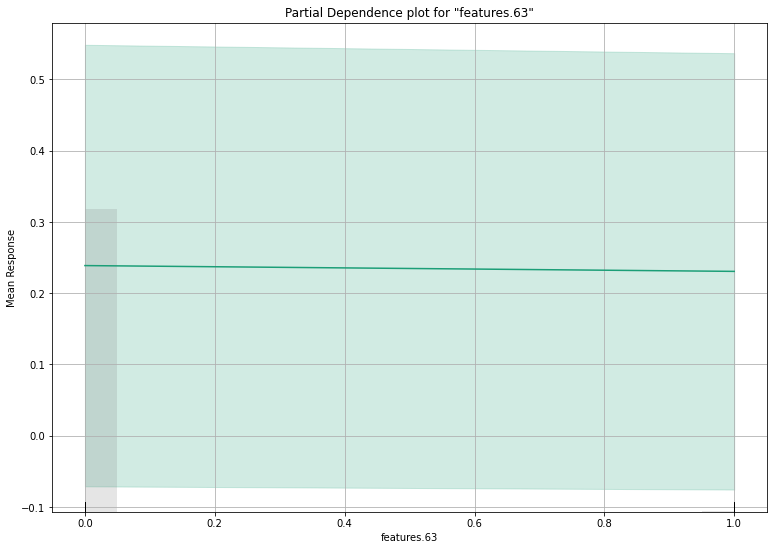

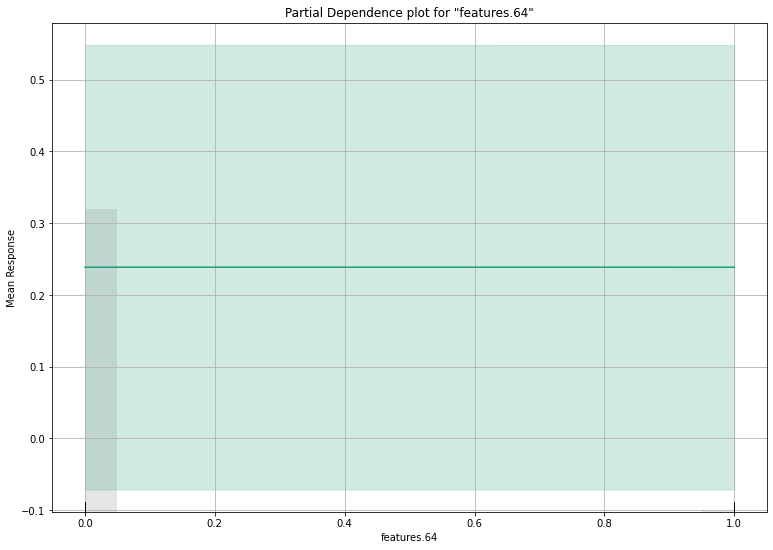

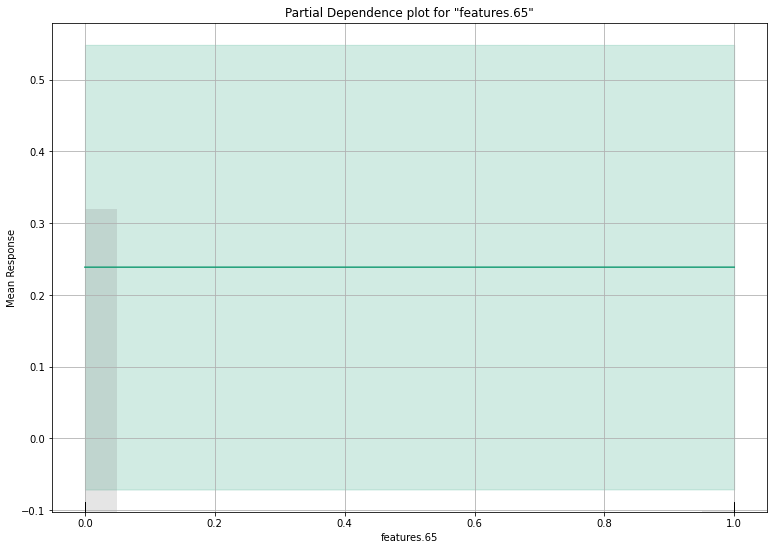

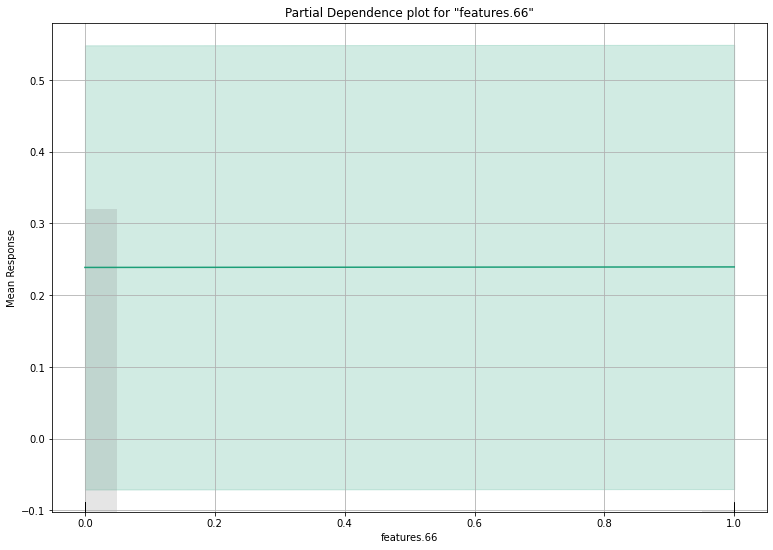

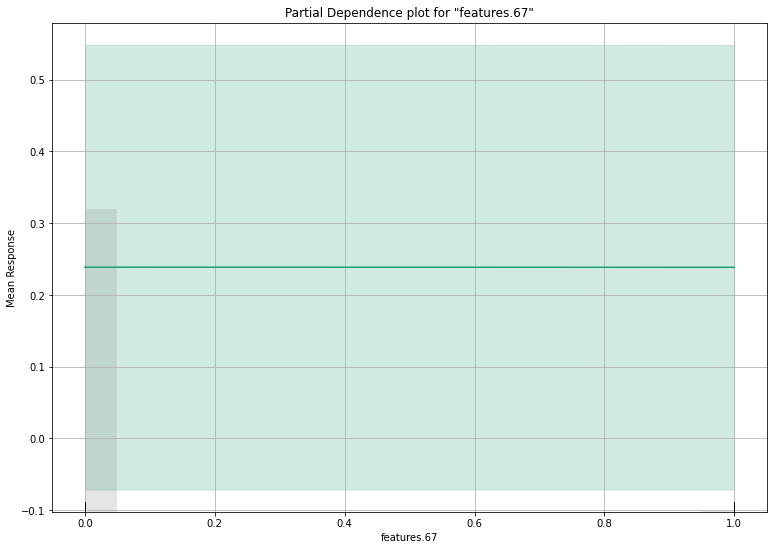

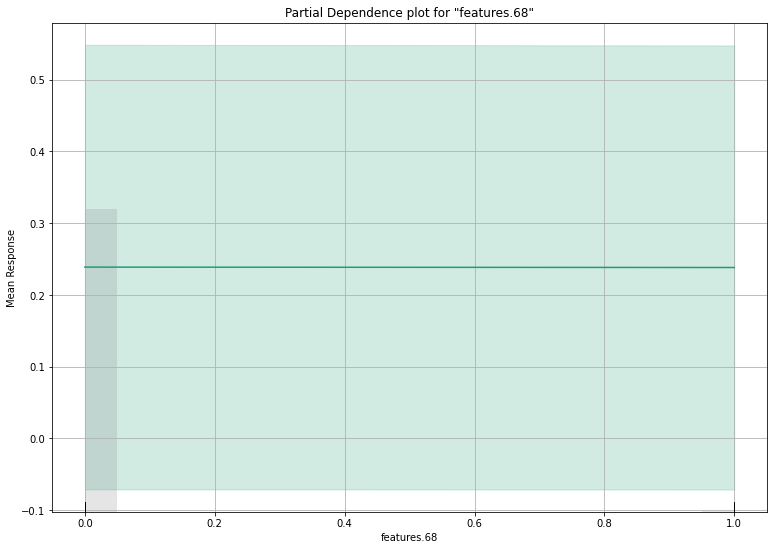

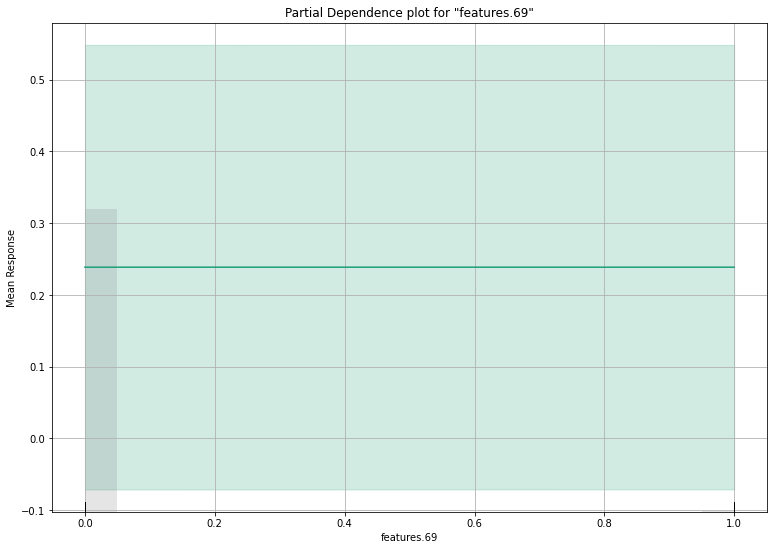

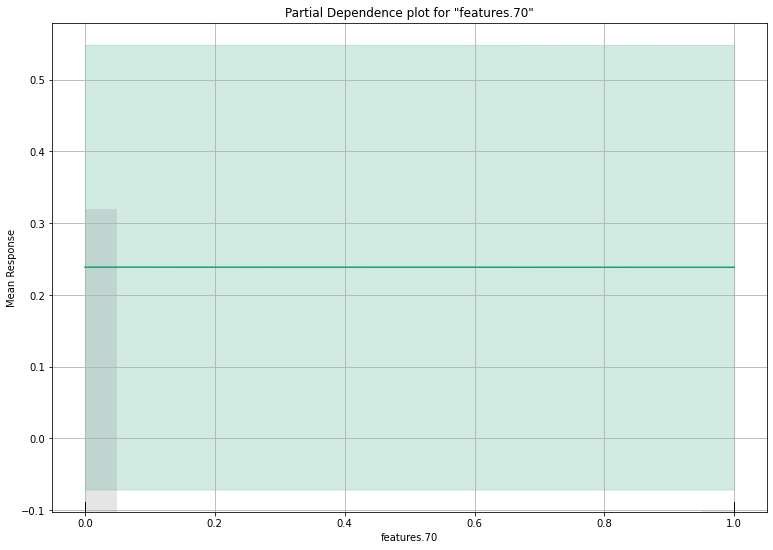

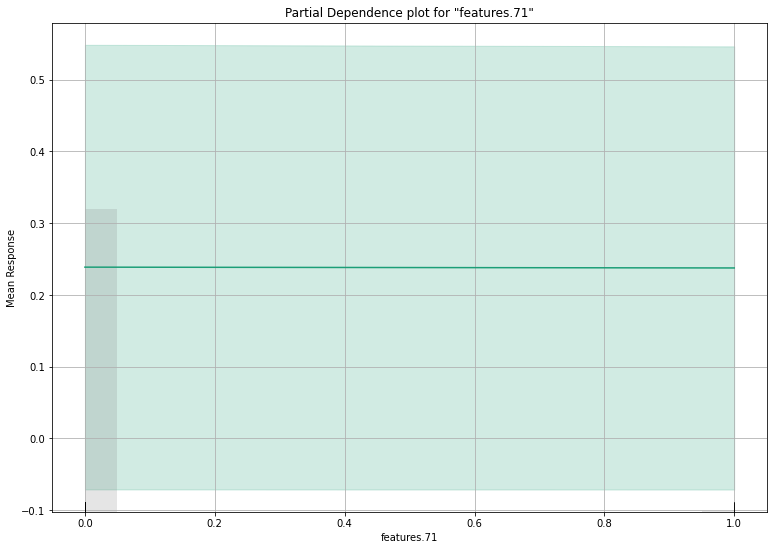

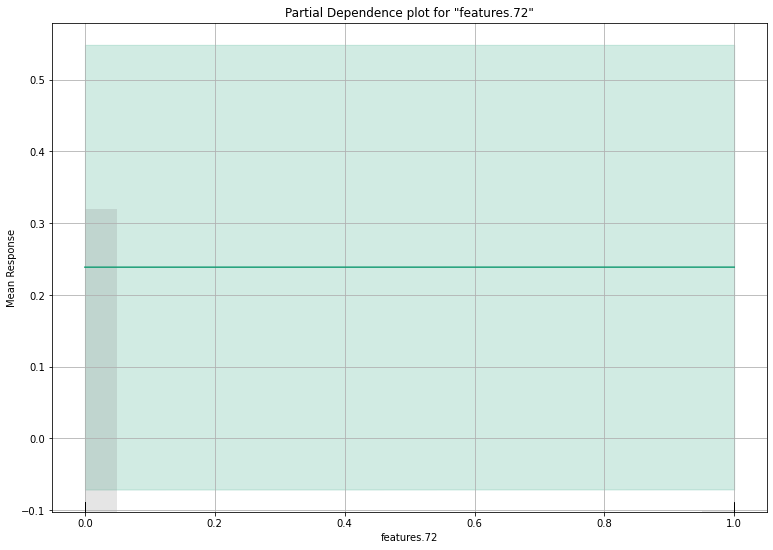

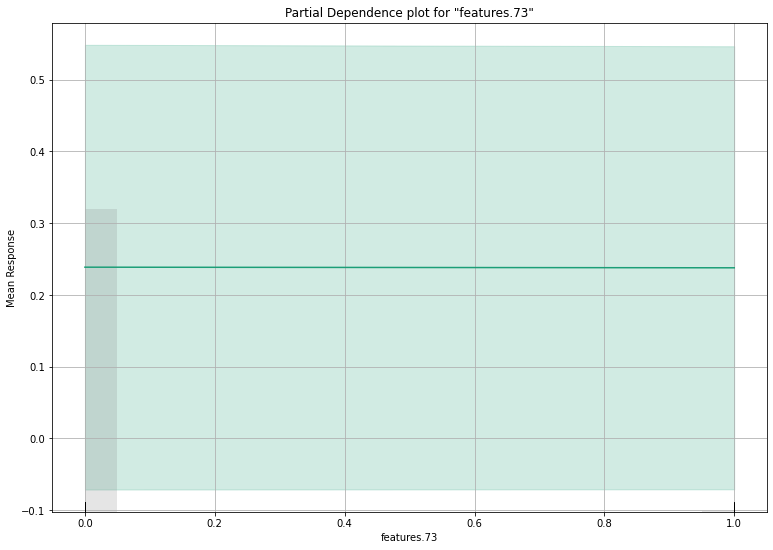

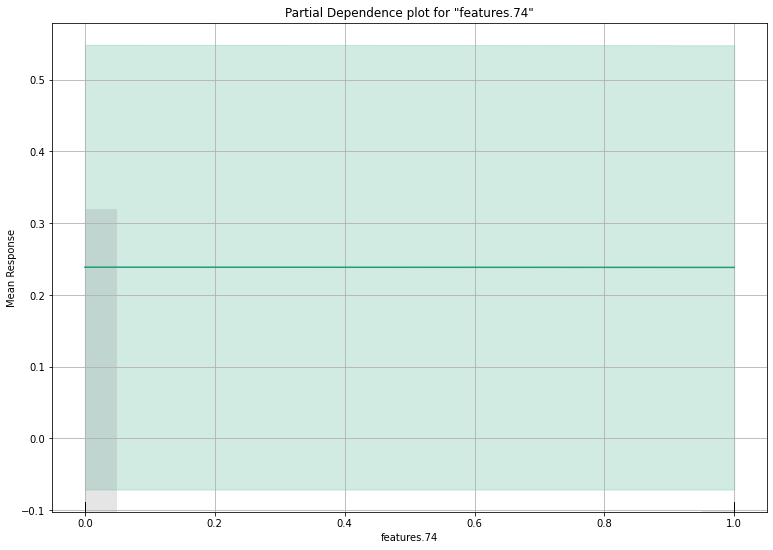

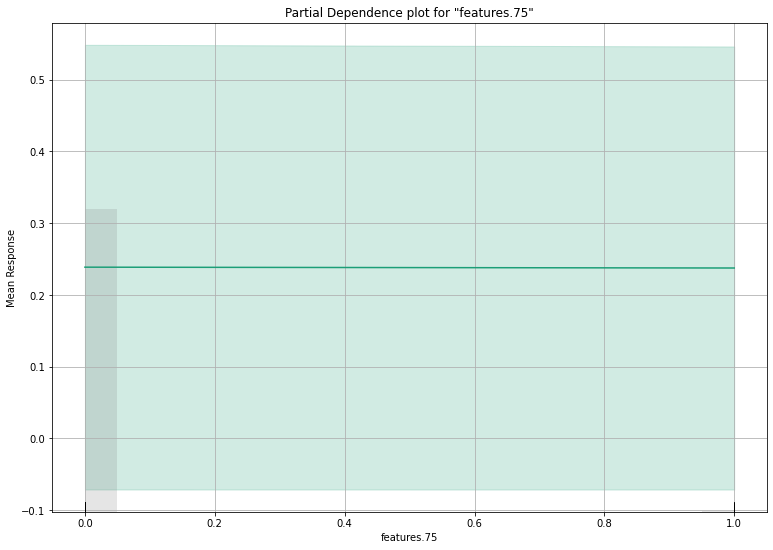

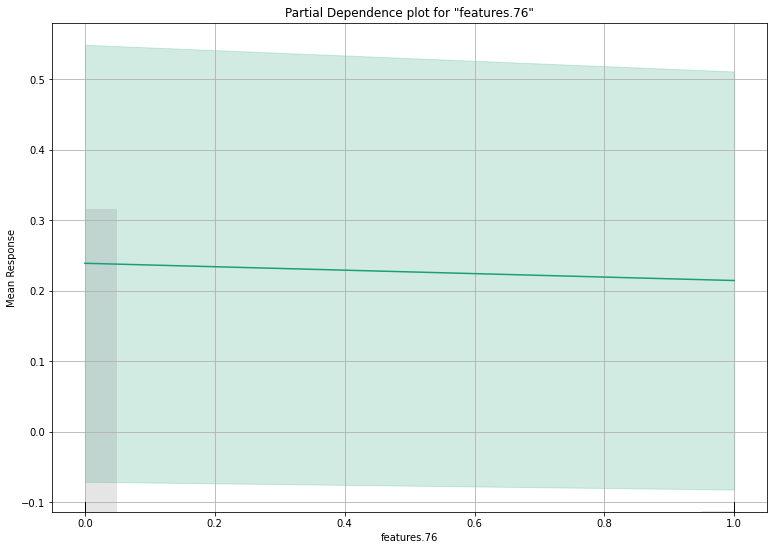

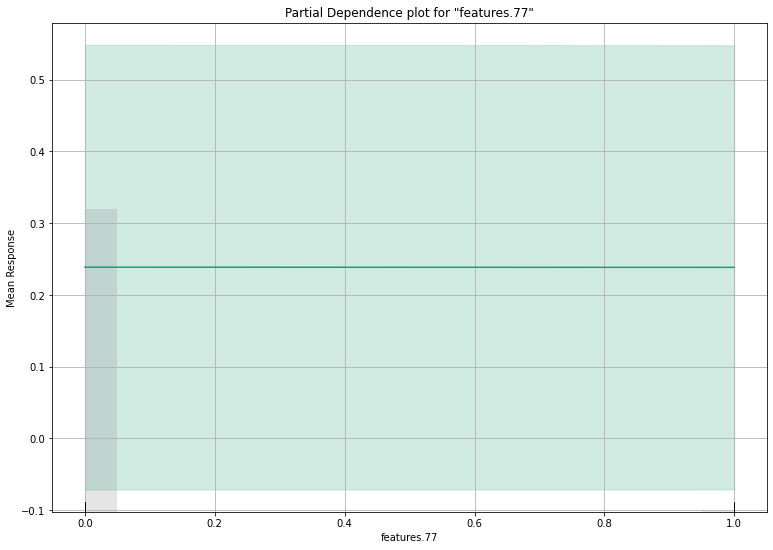

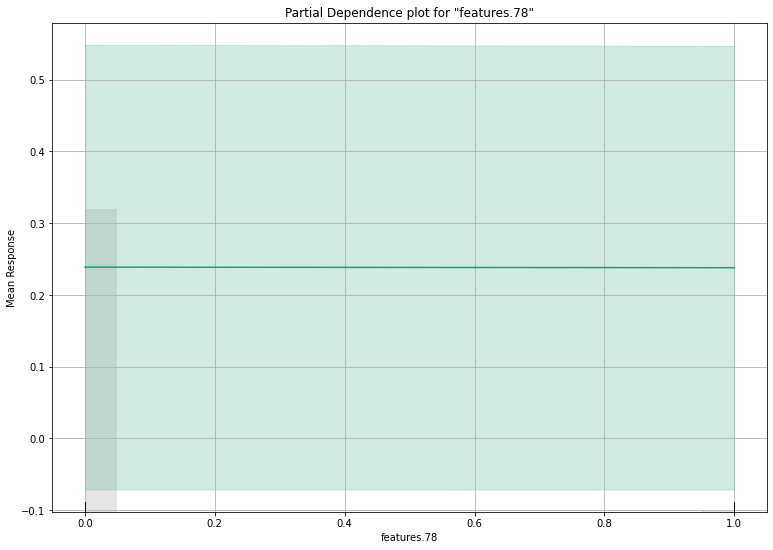

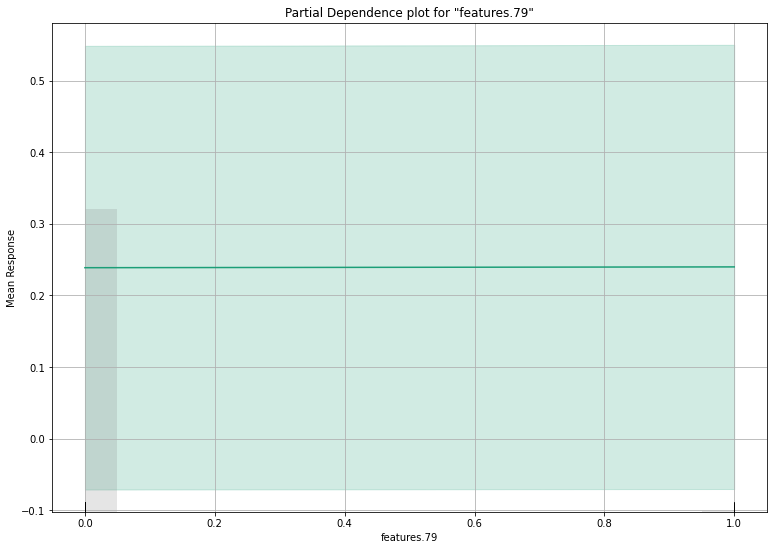

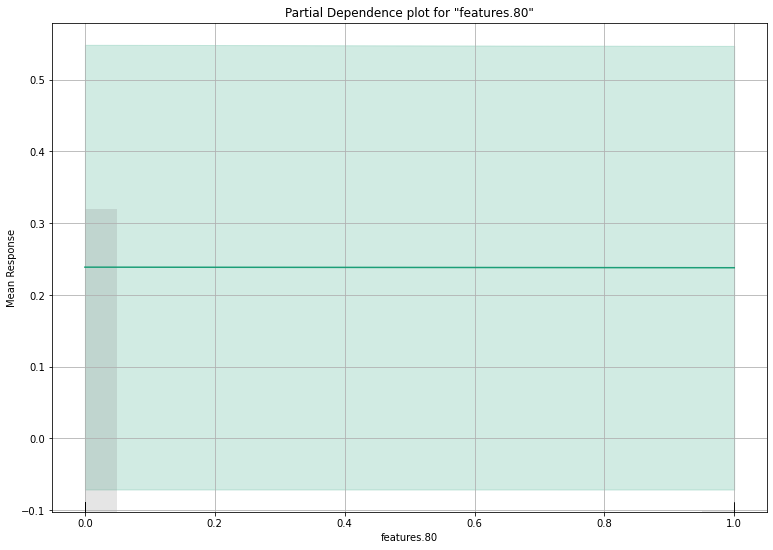

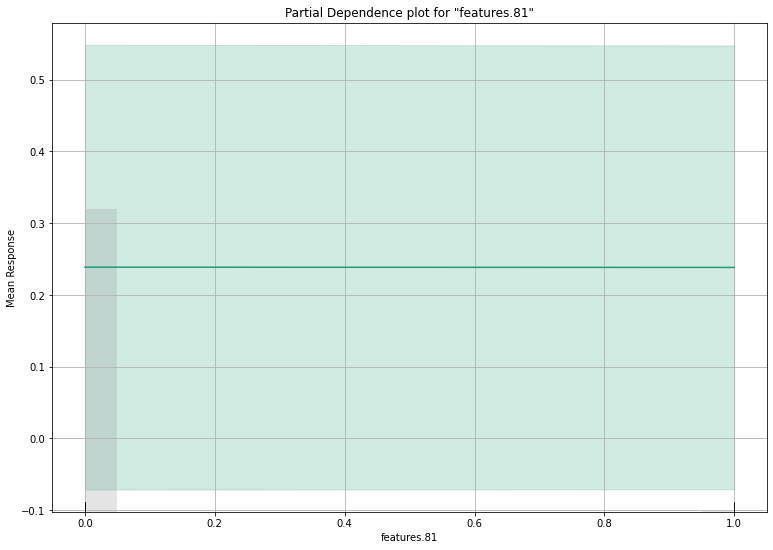

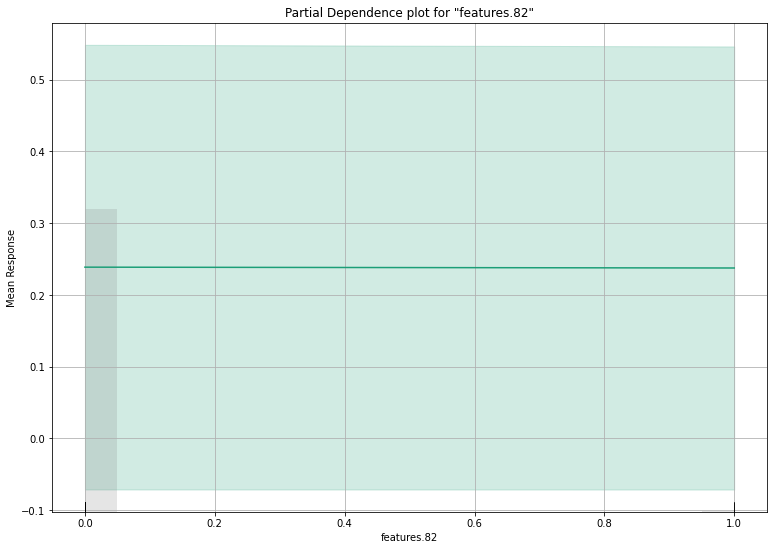

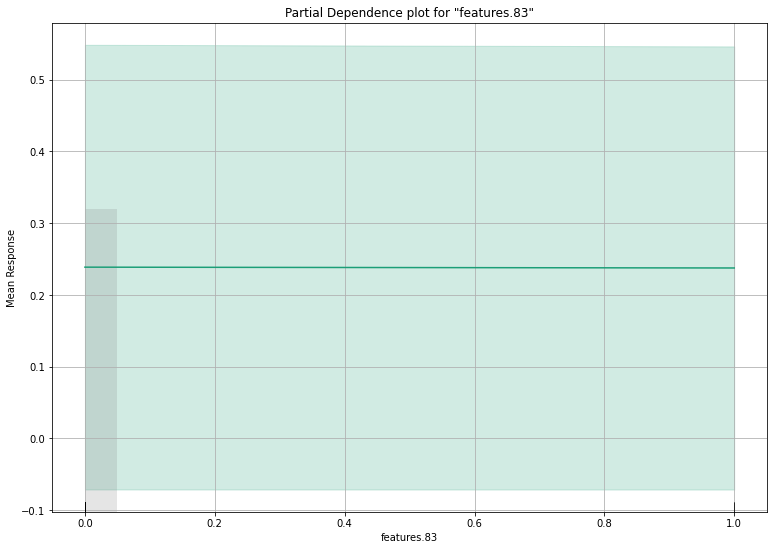

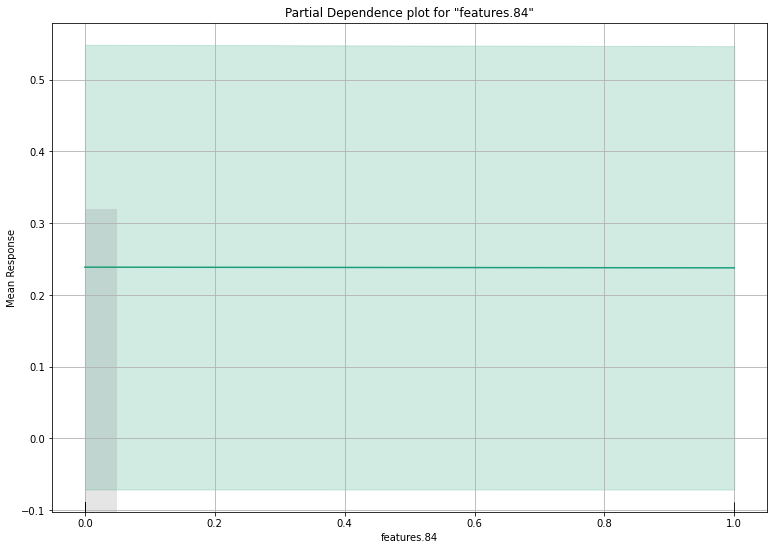

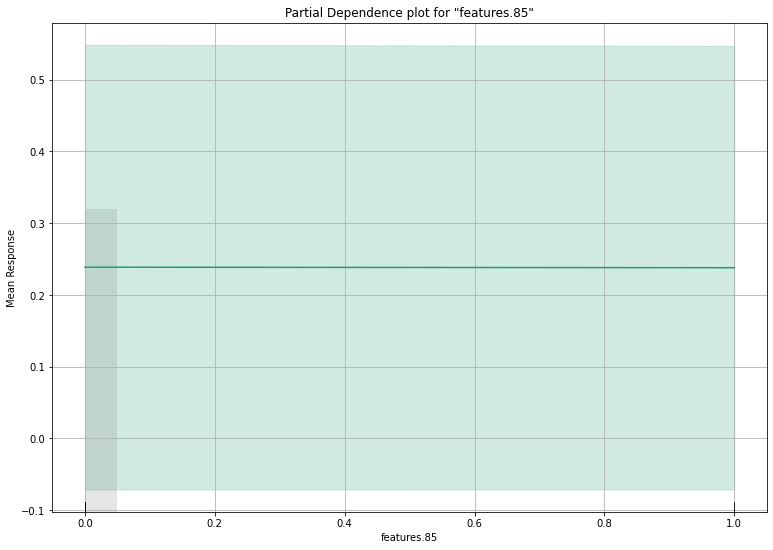

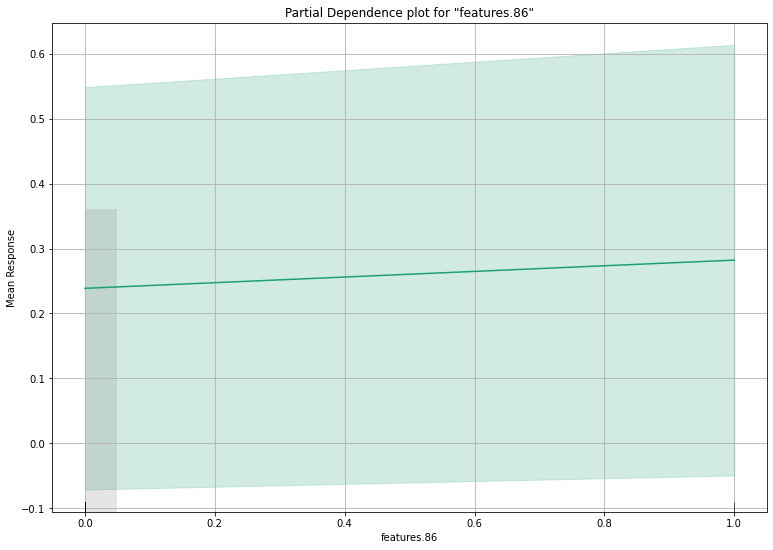

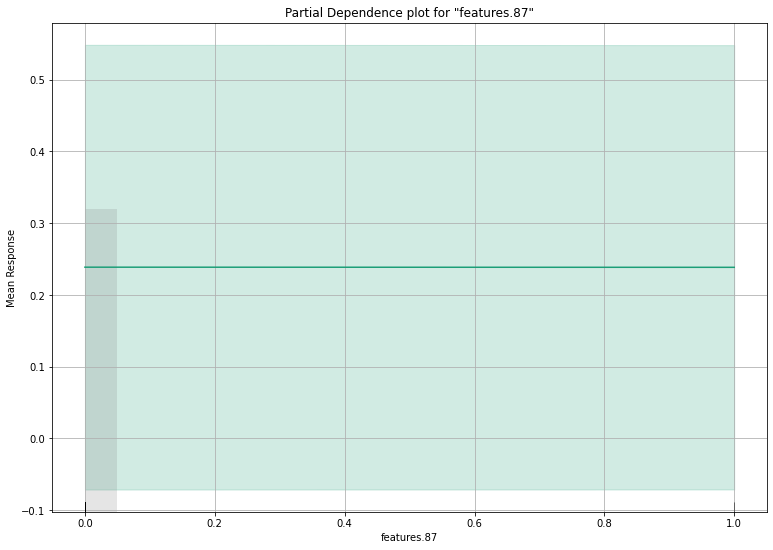

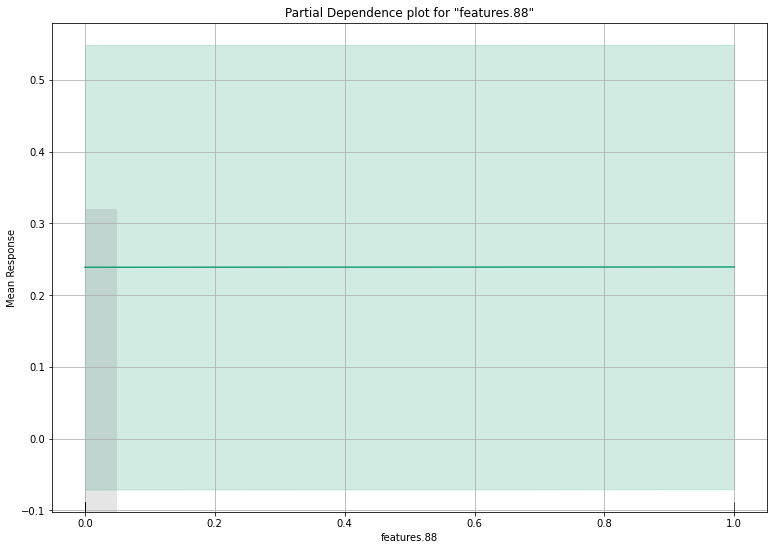

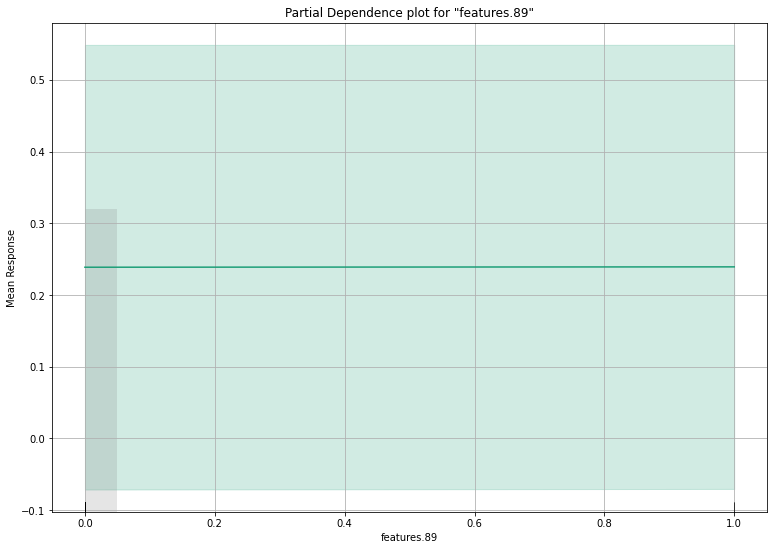

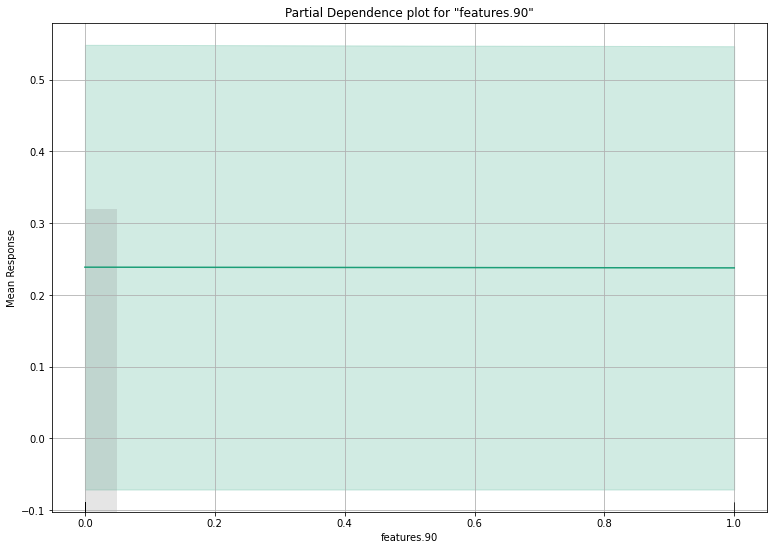

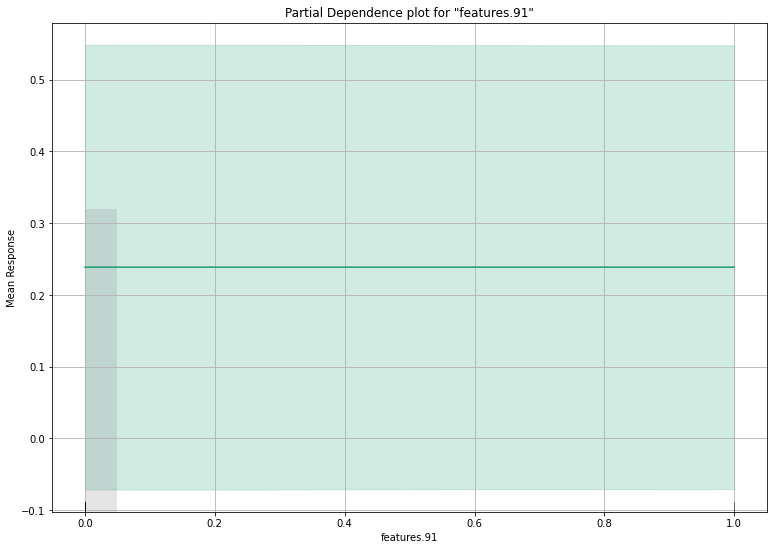

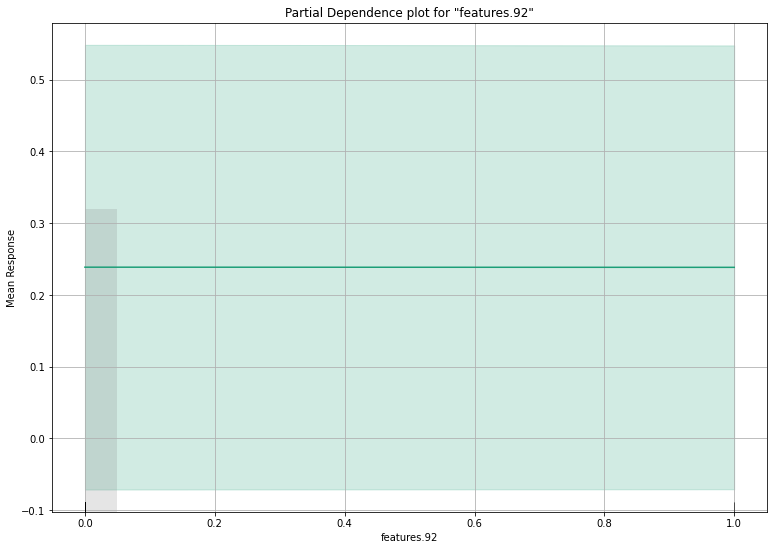

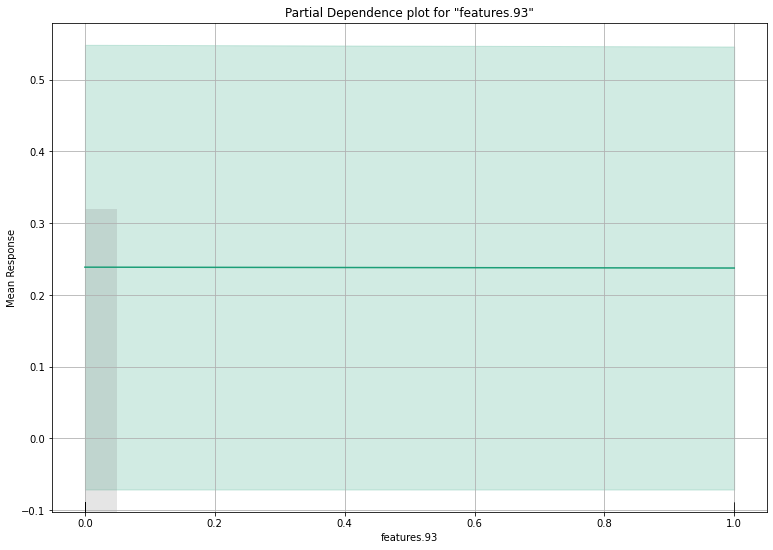

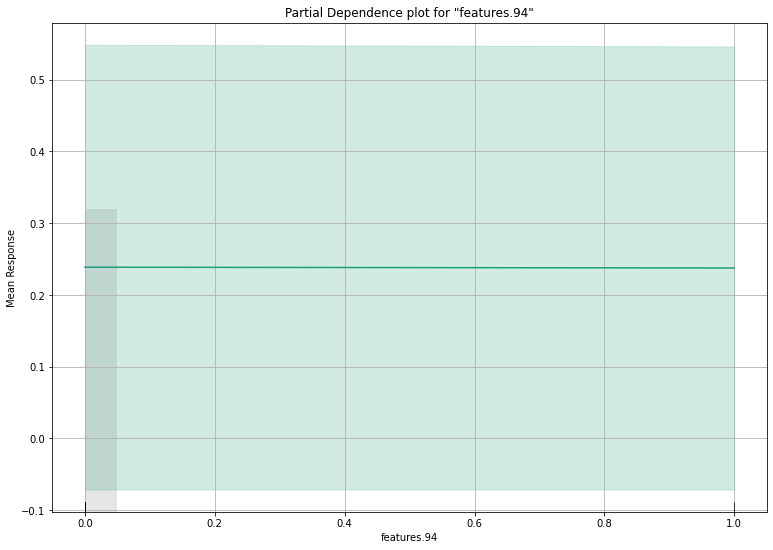

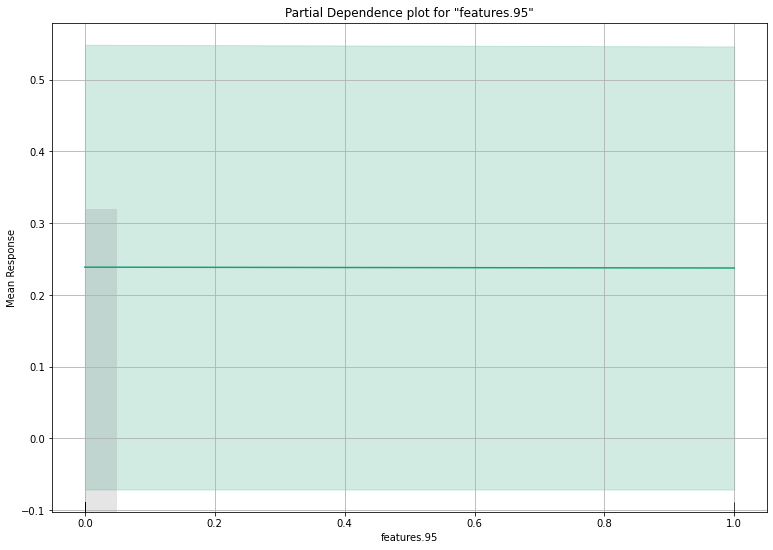

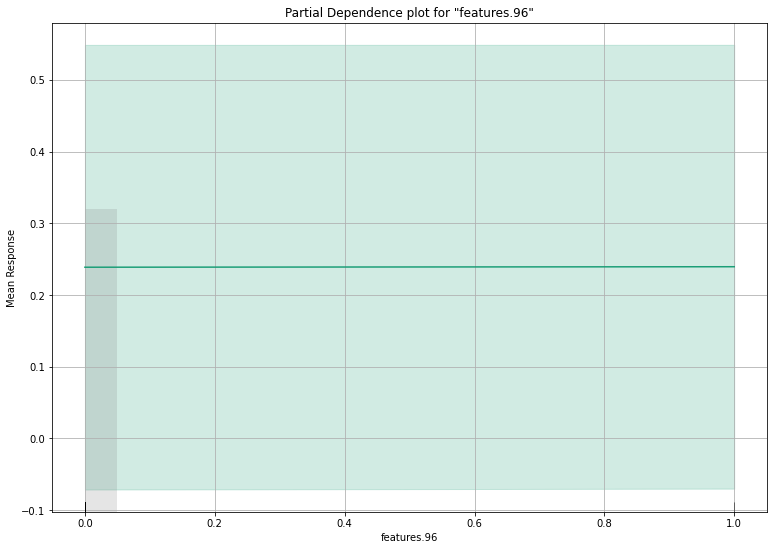

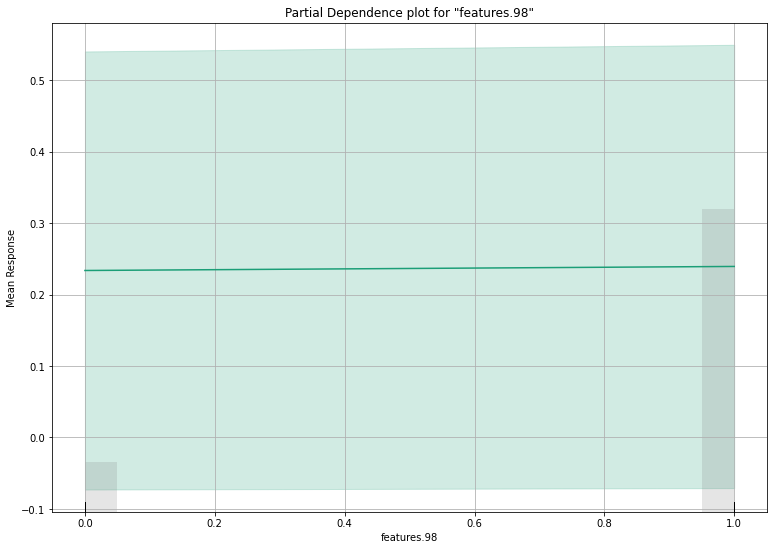

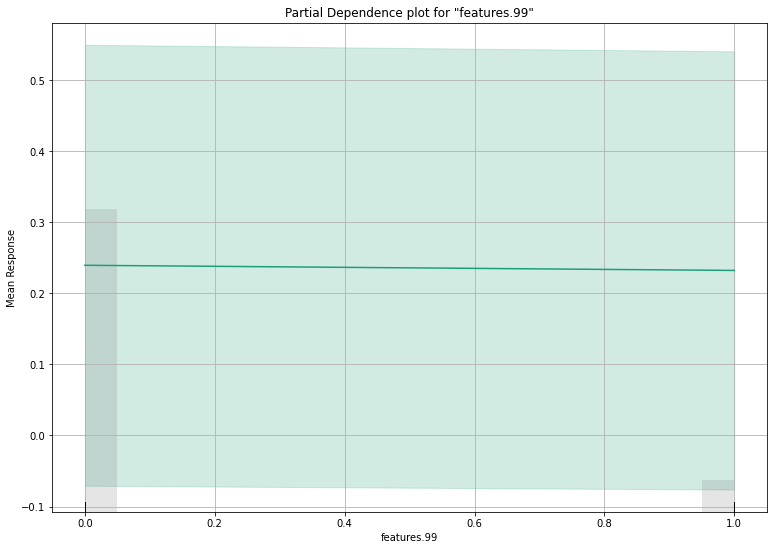

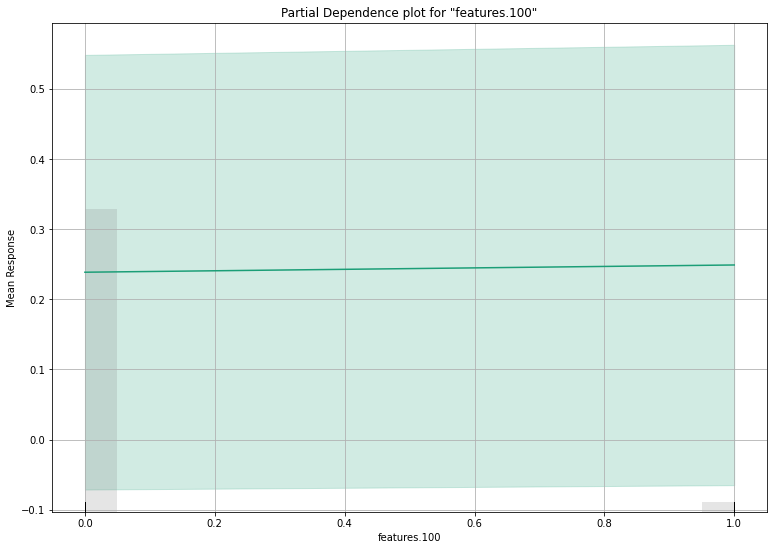

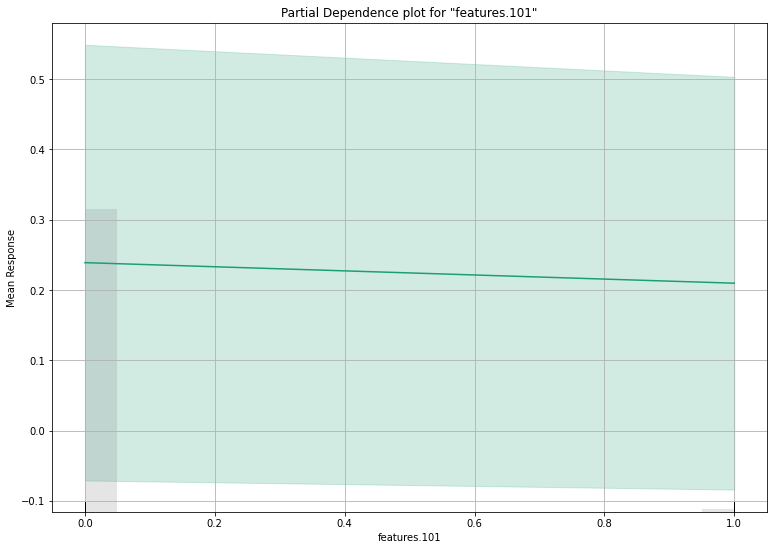

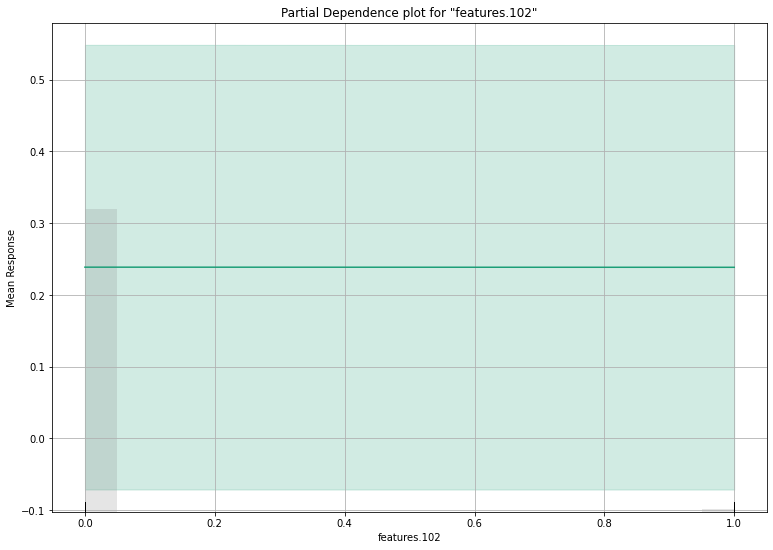

In [11]:
model_stack.explain(adult_valid_h2o)

In [12]:
ss.stop()